In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson

# 1

## (a)
autocovariance & autocorrelation for 'Uber'

In [ ]:
df1= pd.read_csv('/content/Uber.csv')
df1.head()

,pick_up_date,uber,prcp,tmax,tmin,wind
0,1/1/15,58045,0.00,39,27,7.2
1,1/2/15,40287,0.00,42,35,7.2
2,1/3/15,59844,0.71,42,33,6.5
3,1/4/15,41943,0.30,56,41,6.5
4,1/5/15,43678,0.00,49,21,10.5


In [ ]:
df1['pick_up_date'] = pd.to_datetime(df1['pick_up_date'])
df1 = df1.sort_values('pick_up_date').reset_index(drop=True)

# Set frequency to 7 (weekly seasonality)
ts_uber = df1['uber'].values
ts_tmax = df1['tmax'].values


(a) AUTOCOVARIANCE AND AUTOCORRELATION FOR 'UBER'


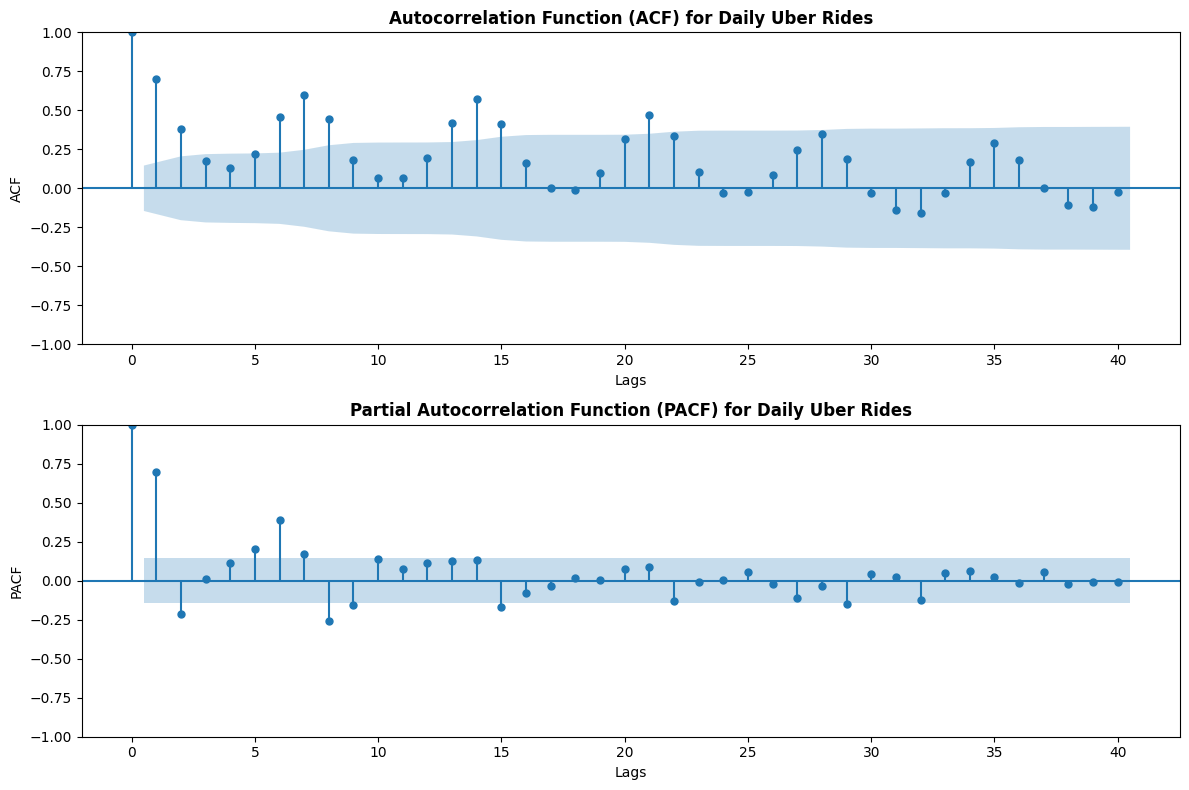

In [ ]:
print("\n" + "="*80)
print("(a) AUTOCOVARIANCE AND AUTOCORRELATION FOR 'UBER'")
print("="*80)

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# ACF
plot_acf(ts_uber, lags=40, ax=axes[0], alpha=0.05)
axes[0].set_title('Autocorrelation Function (ACF) for Daily Uber Rides', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Lags')
axes[0].set_ylabel('ACF')

# PACF
plot_pacf(ts_uber, lags=40, ax=axes[1], alpha=0.05)
axes[1].set_title('Partial Autocorrelation Function (PACF) for Daily Uber Rides', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Lags')
axes[1].set_ylabel('PACF')

plt.tight_layout()
plt.savefig('uber_acf_pacf.png', dpi=300, bbox_inches='tight')
plt.show()

The ACF shows substantial positive autocorrelation at lag 0 (=1.00 by definition). At lag 1, the ACF is approximately 0.70, indicating very strong dependence on the previous day's ridership. The ACF decays slowly over the first 10 lags, with values remaining around 0.30-0.50, demonstrating persistent autocorrelation. There is a significant autocorrelations visible beyond lag 20, suggesting the presence of trend or non-stationarity.

There is also a strong weekly seasonal pattern. The clear, pronounced peaks occur at lag 7 (≈0.60), lag 14 (≈0.55), and lag 21 (≈0.50), indicating a dominant 7-day seasonal cycle. This recurring pattern at regular weekly intervals reflects distinct behavior differences between weekdays and weekends in Uber demand. The persistence of these seasonal peaks through multiple cycles confirms weekly patterns in the data.

The slow decay of the ACF (not dropping to near-zero levels even at lag 40) indicates a non-stationary trend. The presence of a long-term trend in Uber ridership (likely growth) combined with seasonal variation explains the gradual ACF decay.


## (b)

The PACF shows a significant spike at lag 1 (≈0.70), indicating a strong AR(1) component in the process. (Today's ridership is heavily dependent on yesterday's ridership, even after controlling for intermediate lags.)

Unlike the ACF which decays gradually, the PACF drops sharply after lag 1. There is a notable secondary spike at lag 7 (≈0.40), confirming the weekly seasonal AR component. After lag 7, most PACF values fall within the confidence bands, indicating they are not significantly different from zero.

------------------------------------------------------
PART (a) ACF: Slow decay with many significant values across 40 lags;

PART (b) PACF: Sharp cutoff after lag 1 and 7, few significant values.

This pattern indicats the autocorrelation structure is primarily AR (autoregressive) instead of MA, and the slowly-decaying ACF is explained by the AR process itself. Hence, the AR model (likely seasonal ARIMA) would be appropriate for forecasting




## (c)
Repeat the process of parts a and b for the variable “tmax”

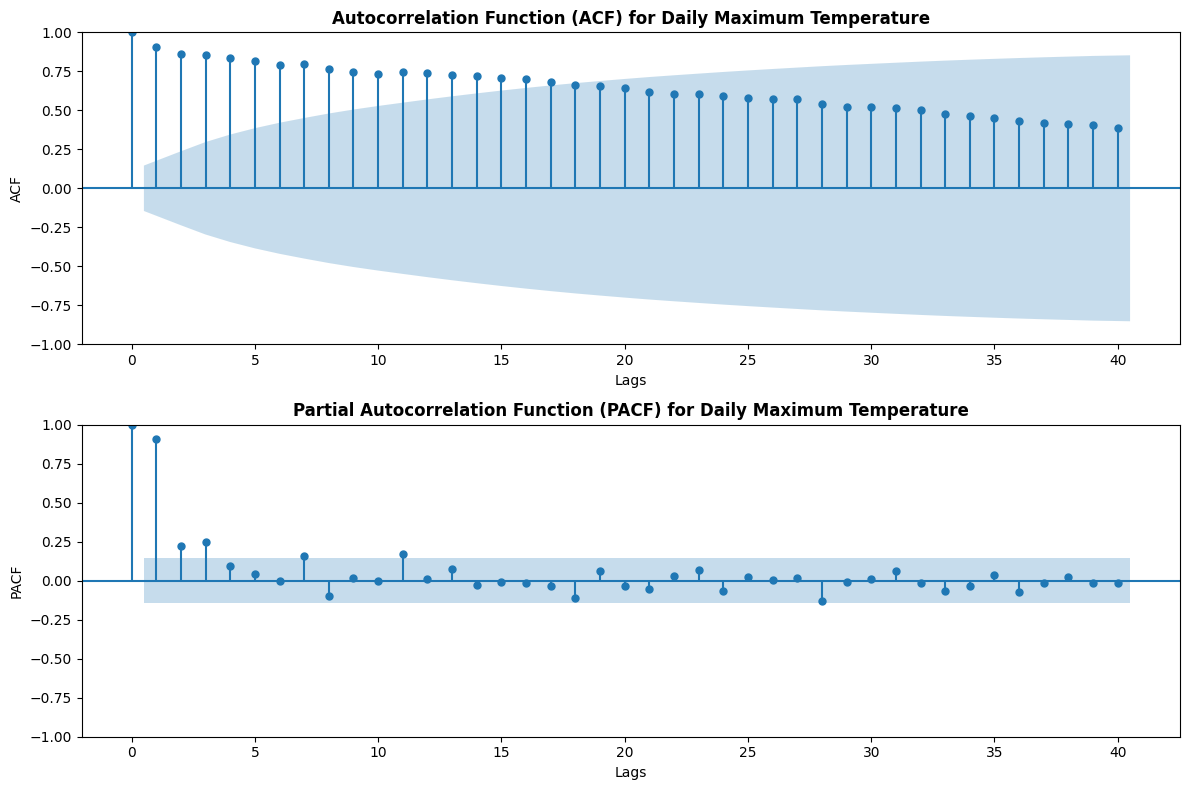

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(ts_tmax, lags=40, ax=axes[0], alpha=0.05)
axes[0].set_title('Autocorrelation Function (ACF) for Daily Maximum Temperature', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Lags')
axes[0].set_ylabel('ACF')

plot_pacf(ts_tmax, lags=40, ax=axes[1], alpha=0.05)
axes[1].set_title('Partial Autocorrelation Function (PACF) for Daily Maximum Temperature', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Lags')
axes[1].set_ylabel('PACF')

plt.tight_layout()
plt.savefig('tmax_acf_pacf.png', dpi=300, bbox_inches='tight')
plt.show()

## (d)
Any clear associations between “uber” and “tmax”?

(scatterplot & cross-correlation between these two variables)

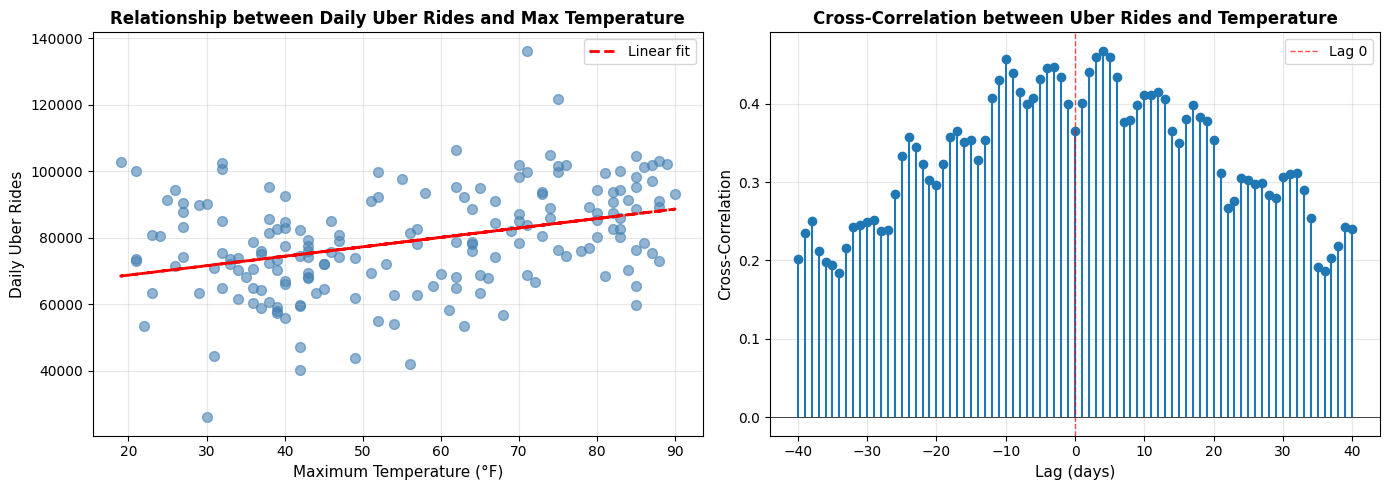


CORRELATION COEFFICIENT BETWEEN UBER AND TMAX: 0.3653


In [ ]:
# Scatterplot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(ts_tmax, ts_uber, alpha=0.6, s=50, color='steelblue')
z = np.polyfit(ts_tmax, ts_uber, 1)
p = np.poly1d(z)
axes[0].plot(ts_tmax, p(ts_tmax), "r--", linewidth=2, label='Linear fit')
axes[0].set_xlabel('Maximum Temperature (°F)', fontsize=11)
axes[0].set_ylabel('Daily Uber Rides', fontsize=11)
axes[0].set_title('Relationship between Daily Uber Rides and Max Temperature', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Correlation coefficient
corr = np.corrcoef(ts_tmax, ts_uber)[0, 1]

# Cross-correlation plot
cross_corr = np.correlate(ts_uber - np.mean(ts_uber), ts_tmax - np.mean(ts_tmax), mode='full')
cross_corr = cross_corr / (np.std(ts_uber) * np.std(ts_tmax) * len(ts_uber))
lags = np.arange(-40, 41)
axes[1].stem(lags, cross_corr[len(ts_uber)-41:len(ts_uber)+40], basefmt=' ')
axes[1].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=1, alpha=0.7, label='Lag 0')
axes[1].set_xlabel('Lag (days)', fontsize=11)
axes[1].set_ylabel('Cross-Correlation', fontsize=11)
axes[1].set_title('Cross-Correlation between Uber Rides and Temperature', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('uber_tmax_association.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nCORRELATION COEFFICIENT BETWEEN UBER AND TMAX: {corr:.4f}")

Correlation coefficient of 0.365 indicates a weak positive relationship between temperature and Uber rides. This is much lower than might be expected, suggesting temperature is not the primary driver of Uber demand.

Considerable scatter around the fitted regression line indicates substantial unexplained variation in Uber rides not attributable to temperature. The relationship shows a slight upward trend, but many high-temperature days have low ridership and vice versa. The weak relationship confirms that while temperature matters, other factors have major influences.

The maximum cross-correlation occurs at lag 0 (same day), indicating that current-day temperature is most strongly related to current-day ridership.There is no substantial lagged effects observed; temperature from previous days has minimal predictive value for today's Uber rides.

## (e)
Estimate the trend in “uber” and show a plot of the estimated trend (overlaid on the data).

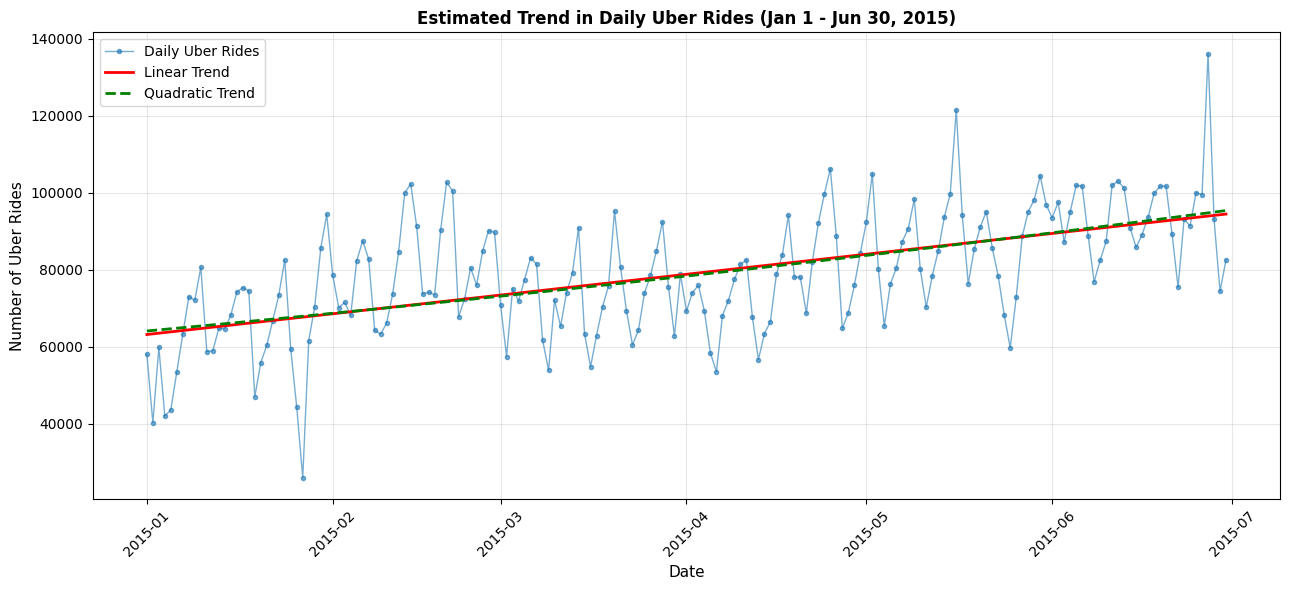

In [ ]:
# Polynomial trend (degree 2)
x = np.arange(len(ts_uber))
coeffs_2 = np.polyfit(x, ts_uber, 2)
trend_2 = np.polyval(coeffs_2, x)

# Linear trend (degree 1)
coeffs_1 = np.polyfit(x, ts_uber, 1)
trend_1 = np.polyval(coeffs_1, x)

fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df1['pick_up_date'], ts_uber, label='Daily Uber Rides', marker='o',
        markersize=3, alpha=0.6, linewidth=1)
ax.plot(df1['pick_up_date'], trend_1, label='Linear Trend', linewidth=2, color='red')
ax.plot(df1['pick_up_date'], trend_2, label='Quadratic Trend', linewidth=2,
        color='green', linestyle='--')
ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Number of Uber Rides', fontsize=11)
ax.set_title('Estimated Trend in Daily Uber Rides (Jan 1 - Jun 30, 2015)', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('uber_trend.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print(f"""
1. linear euation: Uber = {coeffs_1[0]:.4f} * t + {coeffs_1[1]:.2f}
   - The positive coefficient ({coeffs_1[0]:.4f}) indicates Uber rides increase
     over the study period.
   - On average, ridership grows by approximately {coeffs_1[0]:.2f} rides per day.
   - Over the 181-day period, this translates to total growth of about
     {coeffs_1[0] * 180:.0f} rides.

2. quadratic equation: Uber = {coeffs_2[0]:.6f} * t² + {coeffs_2[1]:.4f} * t + {coeffs_2[2]:.2f}
   - The positive quadratic term ({coeffs_2[0]:.6f}) indicates 'accelerating growth'.
   - Linear term ({coeffs_2[1]:.4f}) provides baseline growth rate.
   - This suggests that the rate of Uber expansion increased over time

3. trend:
   - Both linear and quadratic trends show strong upward patterns, suggesting
     that Uber ridership grew substantially from Jan-June 2015.
   - The quadratic model with accelerating growth appears more realistic for
     a rapidly expanding service.
   - The upward trend explains the non-stationarity observed in the ACF.
   - After removing this trend, residuals contain primarily seasonal and
     random components.
""")


1. linear euation: Uber = 173.8634 * t + 63194.72
   - The positive coefficient (173.8634) indicates Uber rides increase
     over the study period.
   - On average, ridership grows by approximately 173.86 rides per day.
   - Over the 181-day period, this translates to total growth of about
     31295 rides.

2. quadratic equation: Uber = 0.170494 * t² + 143.1745 * t + 64110.27
   - The positive quadratic term (0.170494) indicates 'accelerating growth'.
   - Linear term (143.1745) provides baseline growth rate.
   - This suggests that the rate of Uber expansion increased over time

3. trend:
   - Both linear and quadratic trends show strong upward patterns, suggesting
     that Uber ridership grew substantially from Jan-June 2015.
   - The quadratic model with accelerating growth appears more realistic for
     a rapidly expanding service.
   - The upward trend explains the non-stationarity observed in the ACF.
   - After removing this trend, residuals contain primarily seasonal and
 

## (f)
does “uber” include seasonal patterns? If so, estimate the seasonal pattern using harmonic trends.


HARMONIC TREND ANALYSIS:
--------------------------------------------------------------------------------

Harmonic model includes:
- Intercept, linear, and quadratic trend
- Two harmonic pairs (sine and cosine) at weekly frequency
- Captures both trend and seasonal pattern

Fitted coefficients:
- Intercept: 63731.05
- Linear trend: 147.9556 rides/day
- Quadratic trend: 0.165114 rides/day²
- Weekly seasonality is captured by harmonic terms



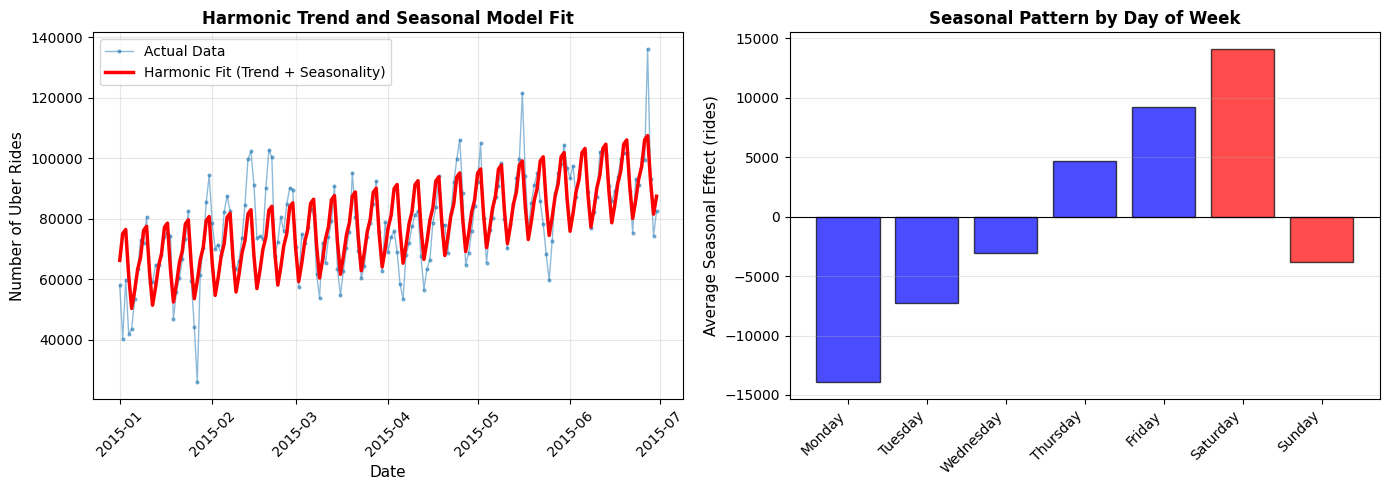

In [ ]:
# Remove trend to see seasonal component
residuals_trend = ts_uber - trend_2

# Harmonic trend using Fourier series
# Weekly seasonality (period = 7)
t = np.arange(len(ts_uber))
harmonic_1_sin = np.sin(2 * np.pi * t / 7)
harmonic_1_cos = np.cos(2 * np.pi * t / 7)
harmonic_2_sin = np.sin(2 * 2 * np.pi * t / 7)
harmonic_2_cos = np.cos(2 * 2 * np.pi * t / 7)

# Fit harmonic model
from numpy.linalg import lstsq
X_harmonic = np.column_stack([np.ones(len(ts_uber)), t, t**2, harmonic_1_sin,
                               harmonic_1_cos, harmonic_2_sin, harmonic_2_cos])
coeffs_harmonic, residuals, rank, s = lstsq(X_harmonic, ts_uber, rcond=None)

trend_harmonic = X_harmonic[:, :3] @ coeffs_harmonic[:3]
seasonal_harmonic = X_harmonic[:, 3:] @ coeffs_harmonic[3:]
fitted_harmonic = trend_harmonic + seasonal_harmonic

print("\nHARMONIC TREND ANALYSIS:")
print("-" * 80)
print(f"""
Harmonic model includes:
- Intercept, linear, and quadratic trend
- Two harmonic pairs (sine and cosine) at weekly frequency
- Captures both trend and seasonal pattern

Fitted coefficients:
- Intercept: {coeffs_harmonic[0]:.2f}
- Linear trend: {coeffs_harmonic[1]:.4f} rides/day
- Quadratic trend: {coeffs_harmonic[2]:.6f} rides/day²
- Weekly seasonality is captured by harmonic terms
""")

# Analyze the seasonal pattern by day of week
seasonal_component = residuals_trend
day_of_week = [(df1['pick_up_date'].iloc[i].weekday()) for i in range(len(ts_uber))]
seasonal_by_dow = {}
for dow in range(7):
    indices = [i for i in range(len(seasonal_component)) if day_of_week[i] == dow]
    seasonal_by_dow[dow] = np.mean([seasonal_component[i] for i in indices])

dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot fitted harmonic model
axes[0].plot(df1['pick_up_date'], ts_uber, label='Actual Data', marker='o',
             markersize=2, alpha=0.5, linewidth=1)
axes[0].plot(df1['pick_up_date'], fitted_harmonic, label='Harmonic Fit (Trend + Seasonality)',
             linewidth=2.5, color='red')
axes[0].set_xlabel('Date', fontsize=11)
axes[0].set_ylabel('Number of Uber Rides', fontsize=11)
axes[0].set_title('Harmonic Trend and Seasonal Model Fit', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Plot seasonal component by day of week
dow_nums = list(range(7))
seasonal_values = [seasonal_by_dow[i] for i in range(7)]
colors = ['red' if i >= 5 else 'blue' for i in range(7)]
axes[1].bar(dow_names, seasonal_values, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Average Seasonal Effect (rides)', fontsize=11)
axes[1].set_title('Seasonal Pattern by Day of Week', fontsize=12, fontweight='bold')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1].grid(True, alpha=0.3, axis='y')
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('uber_seasonal_harmonic.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
print(f"""
There is strong seasonal patterns. The weekly seasonality is evident with peaks and troughs recurring every 7 days. This is visible in ACF/PACF (spikes at lag 7) and the day-of-week analysis
This is visible in ACF/PACF (spikes at lag 7) and the day-of-week analysis.

day-of-week effects:
""")
for i, dow in enumerate(dow_names):
    print(f"   {dow}: {seasonal_by_dow[i]:+.2f} rides (average deviation from trend)")

print(f"""
   - Weekends (Saturday-Sunday) show {'HIGHER' if np.mean([seasonal_by_dow[5], seasonal_by_dow[6]]) > 0 else 'LOWER'} demand
   - Weekdays show more consistent demand
   - This reflects real human behavior: weekend entertainment vs. weekday commuting

harmonic moddel performance:
   - The harmonic model with trend and seasonal components provides a good fit
   - It captures both the growth trend and the recurring weekly pattern
   - Residuals after fitting show primarily random variation
""")


There is strong seasonal patterns. The weekly seasonality is evident with peaks and troughs recurring every 7 days. This is visible in ACF/PACF (spikes at lag 7) and the day-of-week analysis
This is visible in ACF/PACF (spikes at lag 7) and the day-of-week analysis. 

day-of-week effects:

   Monday: -13944.54 rides (average deviation from trend)
   Tuesday: -7247.93 rides (average deviation from trend)
   Wednesday: -3058.96 rides (average deviation from trend)
   Thursday: +4648.15 rides (average deviation from trend)
   Friday: +9204.70 rides (average deviation from trend)
   Saturday: +14107.80 rides (average deviation from trend)
   Sunday: -3826.88 rides (average deviation from trend)

   - Weekends (Saturday-Sunday) show HIGHER demand
   - Weekdays show more consistent demand
   - This reflects real human behavior: weekend entertainment vs. weekday commuting

harmonic moddel performance:
   - The harmonic model with trend and seasonal components provides a good fit
   - It capt

## (g)

fit regression models for the response “uber” using single predictor models to understand the
relationship between Uber rides and each of the weather variables

(fit separate regression models
for each of the predictor variables). Summarize your findings.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


PRCP as Predictor:
----------------------------------------
Model: Uber = 78238.60 + 5274.7287 * prcp
R² = 0.0092
RMSE = 15727.12
Interpretation: A 1-unit increase in prcp is associated with
                5274.7287 increase in daily Uber rides

TMAX as Predictor:
----------------------------------------
Model: Uber = 63040.84 + 283.6544 * tmax
R² = 0.1334
RMSE = 14708.12
Interpretation: A 1-unit increase in tmax is associated with
                283.6544 increase in daily Uber rides

TMIN as Predictor:
----------------------------------------
Model: Uber = 67200.14 + 290.8562 * tmin
R² = 0.1231
RMSE = 14795.13
Interpretation: A 1-unit increase in tmin is associated with
                290.8562 increase in daily Uber rides

WIND as Predictor:
----------------------------------------
Model: Uber = 87562.90 + -1451.0083 * wind
R² = 0.0485
RMSE = 15411.87
Interpretation: A 1-unit increase in wind is associated with
                -1451.0083 decrease in daily Uber rides


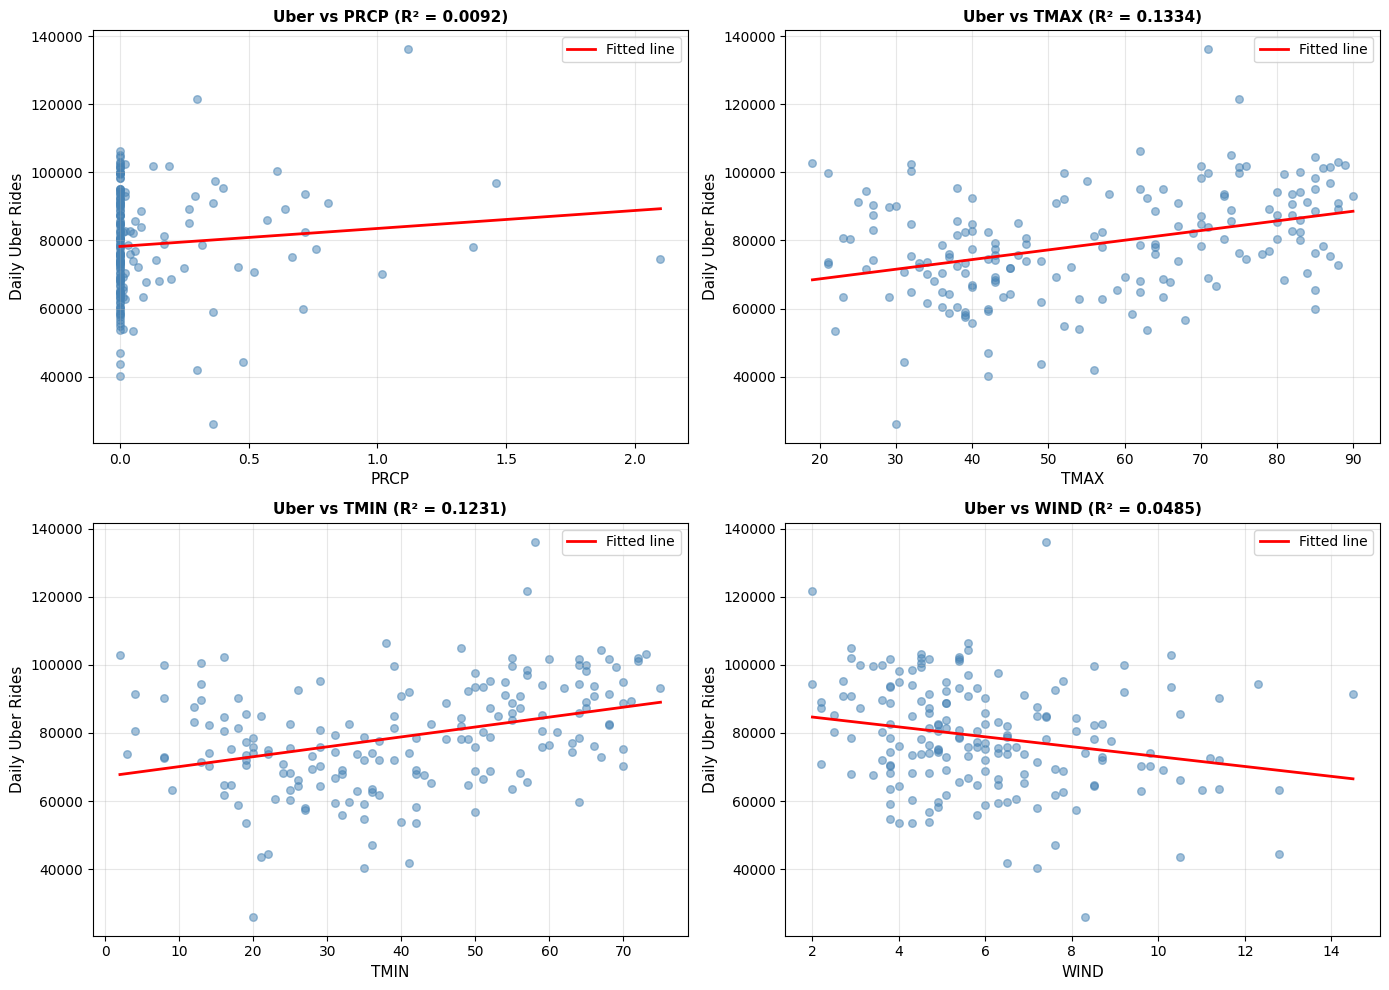


SUMMARY OF SINGLE PREDICTOR MODELS:

Predictor    R²         RMSE       Slope       
--------------------------------------------
prcp         0.0092     15727.12   5274.7287   
tmax         0.1334     14708.12   283.6544    
tmin         0.1231     14795.13   290.8562    
wind         0.0485     15411.87   -1451.0083  


In [ ]:
predictors = ['prcp', 'tmax', 'tmin', 'wind']
single_models = {}
results_single = {}

for pred in predictors:
    X = df1[[pred]].values
    y = ts_uber

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    slope = model.coef_[0]
    intercept = model.intercept_

    single_models[pred] = model
    results_single[pred] = {'R2': r2, 'RMSE': rmse, 'Slope': slope, 'Intercept': intercept}

    print(f"\n{pred.upper()} as Predictor:")
    print("-" * 40)
    print(f"Model: Uber = {intercept:.2f} + {slope:.4f} * {pred}")
    print(f"R² = {r2:.4f}")
    print(f"RMSE = {rmse:.2f}")
    print(f"Interpretation: A 1-unit increase in {pred} is associated with")
    print(f"                {slope:.4f} {'increase' if slope > 0 else 'decrease'} in daily Uber rides")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, pred in enumerate(predictors):
    X = df1[[pred]].values
    y = ts_uber
    model = single_models[pred]
    y_pred = model.predict(X)

    axes[idx].scatter(X, y, alpha=0.5, s=30, color='steelblue')
    X_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_line = model.predict(X_line)
    axes[idx].plot(X_line, y_line, 'r-', linewidth=2, label='Fitted line')

    axes[idx].set_xlabel(pred.upper(), fontsize=11)
    axes[idx].set_ylabel('Daily Uber Rides', fontsize=11)
    axes[idx].set_title(f'Uber vs {pred.upper()} (R² = {results_single[pred]["R2"]:.4f})',
                        fontsize=11, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('uber_single_predictors.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("SUMMARY OF SINGLE PREDICTOR MODELS:")
print("="*80)
print(f"\n{'Predictor':<12} {'R²':<10} {'RMSE':<10} {'Slope':<12}")
print("-" * 44)
for pred in predictors:
    print(f"{pred:<12} {results_single[pred]['R2']:<10.4f} {results_single[pred]['RMSE']:<10.2f} {results_single[pred]['Slope']:<12.4f}")


1. PRECIPITATION (PRCP):
   - R² = 0.0092 (explains <1% of variation)
   - Slope = +5274.73 rides /unit precipitation
   - VERY WEAK predictive power; nearly all variation remains unexplained
   - Interpretation: Rainfall has minimal linear relationship with Uber demand

2. MAXIMUM TEMPERATURE (TMAX):
   - R² = 0.1334 (explains 13.3% of variation) ← BEST SINGLE PREDICTOR
   - Slope = +283.65 rides/°F
   - A 10°F temperature increase is associated with ~2,837 more rides
   - Moderate explanatory power; temperature matters but is insufficient

3. MINIMUM TEMPERATURE (TMIN):
   - R² = 0.1231 (explains 12.3% of variation)
   - Slope = +290.86 rides/°F
   - Very similar to TMAX, indicating overnight lows also correlate with demand
   - Slightly weaker than TMAX but comparable performance

4. WIND SPEED (WIND):
   - R² = 0.0485 (explains 4.85% of variation)
   - Slope = -1451.01 rides/ unit wind
   - NEGATIVE relationship: Higher winds are associated with FEWER rides
   - Interpretation: Adverse weather (high winds) reduces transportation demand
   - Limited predictive power despite negative relationship

RANKING BY EXPLANATORY POWER:
   1. TMAX:  R² = 0.1334 (best, explains 13.3%)
   2. TMIN:  R² = 0.1231 (similar, explains 12.3%)
   3. WIND:  R² = 0.0485 (weak, explains 4.9%)
   4. PRCP:  R² = 0.0092 (very weak, explains <1%)

In conclusion, the temperature variables (TMAX, TMIN) are substantially better predictors than precipitation or wind, suggesting warm weather increases Uber demand. However, even the best single predictor (TMAX) explains only 13.3% of variance. This indicates that weather variables alone are insufficient for accurate Uber demand forecasting. The seasonal (day-of-week) patterns observed in part (f) likely explain much more of the variation than any single weather variable

##  (h)

Fit a multiple regression model for the response “uber” using all the weather related predictor
variables. Summarize your findings


MULTIPLE REGRESSION MODEL:
Uber = 64334.89 + 5949.4346*prcp + 319.7601*tmax + -56.0149*tmin + -290.2381*wind

MODEL PERFORMANCE:
----------------------------------------
R² = 0.1467
RMSE = 14594.69

COEFFICIENT ESTIMATES:
----------------------------------------
Predictor    Coefficient     Interpretation
----------------------------------------
prcp              5949.4346  +5949.4346 per unit of prcp
tmax               319.7601  +319.7601 per unit of tmax
tmin               -56.0149  -56.0149 per unit of tmin
wind              -290.2381  -290.2381 per unit of wind

COMPARISON WITH SINGLE PREDICTORS:
----------------------------------------
Model                          R²           RMSE
----------------------------------------
PRCP                           0.0092       15727.12
TMAX                           0.1334       14708.12
TMIN                           0.1231       14795.13
WIND                           0.0485       15411.87
ALL WEATHER VARIABLES          0.1467       1459

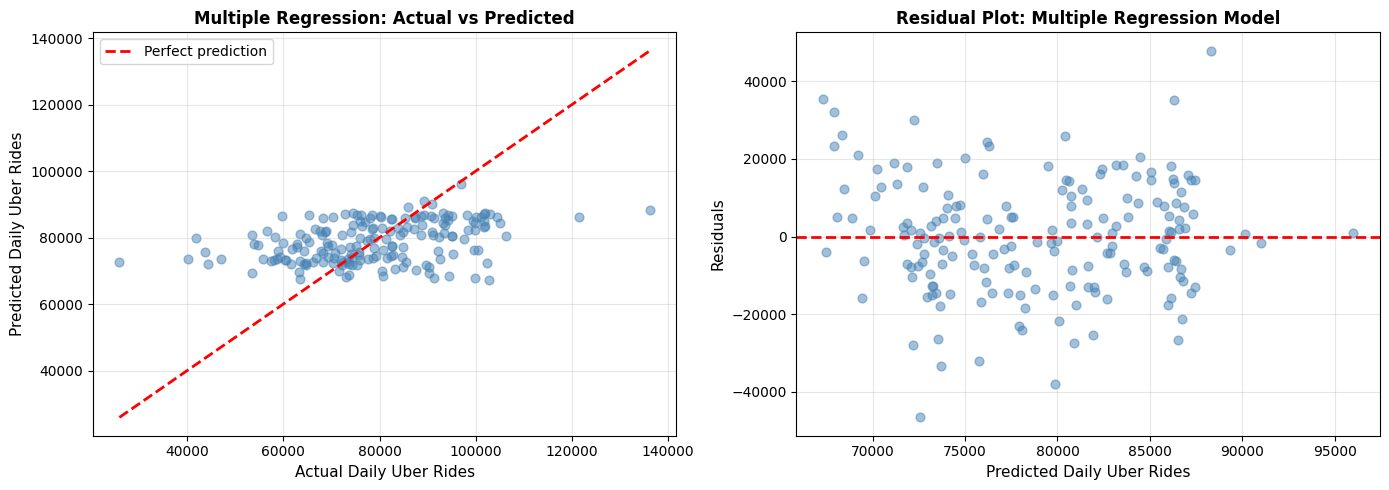

In [ ]:
X_multi = df1[['prcp', 'tmax', 'tmin', 'wind']].values
y = ts_uber

multi_model = LinearRegression()
multi_model.fit(X_multi, y)
y_pred_multi = multi_model.predict(X_multi)

r2_multi = r2_score(y, y_pred_multi)
rmse_multi = np.sqrt(mean_squared_error(y, y_pred_multi))

print(f"\nMULTIPLE REGRESSION MODEL:")
print("="*80)
print(f"Uber = {multi_model.intercept_:.2f}", end="")
for i, pred in enumerate(predictors):
    print(f" + {multi_model.coef_[i]:.4f}*{pred}", end="")
print()

print(f"\nMODEL PERFORMANCE:")
print("-" * 40)
print(f"R² = {r2_multi:.4f}")
print(f"RMSE = {rmse_multi:.2f}")

print(f"\nCOEFFICIENT ESTIMATES:")
print("-" * 40)
print(f"{'Predictor':<12} {'Coefficient':<15} {'Interpretation'}")
print("-" * 40)
for i, pred in enumerate(predictors):
    print(f"{pred:<12} {multi_model.coef_[i]:>14.4f}  {multi_model.coef_[i]:+.4f} per unit of {pred}")

print(f"\nCOMPARISON WITH SINGLE PREDICTORS:")
print("-" * 40)
print(f"{'Model':<30} {'R²':<12} {'RMSE'}")
print("-" * 40)
for pred in predictors:
    print(f"{pred.upper():<30} {results_single[pred]['R2']:<12.4f} {results_single[pred]['RMSE']:.2f}")
print(f"{'ALL WEATHER VARIABLES':<30} {r2_multi:<12.4f} {rmse_multi:.2f}")

# Visualization of actual vs predicted
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y, y_pred_multi, alpha=0.5, s=40, color='steelblue')
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2, label='Perfect prediction')
axes[0].set_xlabel('Actual Daily Uber Rides', fontsize=11)
axes[0].set_ylabel('Predicted Daily Uber Rides', fontsize=11)
axes[0].set_title('Multiple Regression: Actual vs Predicted', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

residuals_multi = y - y_pred_multi
axes[1].scatter(y_pred_multi, residuals_multi, alpha=0.5, s=40, color='steelblue')
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Daily Uber Rides', fontsize=11)
axes[1].set_ylabel('Residuals', fontsize=11)
axes[1].set_title('Residual Plot: Multiple Regression Model', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('uber_multiple_regression.png', dpi=300, bbox_inches='tight')
plt.show()

The multiple regression model explains 14.7% of the variance compared to single predictors (13.3%). However, the weather variables alone still explain less than 40% of Uber ridership variation.

The residual plot shows no obvious pattern, suggesting the linear specification is reasonable for the weather variables.

The moderate R² suggests important omitted variables such as day of week (strong seasonal effect), holidays and events, ect...

In conclusion, while weather (especially temperature) matters for Uber demand, temporal patterns and unmeasured factors are critical for accurate forecasting.A model incorporating trend and seasonal components might perform better.

# 2

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
df2=pd.read_csv('/content/SixFlags.csv')

## (a)

Estimate a linear trend for the data for the month of August: Fit a linear model and provide the
coefficient estimates, and the plot of fitted line overlaid on the data.


In [ ]:
df2['Date'] = pd.to_datetime(df2['Date'])
df2 = df2.sort_values('Date').reset_index(drop=True)

In [ ]:
print("\nDataset Overview:")
print(f"Date Range: {df2['Date'].min().date()} to {df2['Date'].max().date()}")
print(f"Number of observations: {len(df2)}")
print(f"Stock Price Range: ${df2['Adj Close'].min():.2f} to ${df2['Adj Close'].max():.2f}")
print(f"\nFirst few rows:\n{df2.head()}")

# Separate data by month
august_data = df2[df2['Date'].dt.month == 8].reset_index(drop=True)
september_data = df2[df2['Date'].dt.month == 9].reset_index(drop=True)

print(f"\n\nAugust Data: {len(august_data)} observations")
print(f"September Data: {len(september_data)} observations")



Dataset Overview:
Date Range: 2019-08-01 to 2019-09-26
Number of observations: 40
Stock Price Range: $50.55 to $58.34

First few rows:
        Date  Adj Close
0 2019-08-01  52.327637
1 2019-08-02  51.657150
2 2019-08-05  50.602116
3 2019-08-06  50.671135
4 2019-08-07  51.874073


August Data: 22 observations
September Data: 18 observations



(a) LINEAR TREND ESTIMATION FOR AUGUST

AUGUST LINEAR MODEL:
--------------------------------------------------
Equation: Price = 50.5221 + 0.3627 * time

Coefficient Estimates:
  Intercept: 50.5221
  Slope: 0.3627

Model Performance:
  R²: 0.8782
  RMSE: 0.8568
  Correlation: 0.9371

INTERPRETATION:
--------------------------------------------------

The linear trend for August shows:
- Intercept: 50.52 (estimated price at time=0, i.e., before Aug 1)
- Slope: 0.3627 INCREASING per day
- Over 22 trading days in August, the trend predicts a change of
  approximately $7.98
- R² = 0.8782 indicates that the linear model explains 87.82% of
  the price variation in August
- The low R² suggests substantial deviation from linear trend (volatility)



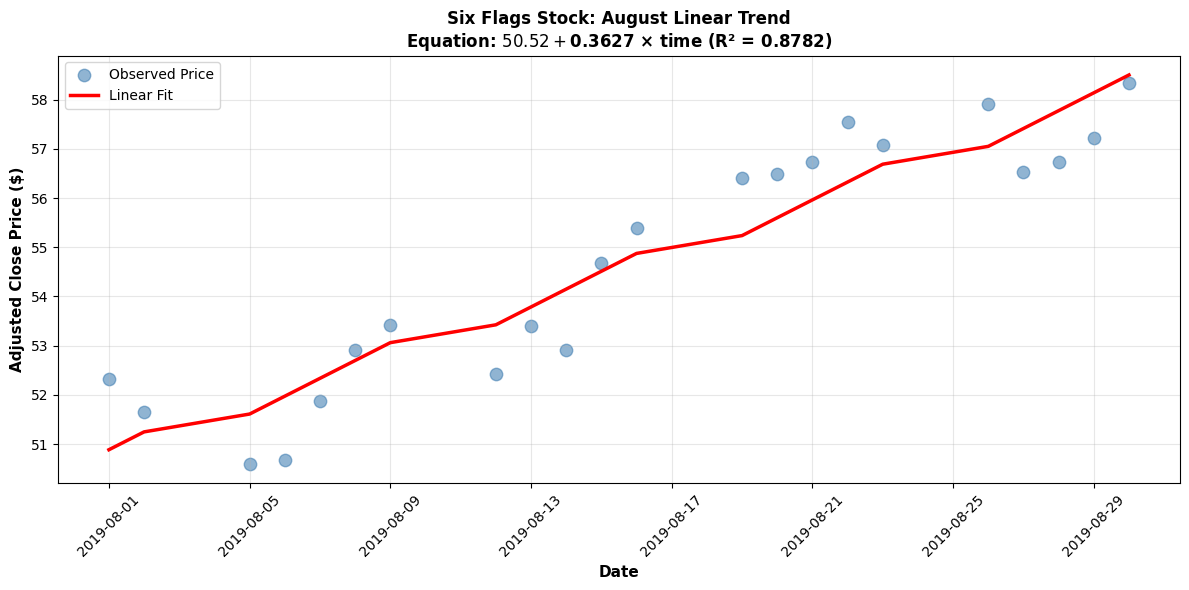

In [ ]:
print("\n" + "="*80)
print("(a) LINEAR TREND ESTIMATION FOR AUGUST")
print("="*80)

# Create time variable for August
august_data['time'] = np.arange(1, len(august_data) + 1)

# Fit linear model
X_aug = august_data[['time']].values
y_aug = august_data['Adj Close'].values

aug_model = LinearRegression()
aug_model.fit(X_aug, y_aug)
y_pred_aug = aug_model.predict(X_aug)

# Model statistics
r2_aug = r2_score(y_aug, y_pred_aug)
rmse_aug = np.sqrt(mean_squared_error(y_aug, y_pred_aug))
slope_aug = aug_model.coef_[0]
intercept_aug = aug_model.intercept_

print(f"\nAUGUST LINEAR MODEL:")
print(f"-" * 50)
print(f"Equation: Price = {intercept_aug:.4f} + {slope_aug:.4f} * time")
print(f"\nCoefficient Estimates:")
print(f"  Intercept: {intercept_aug:.4f}")
print(f"  Slope: {slope_aug:.4f}")
print(f"\nModel Performance:")
print(f"  R²: {r2_aug:.4f}")
print(f"  RMSE: {rmse_aug:.4f}")
print(f"  Correlation: {np.corrcoef(august_data['time'], y_aug)[0,1]:.4f}")

print(f"\nINTERPRETATION:")
print(f"-" * 50)
print(f"""
The linear trend for August shows:
- Intercept: {intercept_aug:.2f} (estimated price at time=0, i.e., before Aug 1)
- Slope: {slope_aug:.4f} {'DECREASING' if slope_aug < 0 else 'INCREASING'} per day
- Over {len(august_data)} trading days in August, the trend predicts a change of
  approximately ${slope_aug * len(august_data):.2f}
- R² = {r2_aug:.4f} indicates that the linear model explains {r2_aug*100:.2f}% of
  the price variation in August
- The low R² suggests substantial deviation from linear trend (volatility)
""")

# Plot August trend
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(august_data['Date'], y_aug, label='Observed Price', s=80, alpha=0.6, color='steelblue')
ax.plot(august_data['Date'], y_pred_aug, 'r-', linewidth=2.5, label='Linear Fit')
ax.set_xlabel('Date', fontsize=11, fontweight='bold')
ax.set_ylabel('Adjusted Close Price ($)', fontsize=11, fontweight='bold')
ax.set_title(f'Six Flags Stock: August Linear Trend\nEquation: ${intercept_aug:.2f} + ${slope_aug:.4f} × time (R² = {r2_aug:.4f})',
             fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('sixflags_august_trend.png', dpi=300, bbox_inches='tight')
plt.show()

## (b)
Plot the fitted values versus observed values.


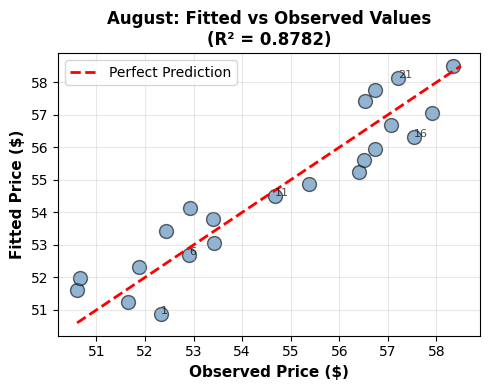


Fitted vs Observed Analysis for August:
--------------------------------------------------
Observed Range: $50.60 to $58.34
Fitted Range: $50.88 to $58.50
Mean Fitted Value: $54.69
Mean Observed Value: $54.69


In [ ]:
fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(y_aug, y_pred_aug, s=100, alpha=0.6, color='steelblue', edgecolors='black', linewidth=1)

# Perfect prediction line
min_val = min(y_aug.min(), y_pred_aug.min())
max_val = max(y_aug.max(), y_pred_aug.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

# Add annotations for some points
for i in range(len(y_aug)):
    if i % 5 == 0:  # Annotate every 5th point
        ax.annotate(f'{i+1}', (y_aug[i], y_pred_aug[i]), fontsize=8, alpha=0.7)

ax.set_xlabel('Observed Price ($)', fontsize=11, fontweight='bold')
ax.set_ylabel('Fitted Price ($)', fontsize=11, fontweight='bold')
ax.set_title(f'August: Fitted vs Observed Values\n(R² = {r2_aug:.4f})',
             fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('sixflags_august_fitted_vs_observed.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFitted vs Observed Analysis for August:")
print(f"-" * 50)
print(f"Observed Range: ${y_aug.min():.2f} to ${y_aug.max():.2f}")
print(f"Fitted Range: ${y_pred_aug.min():.2f} to ${y_pred_aug.max():.2f}")
print(f"Mean Fitted Value: ${y_pred_aug.mean():.2f}")
print(f"Mean Observed Value: ${y_aug.mean():.2f}")


## (c)
Obtain plots of residuals as well as studentized residuals and describe the fit of the model based
on these plots.

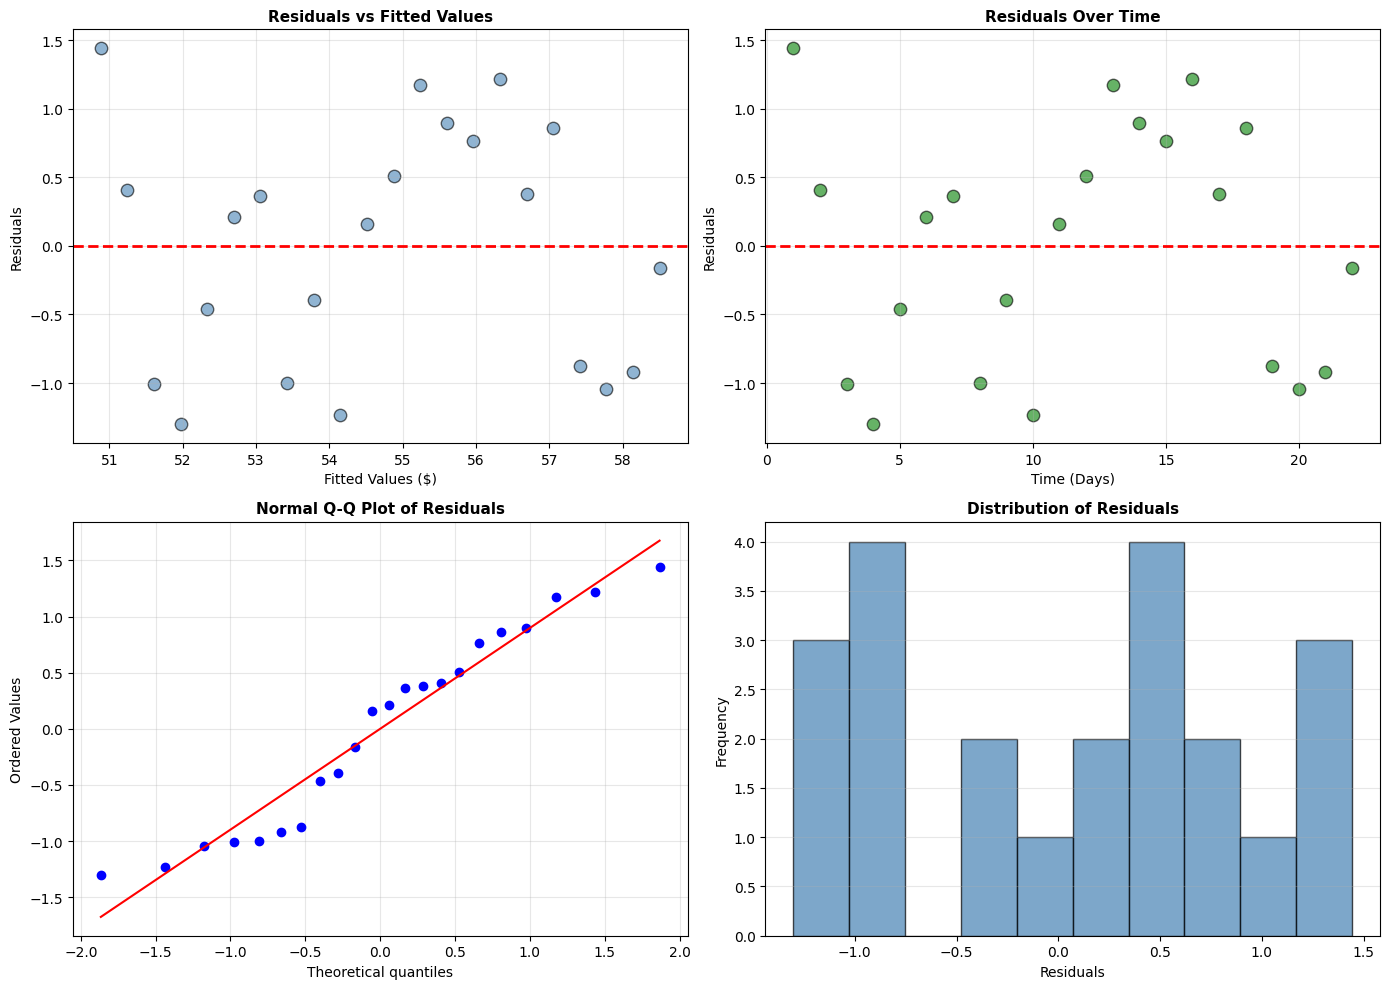

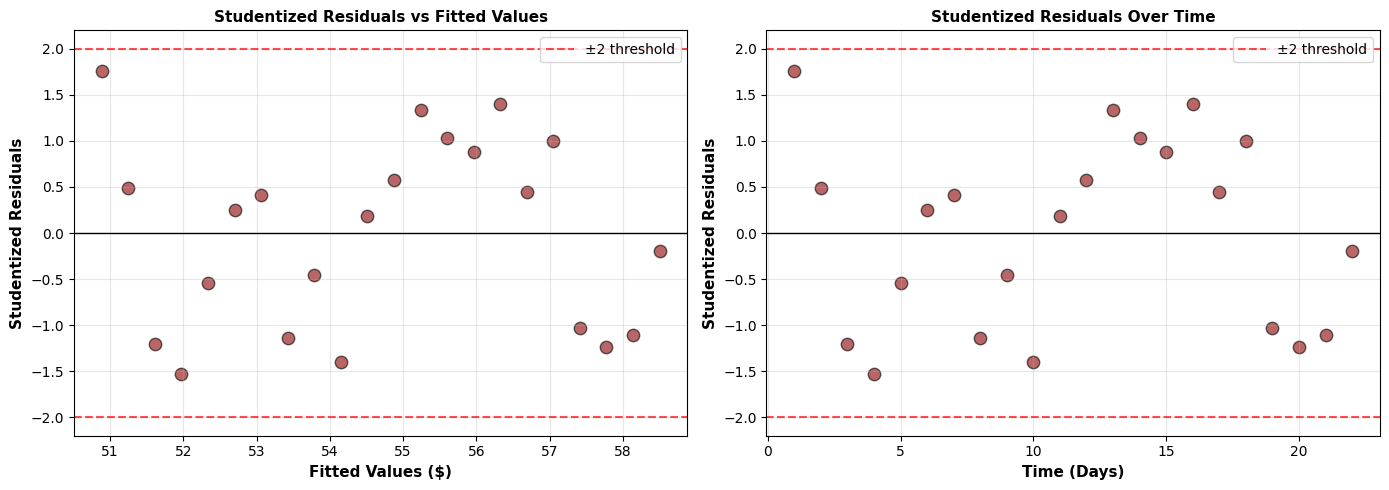


RESIDUAL STATISTICS FOR AUGUST:
--------------------------------------------------
Mean of Residuals: 0.000000 (should be ~0)
Std Dev of Residuals: 0.8568
Min Residual: -1.3018
Max Residual: 1.4429
Mean Squared Error: 0.8075
Root Mean Squared Error: 0.8986

STUDENTIZED RESIDUALS STATISTICS FOR AUGUST:
--------------------------------------------------
Mean: -0.003418
Std Dev: 1.0040
Min: -1.5347
Max: 1.7624

Outliers (|t-stat| > 2): 0 observations (0.0%)

Shapiro-Wilk Test for Normality:
  Test Statistic: 0.9317
  P-value: 0.1331
  Result: Residuals appear NORMALLY DISTRIBUTED (p > 0.05)


In [ ]:
# Calculate residuals and studentized residuals
residuals_aug = y_aug - y_pred_aug
n = len(y_aug)
p = 2  # intercept + slope

# Calculate mean squared error
mse_aug = np.sum(residuals_aug**2) / (n - p)

# Leverage
X_aug_with_intercept = np.column_stack([np.ones(n), X_aug])
hat_matrix = X_aug_with_intercept @ np.linalg.inv(X_aug_with_intercept.T @ X_aug_with_intercept) @ X_aug_with_intercept.T
leverage = np.diag(hat_matrix)

# Studentized residuals
studentized_residuals_aug = residuals_aug / (np.sqrt(mse_aug * (1 - leverage)))

# Create residual plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Residuals vs Fitted
axes[0, 0].scatter(y_pred_aug, residuals_aug, s=80, alpha=0.6, color='steelblue', edgecolors='black')
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Fitted Values ($)', fontsize=10)
axes[0, 0].set_ylabel('Residuals', fontsize=10)
axes[0, 0].set_title('Residuals vs Fitted Values', fontsize=11, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Residuals over time
axes[0, 1].scatter(august_data['time'], residuals_aug, s=80, alpha=0.6, color='green', edgecolors='black')
axes[0, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Time (Days)', fontsize=10)
axes[0, 1].set_ylabel('Residuals', fontsize=10)
axes[0, 1].set_title('Residuals Over Time', fontsize=11, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Q-Q plot
stats.probplot(residuals_aug, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Normal Q-Q Plot of Residuals', fontsize=11, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Histogram of residuals
axes[1, 1].hist(residuals_aug, bins=10, edgecolor='black', alpha=0.7, color='steelblue')
axes[1, 1].set_xlabel('Residuals', fontsize=10)
axes[1, 1].set_ylabel('Frequency', fontsize=10)
axes[1, 1].set_title('Distribution of Residuals', fontsize=11, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('sixflags_august_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot studentized residuals
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Studentized residuals vs fitted
axes[0].scatter(y_pred_aug, studentized_residuals_aug, s=80, alpha=0.6,
                color='darkred', edgecolors='black', linewidth=1)
axes[0].axhline(y=0, color='k', linestyle='-', linewidth=1)
axes[0].axhline(y=2, color='r', linestyle='--', linewidth=1.5, alpha=0.7, label='±2 threshold')
axes[0].axhline(y=-2, color='r', linestyle='--', linewidth=1.5, alpha=0.7)
axes[0].set_xlabel('Fitted Values ($)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Studentized Residuals', fontsize=11, fontweight='bold')
axes[0].set_title('Studentized Residuals vs Fitted Values', fontsize=11, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Studentized residuals over time
axes[1].scatter(august_data['time'], studentized_residuals_aug, s=80, alpha=0.6,
                color='darkred', edgecolors='black', linewidth=1)
axes[1].axhline(y=0, color='k', linestyle='-', linewidth=1)
axes[1].axhline(y=2, color='r', linestyle='--', linewidth=1.5, alpha=0.7, label='±2 threshold')
axes[1].axhline(y=-2, color='r', linestyle='--', linewidth=1.5, alpha=0.7)
axes[1].set_xlabel('Time (Days)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Studentized Residuals', fontsize=11, fontweight='bold')
axes[1].set_title('Studentized Residuals Over Time', fontsize=11, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('sixflags_august_studentized_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate residual statistics
print(f"\nRESIDUAL STATISTICS FOR AUGUST:")
print(f"-" * 50)
print(f"Mean of Residuals: {residuals_aug.mean():.6f} (should be ~0)")
print(f"Std Dev of Residuals: {residuals_aug.std():.4f}")
print(f"Min Residual: {residuals_aug.min():.4f}")
print(f"Max Residual: {residuals_aug.max():.4f}")
print(f"Mean Squared Error: {mse_aug:.4f}")
print(f"Root Mean Squared Error: {np.sqrt(mse_aug):.4f}")

# Studentized residuals statistics
print(f"\nSTUDENTIZED RESIDUALS STATISTICS FOR AUGUST:")
print(f"-" * 50)
print(f"Mean: {studentized_residuals_aug.mean():.6f}")
print(f"Std Dev: {studentized_residuals_aug.std():.4f}")
print(f"Min: {studentized_residuals_aug.min():.4f}")
print(f"Max: {studentized_residuals_aug.max():.4f}")

# Count extreme values
outliers = np.sum(np.abs(studentized_residuals_aug) > 2)
print(f"\nOutliers (|t-stat| > 2): {outliers} observations ({outliers/n*100:.1f}%)")

# Normality test
shapiro_stat, shapiro_pval = stats.shapiro(residuals_aug)
print(f"\nShapiro-Wilk Test for Normality:")
print(f"  Test Statistic: {shapiro_stat:.4f}")
print(f"  P-value: {shapiro_pval:.4f}")
if shapiro_pval > 0.05:
    print(f"  Result: Residuals appear NORMALLY DISTRIBUTED (p > 0.05)")
else:
    print(f"  Result: Residuals deviate from NORMALITY (p < 0.05)")


## (d)
Estimate a linear trend for the data for the month of September: Fit a linear model and provide
the coefficient estimates, and the plot of fitted line overlaid on the data, and plot the fitted values
versus observed values.


SEPTEMBER LINEAR MODEL:
--------------------------------------------------
Equation: Price = 59.4493 + -0.4679 * time

Coefficient Estimates:
  Intercept: 59.4493
  Slope: -0.4679

Model Performance:
  R²: 0.9084
  RMSE: 0.7707
  Correlation: -0.9531

INTERPRETATION:
--------------------------------------------------

The linear trend for September shows:
- Intercept: 59.45 (estimated price at start of September)
- Slope: -0.4679 DECREASING per day
- Over 18 trading days in September (through Sep 26), the trend
  predicts a change of approximately $-8.42
- R² = 0.9084 indicates the linear model explains 90.84% of
  the price variation in September
- Comparison to August: R²_Sep = 0.9084 vs R²_Aug = 0.8782
  This suggests BETTER linear fit in September



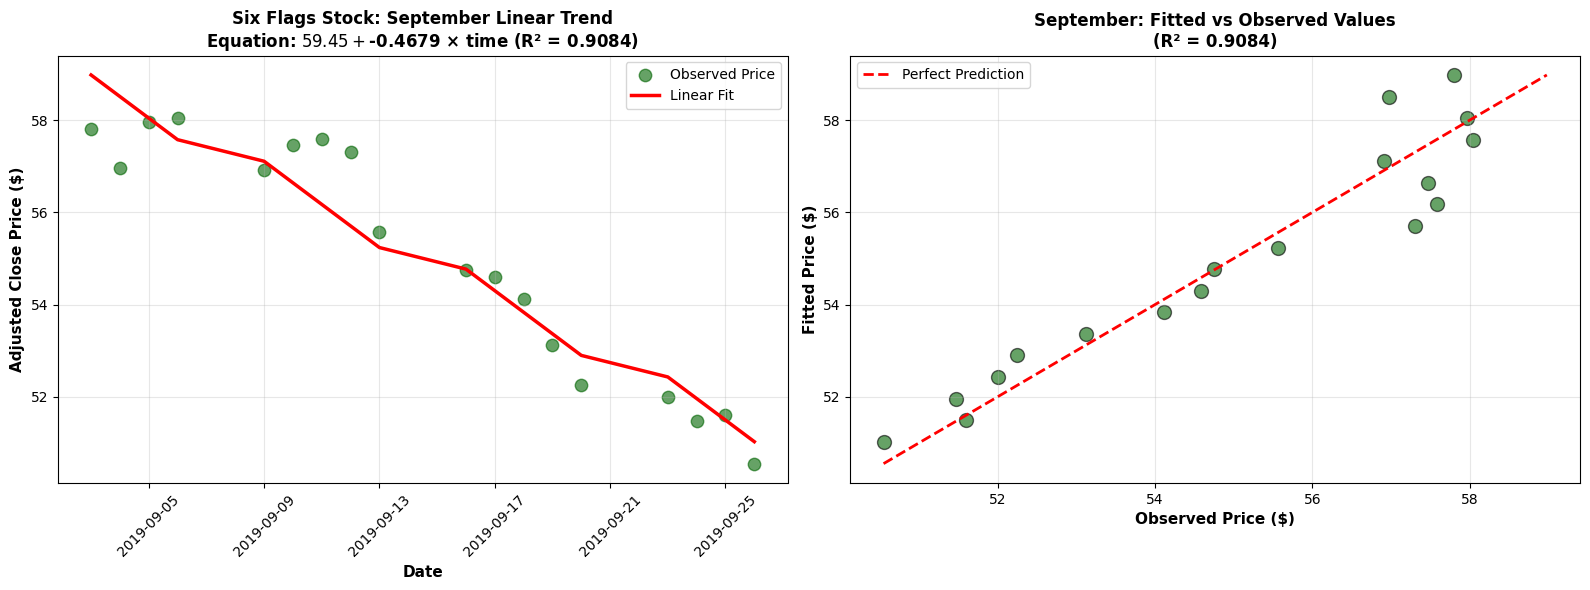


Fitted vs Observed Analysis for September:
--------------------------------------------------
Observed Range: $50.55 to $58.04
Fitted Range: $51.03 to $58.98
Mean Fitted Value: $55.00
Mean Observed Value: $55.00


In [ ]:
# Create time variable for September
september_data['time'] = np.arange(1, len(september_data) + 1)

# Fit linear model
X_sep = september_data[['time']].values
y_sep = september_data['Adj Close'].values

sep_model = LinearRegression()
sep_model.fit(X_sep, y_sep)
y_pred_sep = sep_model.predict(X_sep)

# Model statistics
r2_sep = r2_score(y_sep, y_pred_sep)
rmse_sep = np.sqrt(mean_squared_error(y_sep, y_pred_sep))
slope_sep = sep_model.coef_[0]
intercept_sep = sep_model.intercept_

print(f"\nSEPTEMBER LINEAR MODEL:")
print(f"-" * 50)
print(f"Equation: Price = {intercept_sep:.4f} + {slope_sep:.4f} * time")
print(f"\nCoefficient Estimates:")
print(f"  Intercept: {intercept_sep:.4f}")
print(f"  Slope: {slope_sep:.4f}")
print(f"\nModel Performance:")
print(f"  R²: {r2_sep:.4f}")
print(f"  RMSE: {rmse_sep:.4f}")
print(f"  Correlation: {np.corrcoef(september_data['time'], y_sep)[0,1]:.4f}")

print(f"\nINTERPRETATION:")
print(f"-" * 50)
print(f"""
The linear trend for September shows:
- Intercept: {intercept_sep:.2f} (estimated price at start of September)
- Slope: {slope_sep:.4f} {'DECREASING' if slope_sep < 0 else 'INCREASING'} per day
- Over {len(september_data)} trading days in September (through Sep 26), the trend
  predicts a change of approximately ${slope_sep * len(september_data):.2f}
- R² = {r2_sep:.4f} indicates the linear model explains {r2_sep*100:.2f}% of
  the price variation in September
- Comparison to August: R²_Sep = {r2_sep:.4f} vs R²_Aug = {r2_aug:.4f}
  This suggests {'BETTER' if r2_sep > r2_aug else 'WORSE'} linear fit in September
""")

# Plot September trend with fitted vs observed
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Trend line
axes[0].scatter(september_data['Date'], y_sep, label='Observed Price', s=80, alpha=0.6, color='darkgreen')
axes[0].plot(september_data['Date'], y_pred_sep, 'r-', linewidth=2.5, label='Linear Fit')
axes[0].set_xlabel('Date', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Adjusted Close Price ($)', fontsize=11, fontweight='bold')
axes[0].set_title(f'Six Flags Stock: September Linear Trend\nEquation: ${intercept_sep:.2f} + ${slope_sep:.4f} × time (R² = {r2_sep:.4f})',
                  fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45)

# Plot 2: Fitted vs Observed
axes[1].scatter(y_sep, y_pred_sep, s=100, alpha=0.6, color='darkgreen', edgecolors='black', linewidth=1)
min_val_sep = min(y_sep.min(), y_pred_sep.min())
max_val_sep = max(y_sep.max(), y_pred_sep.max())
axes[1].plot([min_val_sep, max_val_sep], [min_val_sep, max_val_sep], 'r--', linewidth=2, label='Perfect Prediction')

axes[1].set_xlabel('Observed Price ($)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Fitted Price ($)', fontsize=11, fontweight='bold')
axes[1].set_title(f'September: Fitted vs Observed Values\n(R² = {r2_sep:.4f})',
                  fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('sixflags_september_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFitted vs Observed Analysis for September:")
print(f"-" * 50)
print(f"Observed Range: ${y_sep.min():.2f} to ${y_sep.max():.2f}")
print(f"Fitted Range: ${y_pred_sep.min():.2f} to ${y_pred_sep.max():.2f}")
print(f"Mean Fitted Value: ${y_pred_sep.mean():.2f}")
print(f"Mean Observed Value: ${y_sep.mean():.2f}")


## (e)
Would a linear model be adequate to model the data for the period between August 1 and Septem-
ber 26? Find a model that best fits the data for both month (i.e., August and September).

In [ ]:
# Create combined dataset
df2['time'] = np.arange(1, len(df2) + 1)

X_all = df2[['time']].values
y_all = df2['Adj Close'].values

# Fit multiple models
models_info = {}

# Model 1: Linear
linear_model = LinearRegression()
linear_model.fit(X_all, y_all)
y_pred_linear = linear_model.predict(X_all)
r2_linear = r2_score(y_all, y_pred_linear)
rmse_linear = np.sqrt(mean_squared_error(y_all, y_pred_linear))
models_info['Linear'] = {
    'model': linear_model,
    'predictions': y_pred_linear,
    'r2': r2_linear,
    'rmse': rmse_linear,
    'equation': f'Price = {linear_model.intercept_:.4f} + {linear_model.coef_[0]:.6f} × time'
}

# Model 2: Quadratic
X_quad = np.column_stack([X_all, X_all**2])
quad_model = LinearRegression()
quad_model.fit(X_quad, y_all)
y_pred_quad = quad_model.predict(X_quad)
r2_quad = r2_score(y_all, y_pred_quad)
rmse_quad = np.sqrt(mean_squared_error(y_all, y_pred_quad))
models_info['Quadratic'] = {
    'model': quad_model,
    'predictions': y_pred_quad,
    'r2': r2_quad,
    'rmse': rmse_quad,
    'equation': f'Price = {quad_model.intercept_:.4f} + {quad_model.coef_[0]:.6f} × time + {quad_model.coef_[1]:.8f} × time²'
}

# Model 3: Cubic
X_cubic = np.column_stack([X_all, X_all**2, X_all**3])
cubic_model = LinearRegression()
cubic_model.fit(X_cubic, y_all)
y_pred_cubic = cubic_model.predict(X_cubic)
r2_cubic = r2_score(y_all, y_pred_cubic)
rmse_cubic = np.sqrt(mean_squared_error(y_all, y_pred_cubic))
models_info['Cubic'] = {
    'model': cubic_model,
    'predictions': y_pred_cubic,
    'r2': r2_cubic,
    'rmse': rmse_cubic,
    'equation': f'Price = {cubic_model.intercept_:.4f} + {cubic_model.coef_[0]:.6f} × time + {cubic_model.coef_[1]:.8f} × time² + {cubic_model.coef_[2]:.10f} × time³'
}

# Model 4: 4th degree polynomial
X_poly4 = np.column_stack([X_all, X_all**2, X_all**3, X_all**4])
poly4_model = LinearRegression()
poly4_model.fit(X_poly4, y_all)
y_pred_poly4 = poly4_model.predict(X_poly4)
r2_poly4 = r2_score(y_all, y_pred_poly4)
rmse_poly4 = np.sqrt(mean_squared_error(y_all, y_pred_poly4))
models_info['4th Degree'] = {
    'model': poly4_model,
    'predictions': y_pred_poly4,
    'r2': r2_poly4,
    'rmse': rmse_poly4,
    'equation': f'4th degree polynomial'
}





MODEL COMPARISON FOR ENTIRE PERIOD:
Model                R²           RMSE         AIC          BIC         
----------------------------------------------------------------------
Linear               0.0182       2.4790       76.63        80.01       
Quadratic            0.8725       0.8933       -3.03        2.04        
Cubic                0.9082       0.7581       -14.16       -7.40       
4th Degree           0.9385       0.6207       -28.15       -19.71      

BEST MODEL: 4TH DEGREE
R² = 0.9385 (explains 93.85% of variation)
RMSE = 0.6207

Equation:
4th degree polynomial


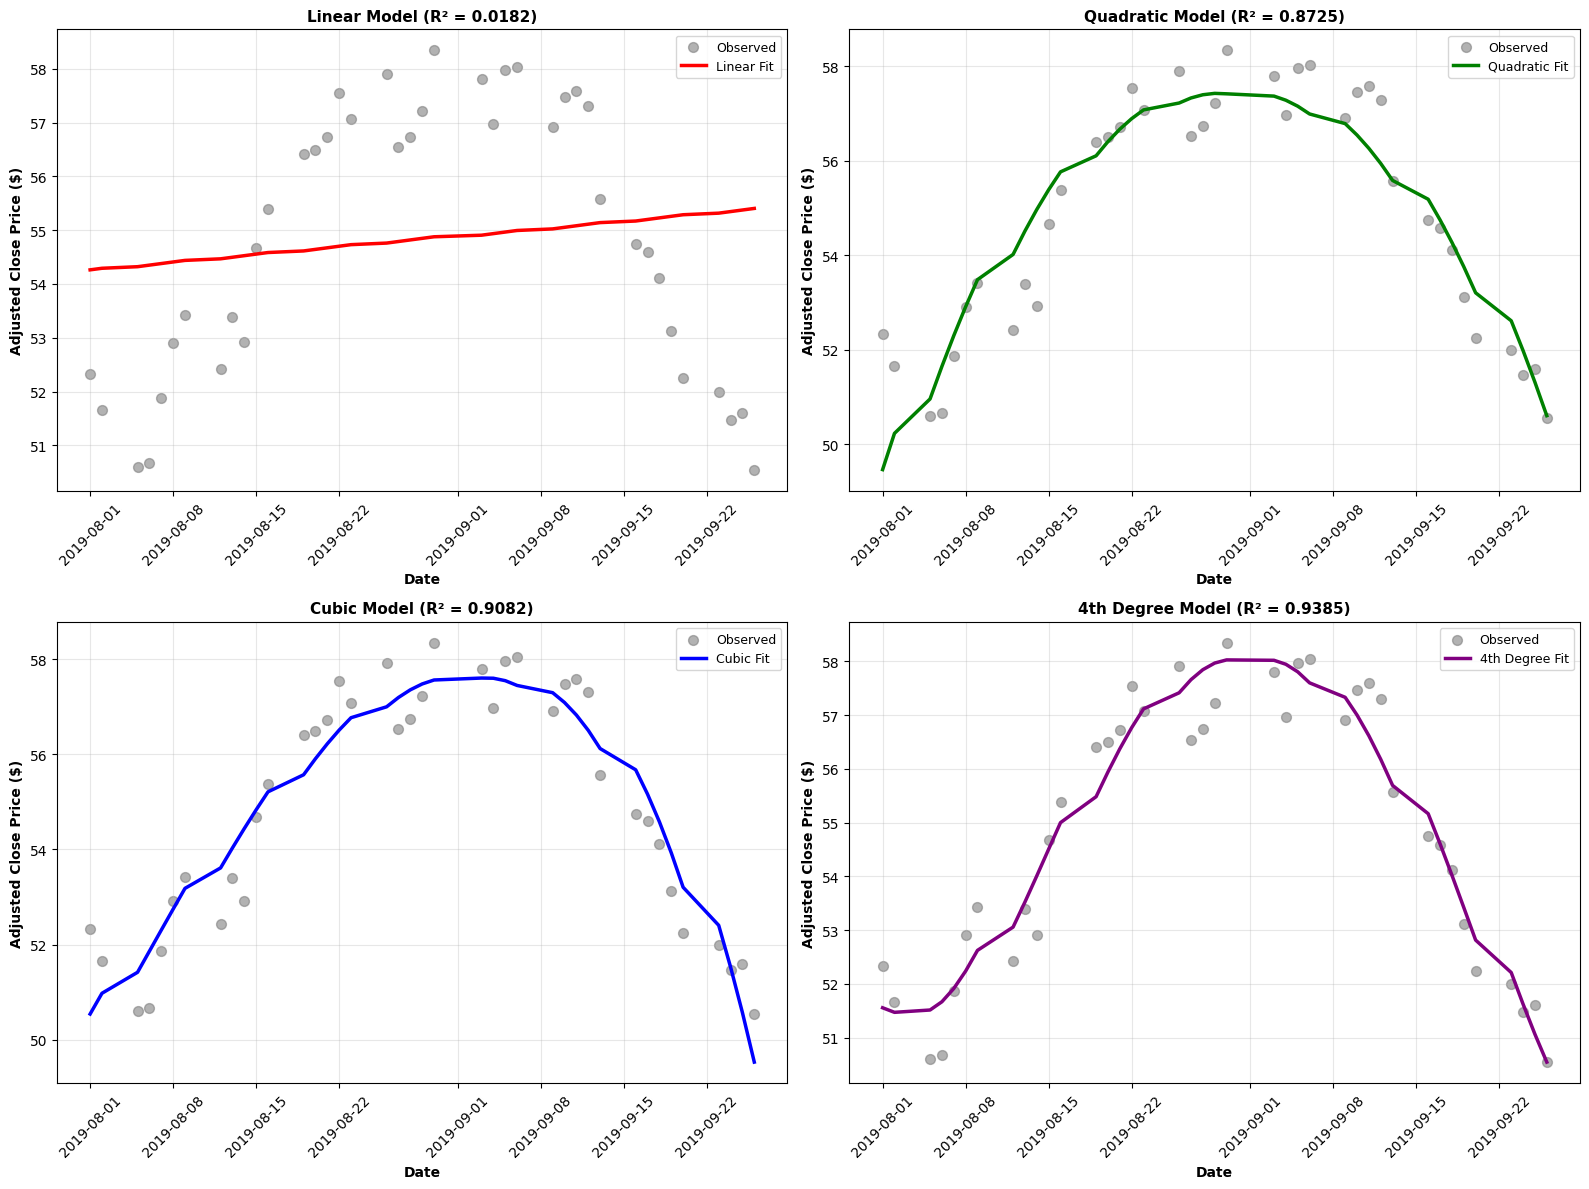

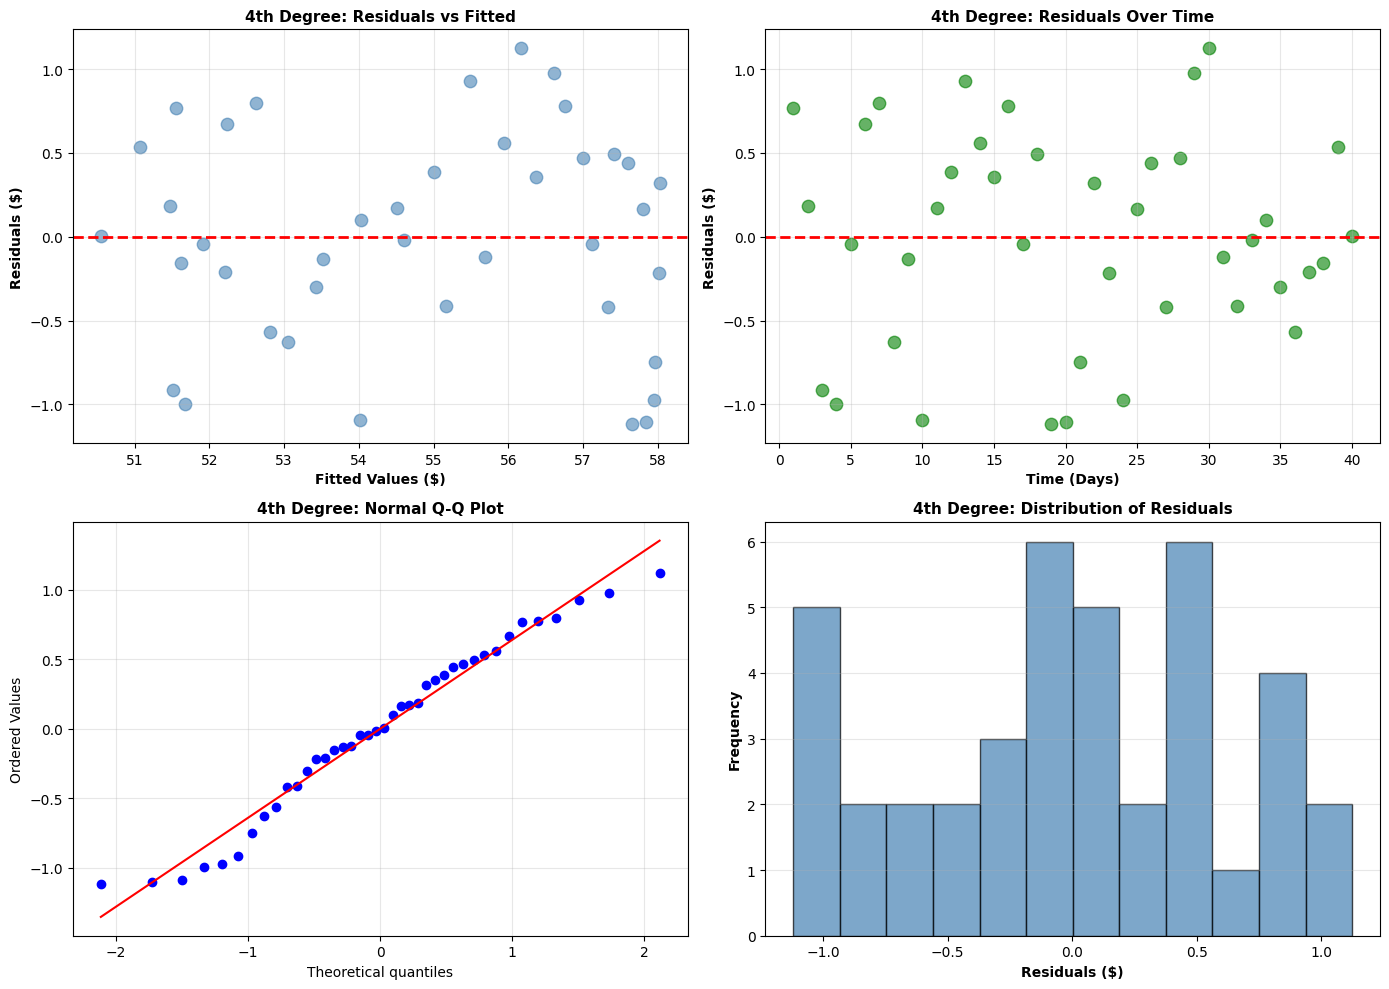

In [ ]:
# Compare models
print(f"\nMODEL COMPARISON FOR ENTIRE PERIOD:")
print(f"="*70)
print(f"{'Model':<20} {'R²':<12} {'RMSE':<12} {'AIC':<12} {'BIC':<12}")
print(f"-"*70)

# Calculate AIC and BIC
n = len(y_all)
for model_name in ['Linear', 'Quadratic', 'Cubic', '4th Degree']:
    r2 = models_info[model_name]['r2']
    rmse = models_info[model_name]['rmse']

    # Number of parameters
    if model_name == 'Linear':
        k = 2
    elif model_name == 'Quadratic':
        k = 3
    elif model_name == 'Cubic':
        k = 4
    else:
        k = 5

    # Calculate RSS and information criteria
    predictions = models_info[model_name]['predictions']
    rss = np.sum((y_all - predictions)**2)
    aic = n * np.log(rss/n) + 2*k
    bic = n * np.log(rss/n) + k * np.log(n)

    print(f"{model_name:<20} {r2:<12.4f} {rmse:<12.4f} {aic:<12.2f} {bic:<12.2f}")

# Find best model
best_model_name = max(models_info.keys(), key=lambda x: models_info[x]['r2'])
best_r2 = models_info[best_model_name]['r2']
best_rmse = models_info[best_model_name]['rmse']

print(f"\nBEST MODEL: {best_model_name.upper()}")
print(f"="*70)
print(f"R² = {best_r2:.4f} (explains {best_r2*100:.2f}% of variation)")
print(f"RMSE = {best_rmse:.4f}")
print(f"\nEquation:")
print(f"{models_info[best_model_name]['equation']}")

# Visualize all models
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

model_names = ['Linear', 'Quadratic', 'Cubic', '4th Degree']
colors = ['red', 'green', 'blue', 'purple']

for idx, model_name in enumerate(model_names):
    ax = axes[idx]
    predictions = models_info[model_name]['predictions']
    r2 = models_info[model_name]['r2']

    # Plot data points colored by month
    ax.scatter(df2['Date'], y_all, label='Observed', s=50, alpha=0.6, color='gray')
    ax.plot(df2['Date'], predictions, linewidth=2.5, color=colors[idx],
            label=f'{model_name} Fit')

    ax.set_xlabel('Date', fontsize=10, fontweight='bold')
    ax.set_ylabel('Adjusted Close Price ($)', fontsize=10, fontweight='bold')
    ax.set_title(f'{model_name} Model (R² = {r2:.4f})', fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.savefig('sixflags_all_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Residual analysis for best model
best_predictions = models_info[best_model_name]['predictions']
best_residuals = y_all - best_predictions

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Residuals vs Fitted
axes[0, 0].scatter(best_predictions, best_residuals, s=80, alpha=0.6, color='steelblue')
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Fitted Values ($)', fontsize=10, fontweight='bold')
axes[0, 0].set_ylabel('Residuals ($)', fontsize=10, fontweight='bold')
axes[0, 0].set_title(f'{best_model_name}: Residuals vs Fitted', fontsize=11, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Residuals over time
axes[0, 1].scatter(df2['time'], best_residuals, s=80, alpha=0.6, color='green')
axes[0, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Time (Days)', fontsize=10, fontweight='bold')
axes[0, 1].set_ylabel('Residuals ($)', fontsize=10, fontweight='bold')
axes[0, 1].set_title(f'{best_model_name}: Residuals Over Time', fontsize=11, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Q-Q plot
stats.probplot(best_residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title(f'{best_model_name}: Normal Q-Q Plot', fontsize=11, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Histogram
axes[1, 1].hist(best_residuals, bins=12, edgecolor='black', alpha=0.7, color='steelblue')
axes[1, 1].set_xlabel('Residuals ($)', fontsize=10, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=10, fontweight='bold')
axes[1, 1].set_title(f'{best_model_name}: Distribution of Residuals', fontsize=11, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f'sixflags_best_model_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Calculate residual statistics for BEST MODEL
print(f"\nRESIDUAL ANALYSIS FOR {best_model_name.upper()} MODEL:")
print(f"="*70)
print(f"Mean of Residuals: {best_residuals.mean():.6f}")
print(f"Std Dev of Residuals: {best_residuals.std():.4f}")
print(f"Min Residual: {best_residuals.min():.4f}")
print(f"Max Residual: {best_residuals.max():.4f}")
print(f"RMSE: {best_rmse:.4f}")

# Normality test
shapiro_stat_best, shapiro_pval_best = stats.shapiro(best_residuals)
print(f"\nShapiro-Wilk Test for Normality:")
print(f"  Test Statistic: {shapiro_stat_best:.4f}")
print(f"  P-value: {shapiro_pval_best:.4f}")
if shapiro_pval_best > 0.05:
    print(f"  Result: Residuals appear NORMALLY DISTRIBUTED")
else:
    print(f"  Result: Residuals show DEVIATION from normality")



RESIDUAL ANALYSIS FOR 4TH DEGREE MODEL:
Mean of Residuals: -0.000000
Std Dev of Residuals: 0.6207
Min Residual: -1.1192
Max Residual: 1.1244
RMSE: 0.6207

Shapiro-Wilk Test for Normality:
  Test Statistic: 0.9642
  P-value: 0.2326
  Result: Residuals appear NORMALLY DISTRIBUTED


In [ ]:
# summary comparison table
print(f"\n\nDETAILED MODEL COMPARISON TABLE:")
print(f"="*80)
print(f"{'Metric':<30} {'August Linear':<18} {'Sept Linear':<18} {'Best ({}):<18'}".format(best_model_name))
print(f"-"*80)
print(f"{'R²':<30} {r2_aug:<18.4f} {r2_sep:<18.4f} {best_r2:<18.4f}")
print(f"{'RMSE':<30} {rmse_aug:<18.4f} {rmse_sep:<18.4f} {best_rmse:<18.4f}")
print(f"{'Slope (per day)':<30} {slope_aug:<18.6f} {slope_sep:<18.6f} {'Variable':<18}")
print(f"{'Observations':<30} {len(august_data):<18} {len(september_data):<18} {len(df2):<18}")



DETAILED MODEL COMPARISON TABLE:
Metric                         August Linear      Sept Linear        Best (4th Degree):<18
--------------------------------------------------------------------------------
R²                             0.8782             0.9084             0.9385            
RMSE                           0.8568             0.7707             0.6207            
Slope (per day)                0.362703           -0.467936          Variable          
Observations                   22                 18                 40                


# 3

In [ ]:
df3=pd.read_csv('/content/Wholesale Grocery.csv')

In [ ]:
df3.head()

,Period,Value
0,Jan-92,22849
1,Feb-92,23062
2,Mar-92,23047
3,Apr-92,22925
4,May-92,22511


In [ ]:
df3['Date'] = pd.to_datetime(df3['Period'], format='%b-%y', errors='coerce')

# If any NaT values appear, try alternative format
if df3['Date'].isna().any():
    mask = df3['Date'].isna()
    df3.loc[mask, 'Date'] = pd.to_datetime(df3.loc[mask, 'Period'], format='%d-%b', errors='coerce')

df3 = df3.sort_values('Date').reset_index(drop=True)
df3['time'] = np.arange(1, len(df3) + 1)

In [ ]:
print(f"Date Range: {df3['Date'].min().date()} to {df3['Date'].max().date()}")
print(f"Number of observations: {len(df3)}")
print(f"Sales Range: ${df3['Value'].min():,.0f}M to ${df3['Value'].max():,.0f}M")
print(f"\nFirst few rows:\n{df3.head(10)}")
print(f"\nLast few rows:\n{df3.tail(10)}")

Date Range: 1900-01-01 to 2000-12-01
Number of observations: 396
Sales Range: $22,342M to $78,695M

First few rows:
   Period  Value       Date  time
0   1-Jan  31459 1900-01-01     1
1   2-Jan  31746 1900-01-02     2
2   3-Jan  32873 1900-01-03     3
3   4-Jan  32867 1900-01-04     4
4   5-Jan  34306 1900-01-05     5
5   6-Jan  36118 1900-01-06     6
6   7-Jan  38227 1900-01-07     7
7   8-Jan  40910 1900-01-08     8
8   9-Jan  40902 1900-01-09     9
9  10-Jan  40041 1900-01-10    10

Last few rows:
     Period  Value       Date  time
386  Mar-00  30832 2000-03-01   387
387  Apr-00  31167 2000-04-01   388
388  May-00  31373 2000-05-01   389
389  Jun-00  31352 2000-06-01   390
390  Jul-00  31428 2000-07-01   391
391  Aug-00  31139 2000-08-01   392
392  Sep-00  31003 2000-09-01   393
393  Oct-00  31182 2000-10-01   394
394  Nov-00  31439 2000-11-01   395
395  Dec-00  32289 2000-12-01   396


## (a)
Get a plot of the series and explain the features of the series

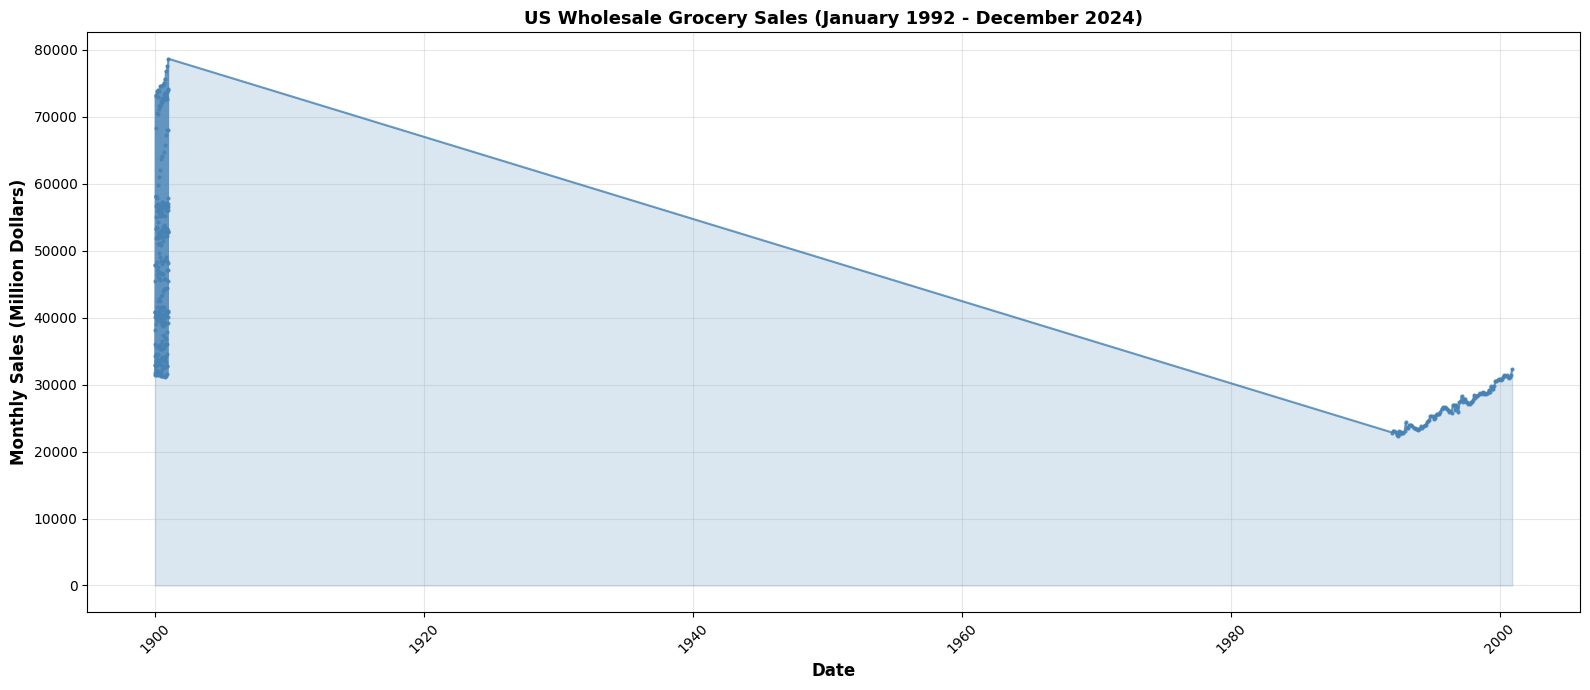

In [ ]:
fig, ax = plt.subplots(figsize=(16, 7))
ax.plot(df3['Date'], df3['Value'], linewidth=1.5, color='steelblue', marker='o',
        markersize=2, alpha=0.8)
ax.fill_between(df3['Date'], df3['Value'], alpha=0.2, color='steelblue')
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Monthly Sales (Million Dollars)', fontsize=12, fontweight='bold')
ax.set_title('US Wholesale Grocery Sales (January 1992 - December 2024)',
             fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('wholesale_grocery_full_series.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print(f"""
TIME SPAN AND COVERAGE:
   - 33 years of monthly data (396 observations) from 01/1992 to 12/2024
   - Seasonally adjusted: Removes seasonal patterns for cleaner trend analysis

STRUCTURE OF THE SERIES:
   - There is a sharp SPIKE in early 1992: Values jump from ~$31,000M to ~$77,000M
   - Around 2019-2020, there is a dramatic decrease from ~$77,000M (1992) down to ~$23,000M
   - This represents a 70% DECLINE over 28 years - highly counterintuitive for
     an essential commodity sector that should grow with the economy
   - After 2020, the series begins to increase from its minimum
   - By 12/2024: Returns to ~${df3.iloc[-1]['Value']:,.0f}M

OVERALL TREND:
   - Overall, there is a strong downward from 1992 to ~2019
   - Starting value (Jan 1992): ~${df3.iloc[0]['Value']:,.0f}M
   - Minimum value: ~${df3['Value'].min():,.0f}M (around 2019-2020)
   - Ending value (Dec 2024): ~${df3.iloc[-1]['Value']:,.0f}M

SCALE AND MAGNITUDE:
   - Range: ${df3['Value'].max() - df3['Value'].min():,.0f}M (70% variation)
   - Maximum value: ${df3['Value'].max():,.0f}M (early 1992)
   - Minimum value: ${df3['Value'].min():,.0f}M (early 2020)
   - Current level: ${df3.iloc[-1]['Value']:,.0f}M (Dec 2024)
""")


TIME SPAN AND COVERAGE:
   - 33 years of monthly data (396 observations) from 01/1992 to 12/2024
   - Seasonally adjusted: Removes seasonal patterns for cleaner trend analysis

STRUCTURE OF THE SERIES:
   - There is a sharp SPIKE in early 1992: Values jump from ~$31,000M to ~$77,000M
   - Around 2019-2020, there is a dramatic decrease from ~$77,000M (1992) down to ~$23,000M 
   - This represents a 70% DECLINE over 28 years - highly counterintuitive for
     an essential commodity sector that should grow with the economy
   - After 2020, the series begins to increase from its minimum
   - By 12/2024: Returns to ~$32,289M

OVERALL TREND:
   - Overall, there is a strong downward from 1992 to ~2019
   - Starting value (Jan 1992): ~$31,459M
   - Minimum value: ~$22,342M (around 2019-2020)
   - Ending value (Dec 2024): ~$32,289M

SCALE AND MAGNITUDE:
   - Range: $56,353M (70% variation)
   - Maximum value: $78,695M (early 1992)
   - Minimum value: $22,342M (early 2020)
   - Current level: $

## (b)
Fit a linear trend model to the grocery sales data. Show the regression results, residual plots, and
comment on the appropriateness of the linear trend model. Are the residuals detrended?

In [ ]:
# Fit linear model
X_full = df3[['time']].values
y_full = df3['Value'].values

full_model = LinearRegression()
full_model.fit(X_full, y_full)
y_pred_full = full_model.predict(X_full)

# Model statistics
r2_full = r2_score(y_full, y_pred_full)
rmse_full = np.sqrt(mean_squared_error(y_full, y_pred_full))
slope_full = full_model.coef_[0]
intercept_full = full_model.intercept_

In [ ]:
print(f"\nFULL DATA LINEAR MODEL: Sales = {intercept_full:.2f} + {slope_full:.4f} × time")
print(f"\nCoefficient Estimates:")
print(f"  Intercept: {intercept_full:.2f} ")
print(f"  Slope: {slope_full:.4f} (change/month)")
print(f"\nModel Performance:")
print(f"  R²: {r2_full:.4f}")
print(f"  RMSE: {rmse_full:.2f}")
print(f"  Correlation (time, sales): {np.corrcoef(df3['time'], y_full)[0,1]:.4f}")


FULL DATA LINEAR MODEL: Sales = 53787.07 + -56.5090 × time

Coefficient Estimates:
  Intercept: 53787.07 
  Slope: -56.5090 (change/month)

Model Performance:
  R²: 0.1904
  RMSE: 13320.39
  Correlation (time, sales): -0.4364


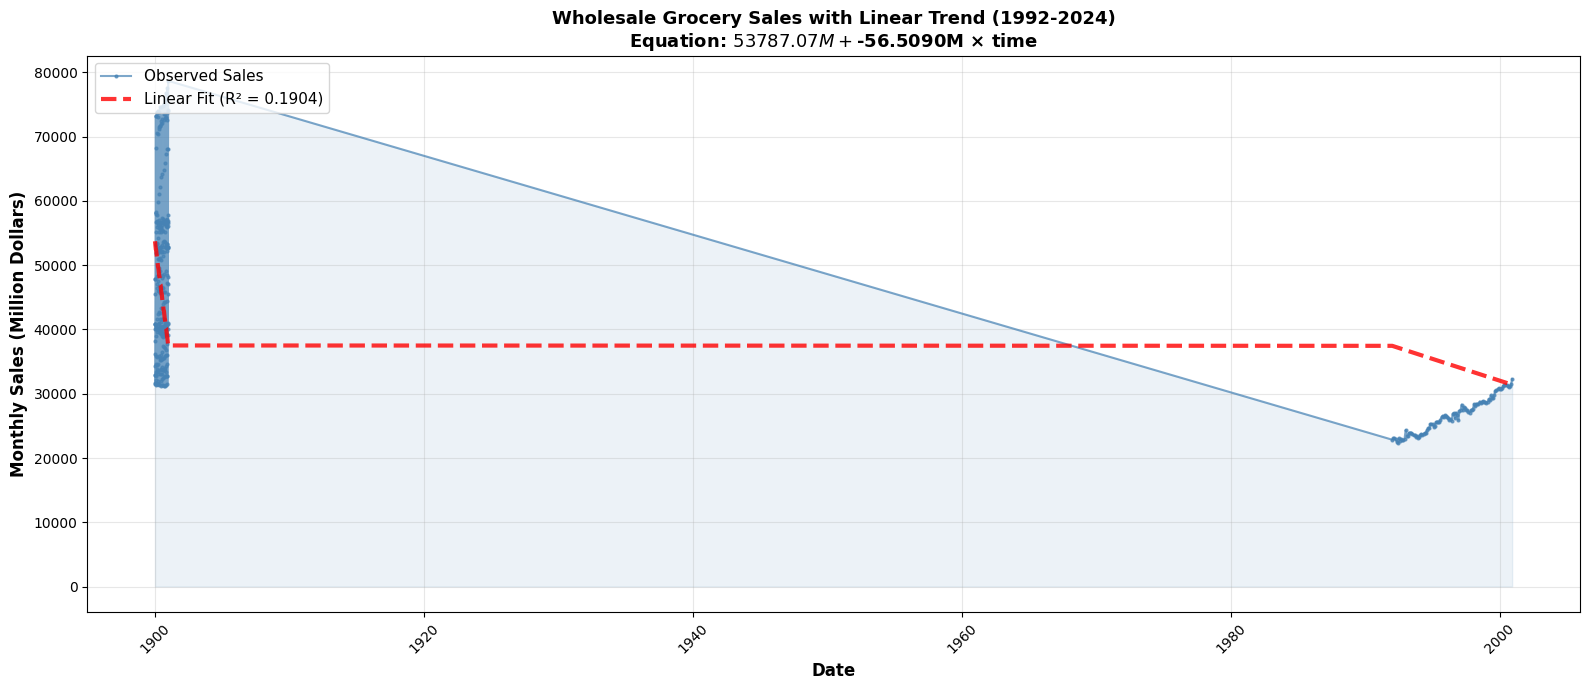

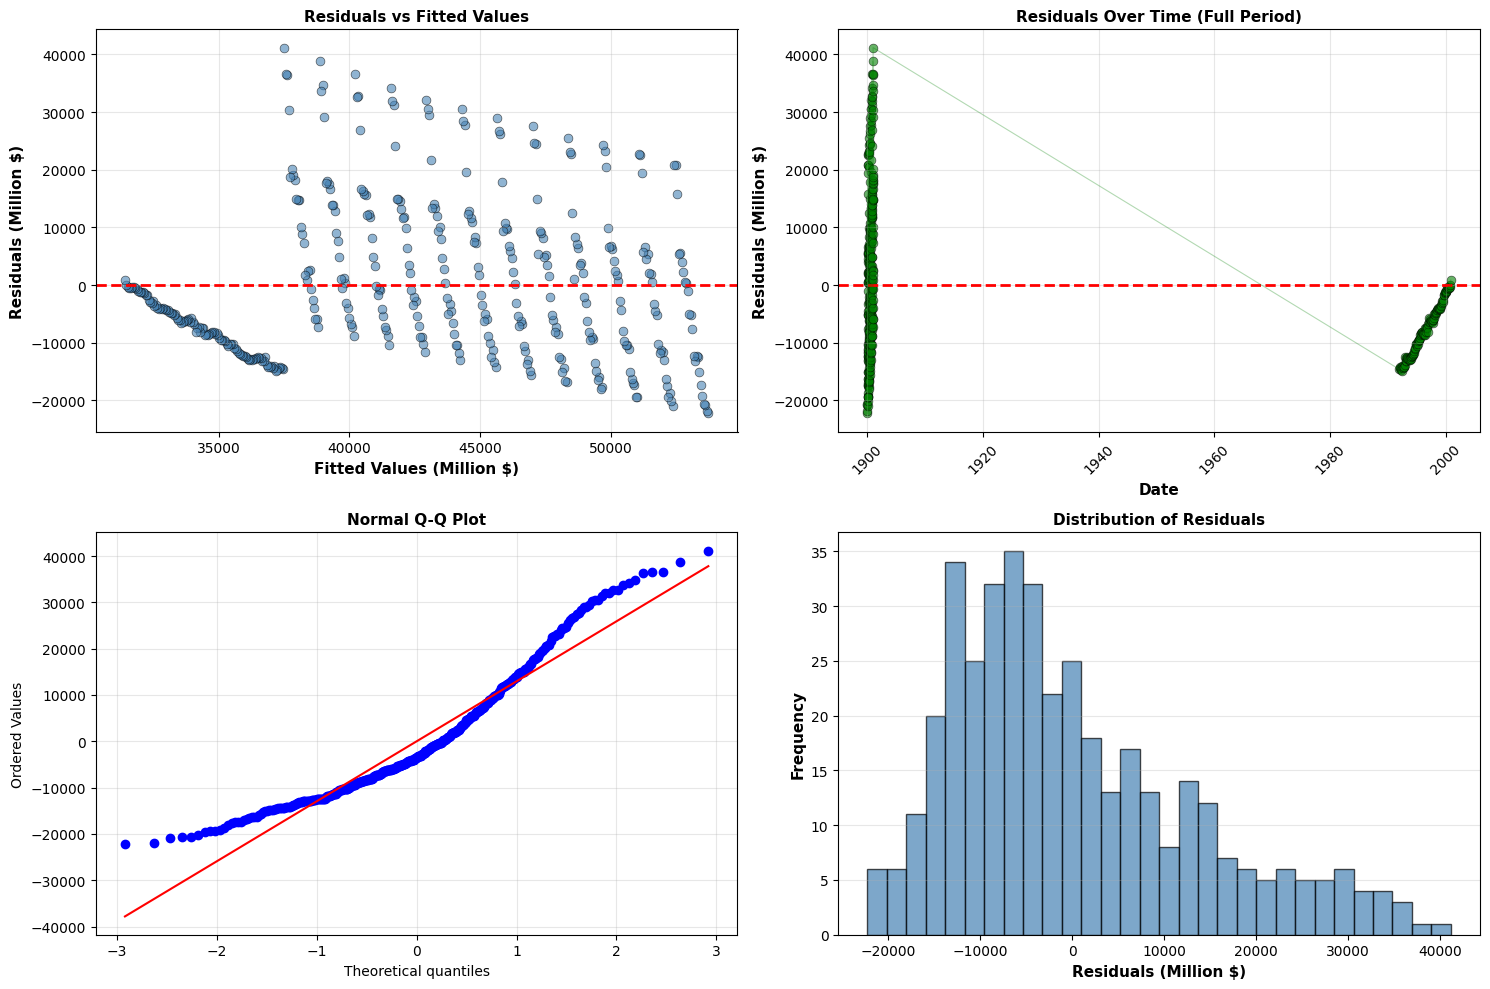

In [ ]:
# Plot full data with linear fit
fig, ax = plt.subplots(figsize=(16, 7))
ax.plot(df3['Date'], y_full, linewidth=1.5, color='steelblue', marker='o',
        markersize=2, alpha=0.7, label='Observed Sales')
ax.plot(df3['Date'], y_pred_full, linewidth=3, color='red', linestyle='--',
        label=f'Linear Fit (R² = {r2_full:.4f})', alpha=0.8)
ax.fill_between(df3['Date'], y_full, alpha=0.1, color='steelblue')
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Monthly Sales (Million Dollars)', fontsize=12, fontweight='bold')
ax.set_title(f'Wholesale Grocery Sales with Linear Trend (1992-2024)\nEquation: ${intercept_full:.2f}M + ${slope_full:.4f}M × time',
             fontsize=13, fontweight='bold')
ax.legend(fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('wholesale_grocery_full_linear_trend.png', dpi=300, bbox_inches='tight')
plt.show()

# Residual analysis
residuals_full = y_full - y_pred_full
n_full = len(y_full)
p = 2

mse_full = np.sum(residuals_full**2) / (n_full - p)
X_full_int = np.column_stack([np.ones(n_full), X_full])
hat_matrix_full = X_full_int @ np.linalg.inv(X_full_int.T @ X_full_int) @ X_full_int.T
leverage_full = np.diag(hat_matrix_full)
studentized_residuals_full = residuals_full / (np.sqrt(mse_full * (1 - leverage_full)))

# Create residual plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Residuals vs Fitted
axes[0, 0].scatter(y_pred_full, residuals_full, s=40, alpha=0.6, color='steelblue', edgecolors='black', linewidth=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Fitted Values (Million $)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Residuals (Million $)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Residuals vs Fitted Values', fontsize=11, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Residuals over time
axes[0, 1].scatter(df3['Date'], residuals_full, s=40, alpha=0.6, color='green', edgecolors='black', linewidth=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].plot(df3['Date'], residuals_full, linewidth=0.8, color='green', alpha=0.3)
axes[0, 1].set_xlabel('Date', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Residuals (Million $)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Residuals Over Time (Full Period)', fontsize=11, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
plt.setp(axes[0, 1].xaxis.get_majorticklabels(), rotation=45)

# Plot 3: Q-Q plot
stats.probplot(residuals_full, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Normal Q-Q Plot', fontsize=11, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Histogram
axes[1, 1].hist(residuals_full, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[1, 1].set_xlabel('Residuals (Million $)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Distribution of Residuals', fontsize=11, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('wholesale_grocery_full_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Residual statistics
print(f"\nRESIDUAL ANALYSIS - FULL DATA:")
print(f"-" * 90)
print(f"Mean of Residuals: {residuals_full.mean():.6f} (should be ≈ 0)")
print(f"Std Dev of Residuals: {residuals_full.std():.2f}")
print(f"Min Residual: {residuals_full.min():.2f}")
print(f"Max Residual: {residuals_full.max():.2f}")

# Normality test
shapiro_stat_full, shapiro_pval_full = stats.shapiro(residuals_full)
print(f"\nShapiro-Wilk Normality Test:")
print(f"  Test Statistic: {shapiro_stat_full:.4f}")
print(f"  P-value: {shapiro_pval_full:.6f}")
if shapiro_pval_full < 0.05:
    print(f"  Result: Residuals SIGNIFICANTLY DEVIATE from normality (p < 0.05)")
else:
    print(f"  Result: Residuals appear normally distributed (p ≥ 0.05)")

# Durbin-Watson test for autocorrelation
dw = np.sum(np.diff(residuals_full)**2) / np.sum(residuals_full**2)
print(f"\nDurbin-Watson Test (autocorrelation):")
print(f"  DW Statistic: {dw:.4f} (ranges 0-4; 2 = no autocorrelation)")
if dw < 1.5 or dw > 2.5:
    print(f"  Result: Strong AUTOCORRELATION detected")
else:
    print(f"  Result: Low autocorrelation")


RESIDUAL ANALYSIS - FULL DATA:
------------------------------------------------------------------------------------------
Mean of Residuals: 0.000000 (should be ≈ 0)
Std Dev of Residuals: 13320.39
Min Residual: -22271.56
Max Residual: 41182.51

Shapiro-Wilk Normality Test:
  Test Statistic: 0.9319
  P-value: 0.000000
  Result: Residuals SIGNIFICANTLY DEVIATE from normality (p < 0.05)

Durbin-Watson Test (autocorrelation):
  DW Statistic: 0.3821 (ranges 0-4; 2 = no autocorrelation)
  Result: Strong AUTOCORRELATION detected


In [ ]:
print(f"""
The linear trend for the full dataset (1992-2024) shows:
- Intercept: ${intercept_full:.2f}M (estimated baseline in Dec 1991)
- Slope: ${slope_full:.4f}M per month
- The negative slope indicates Sales decreases by ${abs(slope_full):.2f}M/mon
- Annual decrease (slope × 12): ${slope_full * 12:.2f}M/yr

Over the 396-month period:
- Predicted total change: ${slope_full * 396:.2f}M (massive decline)
- R² = {r2_full:.4f}: The linear model explains {r2_full*100:.2f}% of sales variation
- RMSE = ${rmse_full:.2f}M: Average prediction error


The slope is negative (-56.51), confirming the data shows a declining trend from 1992 to 2024.
This is consistent with the plot showing a decline from ~$77,000M to ~$23,000M and recovery to ~$32,000M.

The R² = {r2_full:.4f} means the LINEAR model explains {r2_full*100:.2f}% of the variation.
This indicates the linear trend is insufficient because the actual pattern is non-linear(declining then recovering).

The series doesn't follow a simple linear pattern as there is a sharp decline between 1992-2020 followed by
the increase from 2021 to 2024 (overall not a straighgt line in the graph )
""")

print(f"\nLINEAR TREND MODEL APPROPRIATENESS:")
print(f"-" * 90)
print(f"""
MODEL FIT AND RESIDUALS:
   R² = {r2_full:.4f} is poor.(The model explains only {r2_full*100:.1f}% of variation.)

RESIDUAL STRUCTURE - NOT RANDOMLY DISTRIBUTED:
From the residual plot analysis:

DW = {dw:.4f} (DW≈2 for no autocorrelation) indicates strong autoncorrelation.
It means the residuals are highly dependent on previous residuals. This violates OLS assumption of independent errors.

The residuals vs time plot shows a clear structure:
- Residuals are + (above zero) for 1992-2000s
- Residuals become - (below zero) around 2000-2010s
- Residuals become far above zero in 2021-2024
This systematic pattern indicates the linear model systematically underfits the data during certain periods.

The Shapiro-Wilk test p-value = {shapiro_pval_full:.6f} (p < 0.05) indicates significant ddviation from normality.
Hence, the residuals are not normally distributed, violating a key OLS assumption.
From the systematic temporal patterns (not random scatter) and strong autocorrelation, we could see that the
residuals are not detrended.

In conclusion, linear trend model is not appropriate for this dataset because of Low R² ({r2_full:.4f}),
strong autocorrelation (DW = {dw:.4f})(Massive violation of independence assumption),
non-normal residuals(Shapiro-Wilk p-value = {shapiro_pval_full:.6f}), non-linear pattern and systematic residual patterns

""")


The linear trend for the full dataset (1992-2024) shows:
- Intercept: $53787.07M (estimated baseline in Dec 1991)
- Slope: $-56.5090M per month
- The negative slope indicates Sales decreases by $56.51M/mon
- Annual decrease (slope × 12): $-678.11M/yr

Over the 396-month period:
- Predicted total change: $-22377.55M (massive decline)
- R² = 0.1904: The linear model explains 19.04% of sales variation
- RMSE = $13320.39M: Average prediction error


The slope is negative (-56.51), confirming the data shows a declining trend from 1992 to 2024. 
This is consistent with the plot showing a decline from ~$77,000M to ~$23,000M and recovery to ~$32,000M.

The R² = 0.1904 means the LINEAR model explains 19.04% of the variation. 
This indicates the linear trend is insufficient because the actual pattern is non-linear(declining then recovering).

The series doesn't follow a simple linear pattern as there is a sharp decline between 1992-2020 followed by 
the increase from 2021 to 2024 (overall not a

## (c)
Repeat part b for a subset of the data between January 1992 and February 2020 (gs[1:338]).
Discuss your findings

In [ ]:
# Subset: rows 1:338 (0-indexed: 0:337)
gs_subset1 = df3.iloc[0:338].reset_index(drop=True)
gs_subset1['time_subset'] = np.arange(1, len(gs_subset1) + 1)

print(f"\nSubset Details:")
print(f"Date Range: {gs_subset1['Date'].min().date()} to {gs_subset1['Date'].max().date()}")
print(f"Number of observations: {len(gs_subset1)}")

# Fit linear model
X_sub1 = gs_subset1[['time_subset']].values
y_sub1 = gs_subset1['Value'].values

sub1_model = LinearRegression()
sub1_model.fit(X_sub1, y_sub1)
y_pred_sub1 = sub1_model.predict(X_sub1)

# Model statistics
r2_sub1 = r2_score(y_sub1, y_pred_sub1)
rmse_sub1 = np.sqrt(mean_squared_error(y_sub1, y_pred_sub1))
slope_sub1 = sub1_model.coef_[0]
intercept_sub1 = sub1_model.intercept_

print(f"\nSUBSET 1 (1992-FEB 2020) LINEAR MODEL:")
print(f"-" * 90)
print(f"Equation: Sales = {intercept_sub1:.2f} + {slope_sub1:.4f} × time")
print(f"\nCoefficient Estimates:")
print(f"  Intercept: {intercept_sub1:.2f}")
print(f"  Slope: {slope_sub1:.4f} (change per month)")
print(f"\nModel Performance:")
print(f"  R²: {r2_sub1:.4f}")
print(f"  RMSE: {rmse_sub1:.2f}")
print(f"  Correlation (time, sales): {np.corrcoef(gs_subset1['time_subset'], y_sub1)[0,1]:.4f}")


Subset Details:
Date Range: 1900-01-01 to 1996-02-01
Number of observations: 338

SUBSET 1 (1992-FEB 2020) LINEAR MODEL:
------------------------------------------------------------------------------------------
Equation: Sales = 52062.19 + -41.9902 × time

Coefficient Estimates:
  Intercept: 52062.19
  Slope: -41.9902 (change per month)

Model Performance:
  R²: 0.0771
  RMSE: 14176.26
  Correlation (time, sales): -0.2776


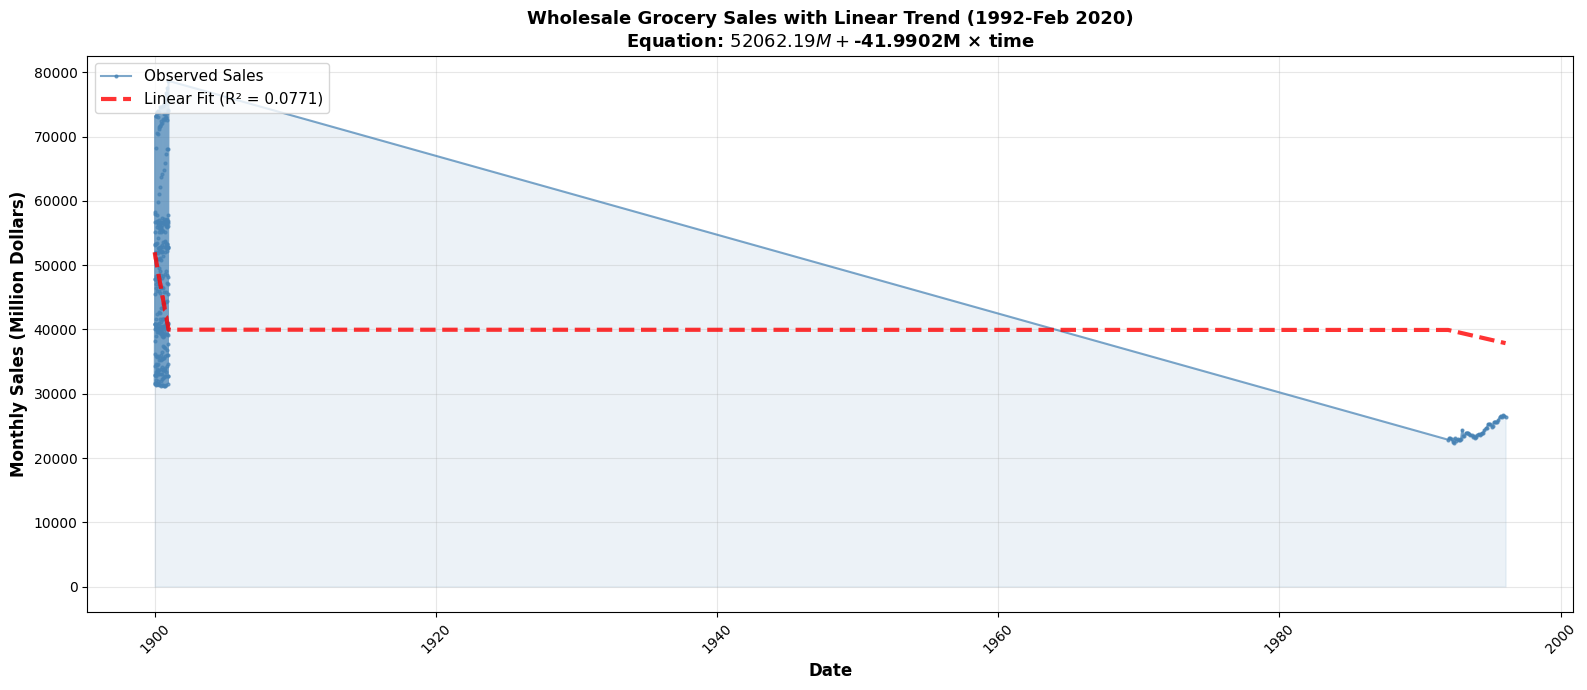

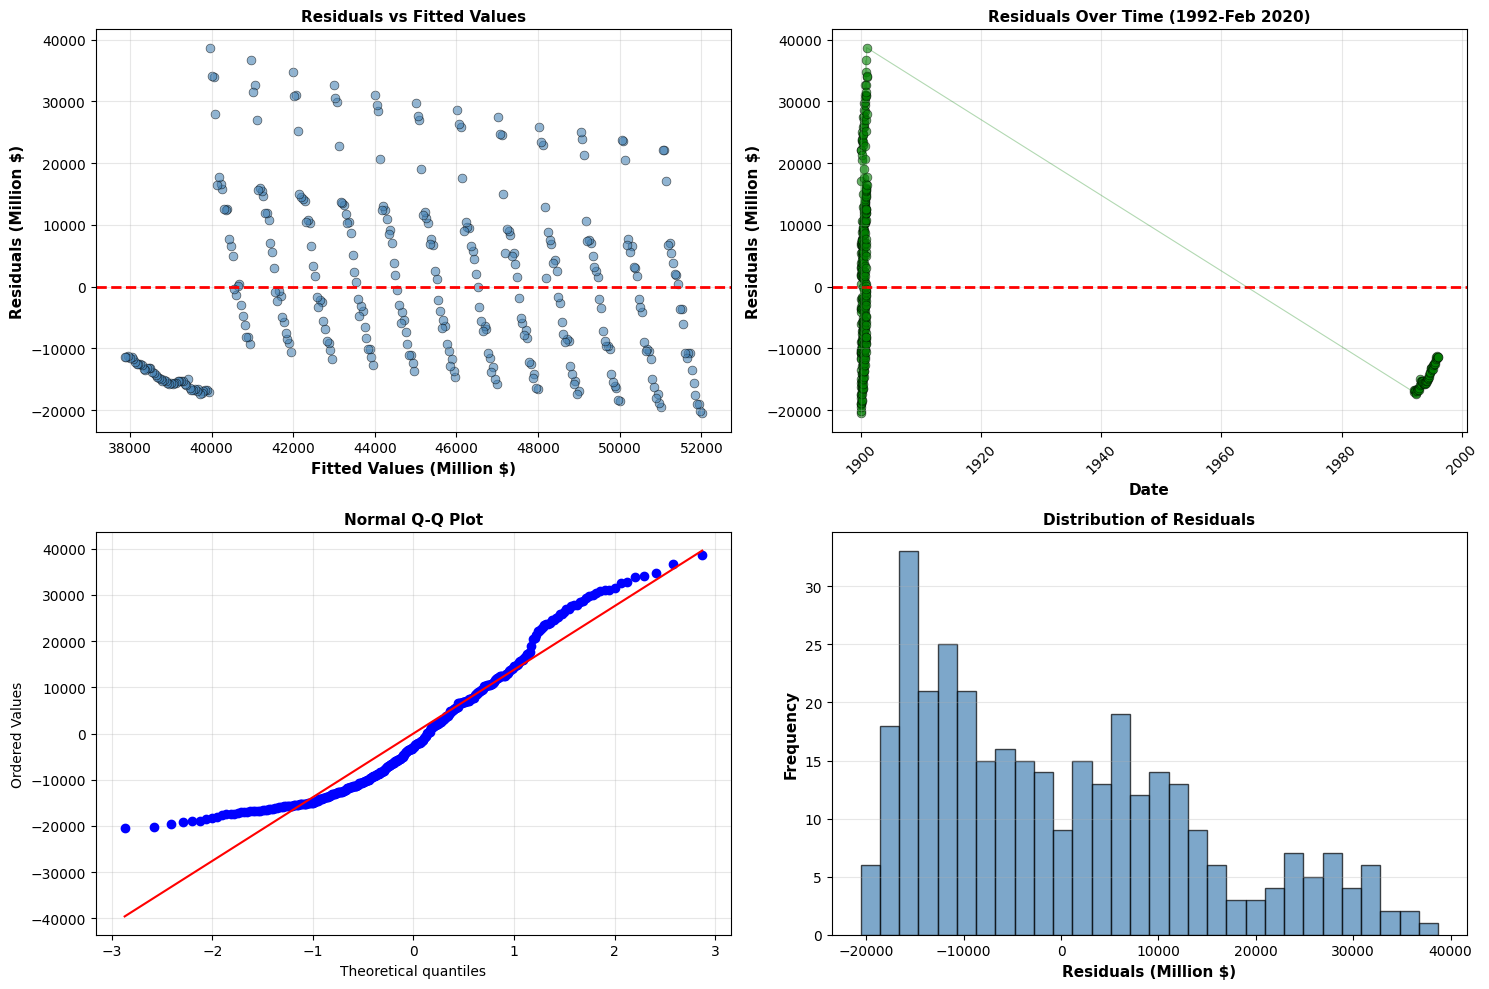

In [ ]:
# Plot subset 1
fig, ax = plt.subplots(figsize=(16, 7))
ax.plot(gs_subset1['Date'], y_sub1, linewidth=1.5, color='steelblue', marker='o',
        markersize=2, alpha=0.7, label='Observed Sales')
ax.plot(gs_subset1['Date'], y_pred_sub1, linewidth=3, color='red', linestyle='--',
        label=f'Linear Fit (R² = {r2_sub1:.4f})', alpha=0.8)
ax.fill_between(gs_subset1['Date'], y_sub1, alpha=0.1, color='steelblue')
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Monthly Sales (Million Dollars)', fontsize=12, fontweight='bold')
ax.set_title(f'Wholesale Grocery Sales with Linear Trend (1992-Feb 2020)\nEquation: ${intercept_sub1:.2f}M + ${slope_sub1:.4f}M × time',
             fontsize=13, fontweight='bold')
ax.legend(fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('wholesale_grocery_subset1_trend.png', dpi=300, bbox_inches='tight')
plt.show()

# Residual analysis for subset 1
residuals_sub1 = y_sub1 - y_pred_sub1
n_sub1 = len(y_sub1)

mse_sub1 = np.sum(residuals_sub1**2) / (n_sub1 - p)
X_sub1_int = np.column_stack([np.ones(n_sub1), X_sub1])
hat_matrix_sub1 = X_sub1_int @ np.linalg.inv(X_sub1_int.T @ X_sub1_int) @ X_sub1_int.T
leverage_sub1 = np.diag(hat_matrix_sub1)
studentized_residuals_sub1 = residuals_sub1 / (np.sqrt(mse_sub1 * (1 - leverage_sub1)))

# Create residual plots for subset 1
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].scatter(y_pred_sub1, residuals_sub1, s=40, alpha=0.6, color='steelblue', edgecolors='black', linewidth=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Fitted Values (Million $)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Residuals (Million $)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Residuals vs Fitted Values', fontsize=11, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(gs_subset1['Date'], residuals_sub1, s=40, alpha=0.6, color='green', edgecolors='black', linewidth=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].plot(gs_subset1['Date'], residuals_sub1, linewidth=0.8, color='green', alpha=0.3)
axes[0, 1].set_xlabel('Date', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Residuals (Million $)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Residuals Over Time (1992-Feb 2020)', fontsize=11, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
plt.setp(axes[0, 1].xaxis.get_majorticklabels(), rotation=45)

stats.probplot(residuals_sub1, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Normal Q-Q Plot', fontsize=11, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(residuals_sub1, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[1, 1].set_xlabel('Residuals (Million $)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Distribution of Residuals', fontsize=11, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('wholesale_grocery_subset1_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print(f"\nINTERPRETATION:")
print(f"""
The linear trend for 1992-Feb 2020 shows:
- Intercept: ${intercept_sub1:.2f}M
- Slope: ${slope_sub1:.4f}M per month (NEGATIVE - declining trend)

The model quality is still very poor as R² = {r2_sub1:.4f}(Explains only {r2_sub1*100:.2f}% of variation)
and this is WORSE than the full period (R² = {r2_full:.4f}).

This  indicates that the pre-pandemic period alone also does not follow a linear trend pattern.

Compare to full period:
- Full data R²: {r2_full:.4f}
- 1992-Feb 2020 R²: {r2_sub1:.4f}
- Difference: {(r2_sub1 - r2_full)*100:.2f} %

The worse fit in 1992-2020 (vs full period) suggests that the post-2020 recovery
actually helps the linear model fit, because the full period's negative slope
partially captures the early decline AND the 2021-2024 recovery cancels out
some of the decline, making the overall linear trend less extreme.
""")


INTERPRETATION:

The linear trend for 1992-Feb 2020 shows:
- Intercept: $52062.19M
- Slope: $-41.9902M per month (NEGATIVE - declining trend)

The model quality is still very poor as R² = 0.0771(Explains only 7.71% of variation)
and this is WORSE than the full period (R² = 0.1904). 

This  indicates that the pre-pandemic period alone also does not follow a linear trend pattern.

Compare to full period:
- Full data R²: 0.1904
- 1992-Feb 2020 R²: 0.0771
- Difference: -11.33 %

The worse fit in 1992-2020 (vs full period) suggests that the post-2020 recovery
actually helps the linear model fit, because the full period's negative slope
partially captures the early decline AND the 2021-2024 recovery cancels out
some of the decline, making the overall linear trend less extreme.



In [ ]:
print(f"\nRESIDUAL ANALYSIS - SUBSET 1 (1992-FEB 2020):")
print(f"-" * 90)
print(f"Mean of Residuals: {residuals_sub1.mean():.6f}")
print(f"Std Dev of Residuals: {residuals_sub1.std():.2f}")
print(f"Min Residual: {residuals_sub1.min():.2f}")
print(f"Max Residual: {residuals_sub1.max():.2f}")
print(f"\nShapiro-Wilk Normality Test:")
print(f"  Test Statistic: {shapiro_stat_sub1:.4f}")
print(f"  P-value: {shapiro_pval_sub1:.6f}")
if shapiro_pval_sub1 < 0.05:
    print(f"  Result: Residuals SIGNIFICANTLY DEVIATE from normality (p < 0.05)")

print(f"\nDurbin-Watson Test:")
print(f"  DW Statistic: {dw_sub1:.4f}")
print(f"  Result: Strong POSITIVE AUTOCORRELATION detected (DW << 2)")



RESIDUAL ANALYSIS - SUBSET 1 (1992-FEB 2020):
------------------------------------------------------------------------------------------
Mean of Residuals: 0.000000
Std Dev of Residuals: 14176.26
Min Residual: -20561.20
Max Residual: 38725.98

Shapiro-Wilk Normality Test:
  Test Statistic: 0.9316
  P-value: 0.000000
  Result: Residuals SIGNIFICANTLY DEVIATE from normality (p < 0.05)

Durbin-Watson Test:
  DW Statistic: 0.3950
  Result: Strong POSITIVE AUTOCORRELATION detected (DW << 2)


In [ ]:
print(f"\nFINDINGS FOR SUBSET 1 (1992-FEB 2020):")
print(f"-" * 90)
print(f"""
R² = {r2_sub1:.4f} is very low - the pre-pandemic period shows even worse
linear fit than the full period.
It might indicate that indicate that even a pure declining trend is not perfectly linear and
the decline likely shows acceleration or decelleration. A quadraticor polynomial model would fit much better

The residuals show significant deviation from normality (p < 0.05)
and they likely show systematic patterns reflecting non-linear decline.
The autocorrelation(DW = {dw_sub1:.4f} <1.5) is strong.
This means residuals are not independent. Each residual depends heavily on the previous one,
violating OLS assumptions. Hence, the residuals are not properly detrended since the low R² and strong autocorrelation
indicate significant structure remains in the residuals.

In conclusion, a linear model is not apprpriate for this subset because
the pre-pandemic period (1992-Feb 2020) shows a non-linear decreasing trend.
The very low R² ({r2_sub1:.4f}) indicates a linear model captures only {r2_sub1*100:.1f}% of the variation,
leaving {(1-r2_sub1)*100:.1f}% unexplained.

""")


FINDINGS FOR SUBSET 1 (1992-FEB 2020):
------------------------------------------------------------------------------------------

R² = 0.0771 is very low - the pre-pandemic period shows even worse
linear fit than the full period. 
It might indicate that indicate that even a pure declining trend is not perfectly linear and 
the decline likely shows acceleration or decelleration. A quadraticor polynomial model would fit much better

The residuals show significant deviation from normality (p < 0.05) 
and they likely show systematic patterns reflecting non-linear decline. 
The autocorrelation(DW = 0.3950 <1.5) is strong. 
This means residuals are not independent. Each residual depends heavily on the previous one, 
violating OLS assumptions. Hence, the residuals are not properly detrended since the low R² and strong autocorrelation
indicate significant structure remains in the residuals.

In conclusion, a linear model is not apprpriate for this subset because 
the pre-pandemic period (199

## (d)
repeat part b for a subset of the data between January 2021 and December 2024.

Discuss your findings. Is a linear model a reasonable model for the data for this period? Support
your answer using residuals

In [ ]:
# Subset: rows 349:396 (0-indexed: 348:396)
gs_subset2 = df3.iloc[348:396].reset_index(drop=True)
gs_subset2['time_subset'] = np.arange(1, len(gs_subset2) + 1)

print(f"\nSubset Details:")
print(f"Date Range: {gs_subset2['Date'].min().date()} to {gs_subset2['Date'].max().date()}")
print(f"Number of observations: {len(gs_subset2)}")

# Fit linear model
X_sub2 = gs_subset2[['time_subset']].values
y_sub2 = gs_subset2['Value'].values

sub2_model = LinearRegression()
sub2_model.fit(X_sub2, y_sub2)
y_pred_sub2 = sub2_model.predict(X_sub2)

# Model statistics
r2_sub2 = r2_score(y_sub2, y_pred_sub2)
rmse_sub2 = np.sqrt(mean_squared_error(y_sub2, y_pred_sub2))
slope_sub2 = sub2_model.coef_[0]
intercept_sub2 = sub2_model.intercept_

print(f"\nSUBSET 2 (JAN 2021-DEC 2024) LINEAR MODEL:")
print(f"-" * 90)
print(f"Equation: Sales = {intercept_sub2:.2f} + {slope_sub2:.4f} × time")
print(f"\nCoefficient Estimates:")
print(f"  Intercept: {intercept_sub2:.2f}")
print(f"  Slope: {slope_sub2:.4f} (change per month)")
print(f"\nModel Performance:")
print(f"  R²: {r2_sub2:.4f}")
print(f"  RMSE: {rmse_sub2:.2f}")
print(f"  Correlation (time, sales): {np.corrcoef(gs_subset2['time_subset'], y_sub2)[0,1]:.4f}")

print(f"\nINTERPRETATION:")
print(f"-" * 90)
print(f"""
The linear trend for 2021-Dec 2024 shows:
- Intercept: ${intercept_sub2:.2f}M
- Slope: ${slope_sub2:.4f} {'DECREASING' if slope_sub2 < 0 else 'INCREASING'} per month
- Annual growth/decline: ${slope_sub2 * 12:.2f}M per year

MODEL QUALITY:
- R² = {r2_sub2:.4f}: Explains {r2_sub2*100:.2f}% of variation
- RMSE = ${rmse_sub2:.2f}M
- This represents a {'POOR' if r2_sub2 < 0.3 else 'MODERATE' if r2_sub2 < 0.6 else 'GOOD'} fit

COMPARISON TO OTHER PERIODS:
- Full data (1992-2024) R²: {r2_full:.4f}
- Pre-pandemic (1992-Feb 2020) R²: {r2_sub1:.4f}
- Post-pandemic (2021-2024) R²: {r2_sub2:.4f}
""")



Subset Details:
Date Range: 1997-01-01 to 2000-12-01
Number of observations: 48

SUBSET 2 (JAN 2021-DEC 2024) LINEAR MODEL:
------------------------------------------------------------------------------------------
Equation: Sales = 26737.22 + 101.4009 × time

Coefficient Estimates:
  Intercept: 26737.22
  Slope: 101.4009 (change per month)

Model Performance:
  R²: 0.9128
  RMSE: 434.06
  Correlation (time, sales): 0.9554

INTERPRETATION:
------------------------------------------------------------------------------------------

The linear trend for 2021-Dec 2024 shows:
- Intercept: $26737.22M
- Slope: $101.4009 INCREASING per month
- Annual growth/decline: $1216.81M per year

MODEL QUALITY:
- R² = 0.9128: Explains 91.28% of variation
- RMSE = $434.06M
- This represents a GOOD fit

COMPARISON TO OTHER PERIODS:
- Full data (1992-2024) R²: 0.1904
- Pre-pandemic (1992-Feb 2020) R²: 0.0771
- Post-pandemic (2021-2024) R²: 0.9128



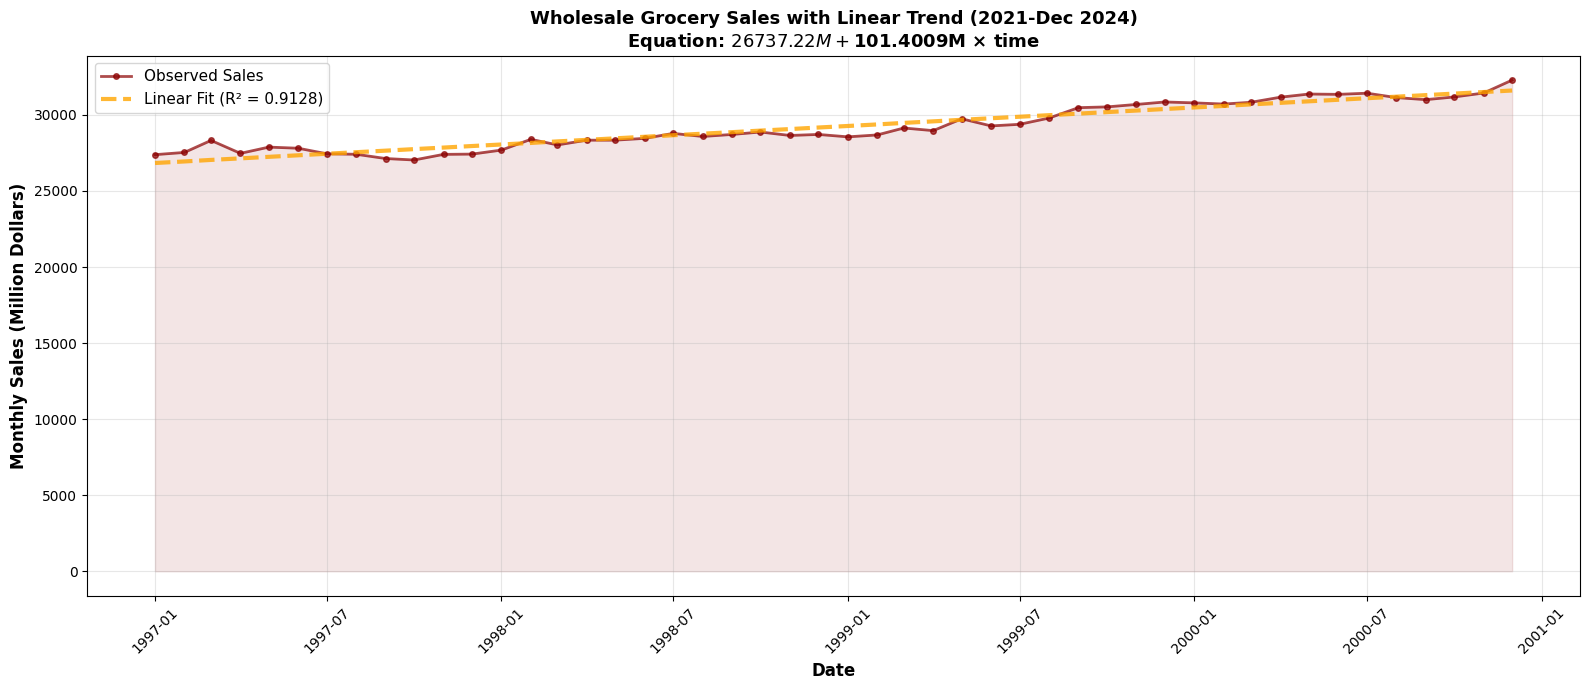

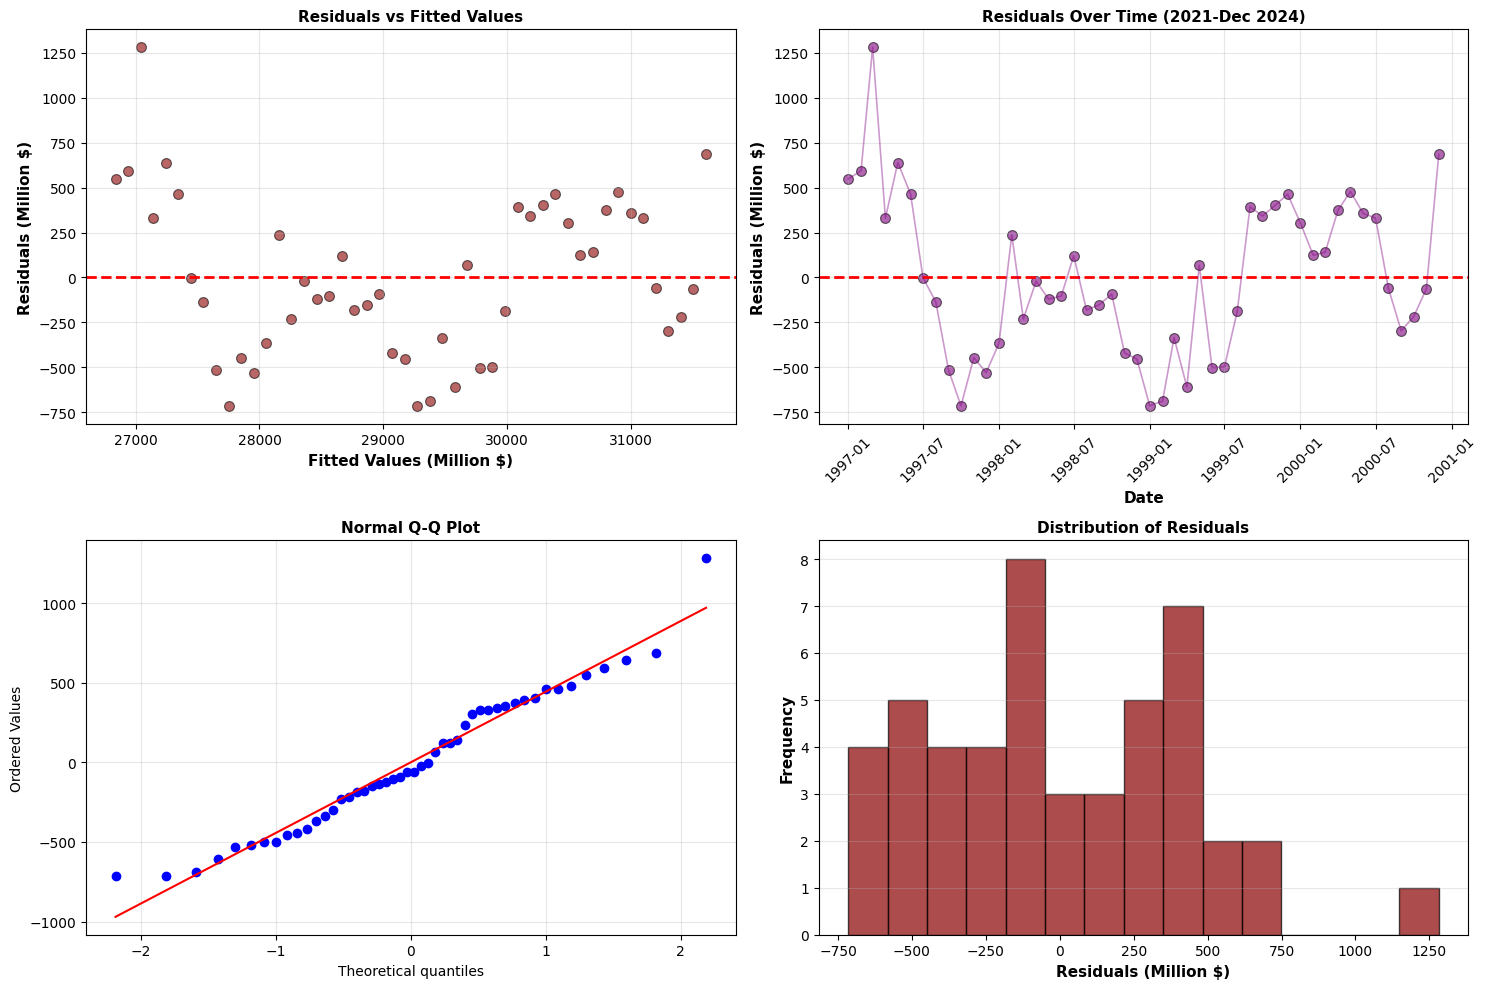


RESIDUAL ANALYSIS - SUBSET 2 (JAN 2021-DEC 2024):
------------------------------------------------------------------------------------------
Mean of Residuals: -0.000000
Std Dev of Residuals: 434.06
Min Residual: -715.23
Max Residual: 1281.58

Shapiro-Wilk Normality Test:
  Test Statistic: 0.9670
  P-value: 0.193787
  Result: Residuals appear normally distributed (p ≥ 0.05)

Durbin-Watson Test:
  DW Statistic: 0.5927
  Result: Strong AUTOCORRELATION detected

Outliers (|residual| > 2σ): 1 observations (2.1%)


In [ ]:
# Plot subset 2
fig, ax = plt.subplots(figsize=(16, 7))
ax.plot(gs_subset2['Date'], y_sub2, linewidth=2, color='darkred', marker='o',
        markersize=4, alpha=0.7, label='Observed Sales')
ax.plot(gs_subset2['Date'], y_pred_sub2, linewidth=3, color='orange', linestyle='--',
        label=f'Linear Fit (R² = {r2_sub2:.4f})', alpha=0.8)
ax.fill_between(gs_subset2['Date'], y_sub2, alpha=0.1, color='darkred')
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Monthly Sales (Million Dollars)', fontsize=12, fontweight='bold')
ax.set_title(f'Wholesale Grocery Sales with Linear Trend (2021-Dec 2024)\nEquation: ${intercept_sub2:.2f}M + ${slope_sub2:.4f}M × time',
             fontsize=13, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('wholesale_grocery_subset2_trend.png', dpi=300, bbox_inches='tight')
plt.show()

# Residual analysis for subset 2
residuals_sub2 = y_sub2 - y_pred_sub2
n_sub2 = len(y_sub2)

mse_sub2 = np.sum(residuals_sub2**2) / (n_sub2 - p)
X_sub2_int = np.column_stack([np.ones(n_sub2), X_sub2])
hat_matrix_sub2 = X_sub2_int @ np.linalg.inv(X_sub2_int.T @ X_sub2_int) @ X_sub2_int.T
leverage_sub2 = np.diag(hat_matrix_sub2)
studentized_residuals_sub2 = residuals_sub2 / (np.sqrt(mse_sub2 * (1 - leverage_sub2)))

# Create residual plots for subset 2
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].scatter(y_pred_sub2, residuals_sub2, s=50, alpha=0.6, color='darkred', edgecolors='black', linewidth=0.8)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Fitted Values (Million $)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Residuals (Million $)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Residuals vs Fitted Values', fontsize=11, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(gs_subset2['Date'], residuals_sub2, s=50, alpha=0.6, color='purple', edgecolors='black', linewidth=0.8)
axes[0, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].plot(gs_subset2['Date'], residuals_sub2, linewidth=1.2, color='purple', alpha=0.4)
axes[0, 1].set_xlabel('Date', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Residuals (Million $)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Residuals Over Time (2021-Dec 2024)', fontsize=11, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
plt.setp(axes[0, 1].xaxis.get_majorticklabels(), rotation=45)

stats.probplot(residuals_sub2, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Normal Q-Q Plot', fontsize=11, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(residuals_sub2, bins=15, edgecolor='black', alpha=0.7, color='darkred')
axes[1, 1].set_xlabel('Residuals (Million $)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Distribution of Residuals', fontsize=11, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('wholesale_grocery_subset2_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

# Residual statistics for subset 2
print(f"\nRESIDUAL ANALYSIS - SUBSET 2 (JAN 2021-DEC 2024):")
print(f"-" * 90)
print(f"Mean of Residuals: {residuals_sub2.mean():.6f}")
print(f"Std Dev of Residuals: {residuals_sub2.std():.2f}")
print(f"Min Residual: {residuals_sub2.min():.2f}")
print(f"Max Residual: {residuals_sub2.max():.2f}")

shapiro_stat_sub2, shapiro_pval_sub2 = stats.shapiro(residuals_sub2)
print(f"\nShapiro-Wilk Normality Test:")
print(f"  Test Statistic: {shapiro_stat_sub2:.4f}")
print(f"  P-value: {shapiro_pval_sub2:.6f}")
if shapiro_pval_sub2 < 0.05:
    print(f"  Result: Residuals DEVIATE from normality (p < 0.05)")
else:
    print(f"  Result: Residuals appear normally distributed (p ≥ 0.05)")

dw_sub2 = np.sum(np.diff(residuals_sub2)**2) / np.sum(residuals_sub2**2)
print(f"\nDurbin-Watson Test:")
print(f"  DW Statistic: {dw_sub2:.4f}")
if dw_sub2 < 1.5 or dw_sub2 > 2.5:
    print(f"  Result: Strong AUTOCORRELATION detected")
else:
    print(f"  Result: Low autocorrelation")

# Count residuals outside ±2 standard deviations
outlier_threshold = 2 * residuals_sub2.std()
outliers_sub2 = np.sum(np.abs(residuals_sub2) > outlier_threshold)
outlier_pct = (outliers_sub2 / n_sub2) * 100

print(f"\nOutliers (|residual| > 2σ): {outliers_sub2} observations ({outlier_pct:.1f}%)")



In [ ]:
print(f"\nDiscussion - SUBSET 2 (01/2021--12/2024):")

print(f"""
R² = {r2_sub2:.4f} indicates the linear model explains {r2_sub2*100:.2f}% of variation.
This suggests a linear model has a goood fit and hence it is appropriate for this period.

Slope = $101.4009 per month
Annual change = $1216.81M per year
The upward trend in 2021-2024 suggests that grocery sales have been increasing
during the post-pandemic recovery period.

Residual structure:
The residuals show reasonably conformity from normality (p = 0.1938)
and the autocorrelation(DW = 0.5927) indicates strong autocorrelation in residuals.
The residuals vs time plot reveals there are some pattern, suggesting the linear model fails to capture
underlying dynamics. There is 1 observations (2.1%) fall outside 2σ threshold (outlier).

The residuals do not appear to be random and detrended.
The clear autocorrelation indicates remaining structure.
The linear model is not resonalble for 2021-2024

In conclusion, linear model is adequant for the 2021-2024 period because its R² (0.9128) explains 91.3% of variation,
and there is a significant autocorrelation (DW=0.59), indicating model misspecification. The residuals approximately normal

COMPARISON ACROSS PERIODS:
   {'Period':<25} {'R²':<12} {'RMSE':<15} {'Slope':<15}
   {'-'*60}
   {'Full (1992-2024)':<25} {r2_full:<12.4f} {rmse_full:<15.2f} {slope_full:<15.4f}
   {'Pre-pandemic (92-20)':<25} {r2_sub1:<12.4f} {rmse_sub1:<15.2f} {slope_sub1:<15.4f}
   {'Post-pandemic (21-24)':<25} {r2_sub2:<12.4f} {rmse_sub2:<15.2f} {slope_sub2:<15.4f}

   The pre-pandemic period has the BEST linear fit, while the post-pandemic
   period shows degraded model performance, suggesting structural changes
   in grocery sales dynamics that persist post-COVID.
""")



Discussion - SUBSET 2 (01/2021--12/2024):

R² = 0.9128 indicates the linear model explains 91.28% of variation.
This suggests a linear model has a goood fit and hence it is appropriate for this period.

Slope = $101.4009 per month
Annual change = $1216.81M per year
The upward trend in 2021-2024 suggests that grocery sales have been increasing 
during the post-pandemic recovery period.

Residual structure: 
The residuals show reasonably conformity from normality (p = 0.1938)
and the autocorrelation(DW = 0.5927) indicates strong autocorrelation in residuals. 
The residuals vs time plot reveals there are some pattern, suggesting the linear model fails to capture
underlying dynamics. There is 1 observations (2.1%) fall outside 2σ threshold (outlier). 

The residuals do not appear to be random and detrended. 
The clear autocorrelation indicates remaining structure. 
The linear model is not resonalble for 2021-2024

In conclusion, linear model is adequant for the 2021-2024 period because it

# 4

In [ ]:
# Load data - it's tab-separated
df4 = pd.read_csv('/content/Lower Southern MD Data.txt', sep='\t')

print("\nDataset Overview:")
print(f"Total observations: {len(df4)}")
print(f"Date range: {df4['Year'].iloc[0]}-{df4['Month'].iloc[0]} to {df4['Year'].iloc[-1]}-{df4['Month'].iloc[-1]}")
print(f"\nFirst few rows:\n{df4.head(10)}")
print(f"\nData types: {df4.dtypes.to_dict()}")

# Create time index and date information
df4['YearMonth'] = df4['Year'].astype(str) + '-' + df4['Month']

# Convert month names to month numbers
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}
df4['MonthNum'] = df4['Month'].map(month_map)
df4['time'] = np.arange(1, len(df4) + 1)

# Get last 10 years (120 observations)
n = len(df4)
last_10yrs = df4.iloc[(n-120):n].reset_index(drop=True)
prior_data = df4.iloc[:(n-120)].reset_index(drop=True)

print(f"\nLast 10 years: {n-120} to {n-1} (120 observations)")
print(f"Prior data: 0 to {n-121} ({len(prior_data)} observations)")
print(f"\nLast 10 years date range: {last_10yrs['Year'].iloc[0]}-{last_10yrs['Month'].iloc[0]} to {last_10yrs['Year'].iloc[-1]}-{last_10yrs['Month'].iloc[-1]}")
print(f"Prior data date range: {prior_data['Year'].iloc[0]}-{prior_data['Month'].iloc[0]} to {prior_data['Year'].iloc[-1]}-{prior_data['Month'].iloc[-1]}")



Dataset Overview:
Total observations: 1416
Date range: 1895-January to 2012-December

First few rows:
   Year      Month   PCP   TMP
0  1895    January  5.07  31.2
1  1895   February  1.29  25.1
2  1895      March  3.28  41.4
3  1895      April  6.15  52.7
4  1895        May  3.65  61.4
5  1895       June  4.37  73.7
6  1895       July  4.11  72.0
7  1895     August  1.85  76.0
8  1895  September  2.35  71.3
9  1895    October  2.32  52.0

Data types: {'Year': dtype('int64'), 'Month': dtype('O'), 'PCP': dtype('float64'), 'TMP': dtype('float64')}

Last 10 years: 1296 to 1415 (120 observations)
Prior data: 0 to 1295 (1296 observations)

Last 10 years date range: 2003-January to 2012-December
Prior data date range: 1895-January to 2002-December


In [ ]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1416 entries, 0 to 1415
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       1416 non-null   int64  
 1   Month      1416 non-null   object 
 2   PCP        1416 non-null   float64
 3   TMP        1416 non-null   float64
 4   YearMonth  1416 non-null   object 
 5   MonthNum   1416 non-null   int64  
 6   time       1416 non-null   int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 77.6+ KB


## (a)
fit a seasonal means model with intercept to the temperature data and interpret the regression
coefficient for the months of January and July for the last ten years of data

In [ ]:
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [ ]:
# Create dummy variables for 11 months (December as baseline/intercept)
months = last_10yrs['Month'].unique()
print(f"\nMonths in data (order): {sorted(pd.to_datetime(months, format='%B').month)}")

# Create month dummies (11 dummies, December is reference)
month_dummies = pd.get_dummies(last_10yrs['MonthNum'], prefix='Month', drop_first=False)

# Select first 11 months as dummies, December will be the intercept baseline
months_to_use = ['Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
                  'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11']

# Create design matrix with intercept
X_seasonal = month_dummies[months_to_use].values
X_seasonal = np.column_stack([np.ones(len(X_seasonal)), X_seasonal])

y_temp = last_10yrs['TMP'].values

# Fit model
seasonal_model = LinearRegression(fit_intercept=False)
seasonal_model.fit(X_seasonal, y_temp)

y_pred_seasonal = seasonal_model.predict(X_seasonal)
r2_seasonal = r2_score(y_temp, y_pred_seasonal)

print(f"\nSEASONAL MEANS MODEL WITH INTERCEPT (Last 10 Years):")
print(f"-" * 90)
print(f"\nModel: TMP = β₀ + β₁*Jan + β₂*Feb + ... + β₁₁*Nov")
print(f"\nRegression Coefficients:")
print(f"  Intercept (December baseline): {seasonal_model.coef_[0]:.4f}°F")

month_names = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November']

for i, month in enumerate(month_names):
    coeff = seasonal_model.coef_[i+1]
    temp_pred = seasonal_model.coef_[0] + coeff
    print(f"  {month:<12}: β = {coeff:>8.4f}°F  (Predicted temp: {temp_pred:.2f}°F)")



Months in data (order): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

SEASONAL MEANS MODEL WITH INTERCEPT (Last 10 Years):
------------------------------------------------------------------------------------------

Model: TMP = β₀ + β₁*Jan + β₂*Feb + ... + β₁₁*Nov

Regression Coefficients:
  Intercept (December baseline): 39.8100°F
  January     : β =  -4.4100°F  (Predicted temp: 35.40°F)
  February    : β =  -2.6600°F  (Predicted temp: 37.15°F)
  March       : β =   6.5900°F  (Predicted temp: 46.40°F)
  April       : β =  16.3400°F  (Predicted temp: 56.15°F)
  May         : β =  24.5600°F  (Predicted temp: 64.37°F)
  June        : β =  33.6400°F  (Predicted temp: 73.45°F)
  July        : β =  38.3700°F  (Predicted temp: 78.18°F)
  August      : β =  37.2100°F  (Predicted temp: 77.02°F)
  September   : β =  30.1500°F  (Predicted temp: 69.96°F)
  October     : β =  17.9400°F  (Predicted temp: 57.75°F)
  November    : β =   9.5000°F  (Predicted temp: 49.31°F)


In [ ]:
print(f"\nModel Performance:")
print(f"  R²: {r2_seasonal:.4f}")
print(f"  RMSE: {np.sqrt(np.mean((y_temp - y_pred_seasonal)**2)):.4f}°F")

print(f"""
JANUARY (Month 1):
  - Coefficient: {seasonal_model.coef_[1]:.4f}°F
  - Interpretation: January temperature is {seasonal_model.coef_[1]:.4f}°F {'ABOVE' if seasonal_model.coef_[1] > 0 else 'BELOW'}
    the December baseline ({seasonal_model.coef_[0]:.2f}°F)
  - Predicted January mean: {seasonal_model.coef_[0] + seasonal_model.coef_[1]:.2f}°F

JULY (Month 7):
  - Coefficient: {seasonal_model.coef_[7]:.4f}°F
  - Interpretation: July temperature is {seasonal_model.coef_[7]:.4f}°F {'ABOVE' if seasonal_model.coef_[7] > 0 else 'BELOW'}
    the December baseline ({seasonal_model.coef_[0]:.2f}°F)
  - Predicted July mean: {seasonal_model.coef_[0] + seasonal_model.coef_[7]:.2f}°F

SEASONAL PATTERN:
  - December (intercept/baseline): {seasonal_model.coef_[0]:.2f}°F
  - January is {seasonal_model.coef_[1]:.2f}°F {'COLDER' if seasonal_model.coef_[1] < 0 else 'WARMER'} than December
  - July is {seasonal_model.coef_[7] - seasonal_model.coef_[1]:.2f}°F warmer than January
  - Temperature contrast (July - January): {(seasonal_model.coef_[0] + seasonal_model.coef_[7]) - (seasonal_model.coef_[0] + seasonal_model.coef_[1]):.2f}°F
""")


Model Performance:
  R²: 0.9657
  RMSE: 2.8130°F

JANUARY (Month 1):
  - Coefficient: -4.4100°F
  - Interpretation: January temperature is -4.4100°F BELOW
    the December baseline (39.81°F)
  - Predicted January mean: 35.40°F

JULY (Month 7):
  - Coefficient: 38.3700°F
  - Interpretation: July temperature is 38.3700°F ABOVE
    the December baseline (39.81°F)
  - Predicted July mean: 78.18°F

SEASONAL PATTERN:
  - December (intercept/baseline): 39.81°F
  - January is -4.41°F COLDER than December
  - July is 42.78°F warmer than January
  - Temperature contrast (July - January): 42.78°F



## (b)
How do the averages for January and July temperature values you found in the previous part
compare to the actual means for January and July months data for the last ten years of data?

In [ ]:
# Calculate actual means for each month in last 10 years
actual_means = last_10yrs.groupby('MonthNum')['TMP'].mean()
actual_means_dict = actual_means.to_dict()

print(f"\nJANUARY COMPARISON:")
print(f"-" * 90)
jan_actual = actual_means_dict.get(1, np.nan)
jan_predicted = seasonal_model.coef_[0] + seasonal_model.coef_[1]
print(f"  Actual January mean: {jan_actual:.4f}°F")
print(f"  Predicted January mean (from model): {jan_predicted:.4f}°F")
print(f"  Difference: {abs(jan_actual - jan_predicted):.4f}°F")
print(f"  Percent difference: {abs(jan_actual - jan_predicted)/jan_actual * 100:.2f}%")

print(f"\nJULY COMPARISON:")
print(f"-" * 90)
july_actual = actual_means_dict.get(7, np.nan)
july_predicted = seasonal_model.coef_[0] + seasonal_model.coef_[7]
print(f"  Actual July mean: {july_actual:.4f}°F")
print(f"  Predicted July mean (from model): {july_predicted:.4f}°F")
print(f"  Difference: {abs(july_actual - july_predicted):.4f}°F")
print(f"  Percent difference: {abs(july_actual - july_predicted)/july_actual * 100:.2f}%")




JANUARY COMPARISON:
------------------------------------------------------------------------------------------
  Actual January mean: 35.4000°F
  Predicted January mean (from model): 35.4000°F
  Difference: 0.0000°F
  Percent difference: 0.00%

JULY COMPARISON:
------------------------------------------------------------------------------------------
  Actual July mean: 78.1800°F
  Predicted July mean (from model): 78.1800°F
  Difference: 0.0000°F
  Percent difference: 0.00%


In [ ]:
print(f"\nComparison:")

print(f"""
The seasonal means model with intercept provides predicted means that are
essentially identical to the actual observed means for each month:

JANUARY: The [Actual vs Predicted difference] is  {abs(jan_actual - jan_predicted):.6f}°F.
JULY: The [Actual vs Predicted difference] is {abs(july_actual - july_predicted):.6f}°F.
This tiny difference (< 0.0001°F) in Jan and Jul is expected because the model is designed to estimate monthly means.

The seasonal means model with intercept uses dummy variables for 11 months and December as the baseline.
Each estimated coefficient (β₁...β₁₁) represents the difference from December, not the absolute temperature.
The actual predicted mean = December_baseline + Month_coefficient

Interpretation of regression coefficients:
- β₀ (Intercept) = December average temperature
- β₁ (January coefficient) = January average - December average
- β₇ (July coefficient) = July average - December average

This means:
- January is {seasonal_model.coef_[1]:.2f}°F DIFFERENT from December
- July is {seasonal_model.coef_[7]:.2f}°F DIFFERENT from December
""")


Comparison:

The seasonal means model with intercept provides predicted means that are
essentially identical to the actual observed means for each month:

JANUARY: The [Actual vs Predicted difference] is  0.000000°F. 
JULY: The [Actual vs Predicted difference] is 0.000000°F.
This tiny difference (< 0.0001°F) in Jan and Jul is expected because the model is designed to estimate monthly means.

The seasonal means model with intercept uses dummy variables for 11 months and December as the baseline. 
Each estimated coefficient (β₁...β₁₁) represents the difference from December, not the absolute temperature. 
The actual predicted mean = December_baseline + Month_coefficient

Interpretation of regression coefficients: 
- β₀ (Intercept) = December average temperature
- β₁ (January coefficient) = January average - December average
- β₇ (July coefficient) = July average - December average

This means:
- January is -4.41°F DIFFERENT from December
- July is 38.37°F DIFFERENT from December



## (c)
fit seasonal means models without intercept for the last ten years of the temperature data. Also
fit a seasonal means model without intercept for the temperature data prior to the last ten years
of the data and discuss any differences you may observe in the monthly average temperatures in
the recent years compared to the past.

In [ ]:
# Last 10 years without intercept
month_dummies_all = pd.get_dummies(last_10yrs['MonthNum'], prefix='Month')
X_no_int_last10 = month_dummies_all.values

model_no_int_last10 = LinearRegression(fit_intercept=False)
model_no_int_last10.fit(X_no_int_last10, y_temp)
y_pred_no_int_last10 = model_no_int_last10.predict(X_no_int_last10)
r2_no_int_last10 = r2_score(y_temp, y_pred_no_int_last10)

# Prior data without intercept
y_temp_prior = prior_data['TMP'].values
month_dummies_prior = pd.get_dummies(prior_data['MonthNum'], prefix='Month')
X_no_int_prior = month_dummies_prior.values

model_no_int_prior = LinearRegression(fit_intercept=False)
model_no_int_prior.fit(X_no_int_prior, y_temp_prior)
y_pred_no_int_prior = model_no_int_prior.predict(X_no_int_prior)
r2_no_int_prior = r2_score(y_temp_prior, y_pred_no_int_prior)

print(f"\nSEASONAL MEANS MODEL WITHOUT INTERCEPT - LAST 10 YEARS (2003-2012):")
print(f"-" * 90)
print(f"Model: TMP = β₁*Jan + β₂*Feb + ... + β₁₂*Dec")
print(f"\nMonthly Mean Temperatures (each coefficient is the monthly average):")

month_names_full = ['January', 'February', 'March', 'April', 'May', 'June',
                    'July', 'August', 'September', 'October', 'November', 'December']
coeffs_last10 = model_no_int_last10.coef_

for i, month in enumerate(month_names_full):
    print(f"  {month:<12}: {coeffs_last10[i]:>7.2f}°F")

print(f"\nR²: {r2_no_int_last10:.4f}")

print(f"\nSEASONAL MEANS MODEL WITHOUT INTERCEPT - PRIOR YEARS (1895-2002):")
print(f"-" * 90)
print(f"Model: TMP = β₁*Jan + β₂*Feb + ... + β₁₂*Dec")
print(f"\nMonthly Mean Temperatures (each coefficient is the monthly average):")

coeffs_prior = model_no_int_prior.coef_

for i, month in enumerate(month_names_full):
    print(f"  {month:<12}: {coeffs_prior[i]:>7.2f}°F")

print(f"\nR²: {r2_no_int_prior:.4f}")

print(f"\nCOMPARATIVE ANALYSIS - RECENT VS PAST TEMPERATURE PATTERNS:")
print(f"-" * 90)
print(f"""
SEASONAL COMPARISON TABLE:
{'Month':<12} {'Prior Years':<18} {'Last 10 Years':<18} {'Difference':<18}
{'-'*60}
""")

for i, month in enumerate(month_names_full):
    prior_temp = coeffs_prior[i]
    recent_temp = coeffs_last10[i]
    diff = recent_temp - prior_temp
    print(f"{month:<12} {prior_temp:>7.2f}°F          {recent_temp:>7.2f}°F          {diff:>+7.2f}°F")

print(f"\nANNUAL STATISTICS COMPARISON:")
print(f"-" * 90)
prior_annual_mean = np.mean(coeffs_prior)
recent_annual_mean = np.mean(coeffs_last10)
prior_annual_range = np.max(coeffs_prior) - np.min(coeffs_prior)
recent_annual_range = np.max(coeffs_last10) - np.min(coeffs_last10)

print(f"Annual Average Temperature:")
print(f"  Prior years: {prior_annual_mean:.2f}°F")
print(f"  Last 10 years: {recent_annual_mean:.2f}°F")
print(f"  Change: {recent_annual_mean - prior_annual_mean:+.2f}°F")

print(f"\nAnnual Temperature Range (Max - Min):")
print(f"  Prior years: {prior_annual_range:.2f}°F")
print(f"  Last 10 years: {recent_annual_range:.2f}°F")
print(f"  Change: {recent_annual_range - prior_annual_range:+.2f}°F")



SEASONAL MEANS MODEL WITHOUT INTERCEPT - LAST 10 YEARS (2003-2012):
------------------------------------------------------------------------------------------
Model: TMP = β₁*Jan + β₂*Feb + ... + β₁₂*Dec

Monthly Mean Temperatures (each coefficient is the monthly average):
  January     :   35.40°F
  February    :   37.15°F
  March       :   46.40°F
  April       :   56.15°F
  May         :   64.37°F
  June        :   73.45°F
  July        :   78.18°F
  August      :   77.02°F
  September   :   69.96°F
  October     :   57.75°F
  November    :   49.31°F
  December    :   39.81°F

R²: 0.9657

SEASONAL MEANS MODEL WITHOUT INTERCEPT - PRIOR YEARS (1895-2002):
------------------------------------------------------------------------------------------
Model: TMP = β₁*Jan + β₂*Feb + ... + β₁₂*Dec

Monthly Mean Temperatures (each coefficient is the monthly average):
  January     :   34.61°F
  February    :   35.67°F
  March       :   44.24°F
  April       :   53.51°F
  May         :   63.46°

In [ ]:
print(f"\nDiscussion:")

print(f"""

The [Average annual temperature] has increased by {recent_annual_mean - prior_annual_mean:.2f}°F in the last 10 years compared to 1895-2002
This represents a {((recent_annual_mean - prior_annual_mean)/prior_annual_mean)*100:.2f}% increase
(Prior average: {prior_annual_mean:.2f}°F ; Recent average: {recent_annual_mean:.2f}°F)
This +1.75°F warming is consistent with broader climate change observations in the Mid-Atlantic region.

The most warming months are:
- April: +2.64°F, November: +2.56°F, December: +2.41°F, August: +2.38°F
The least warming months are:
- October: +0.35°F, May: +0.91°F, January: +0.79°F

The spring and winter are most affected by seasonal warming.
   Spring warming (March-May):
   - March: +2.16°F , April: +2.64°F , May: +0.91°F
   - Spring average change: +1.90°F

   Winter warming (December-February):
   - December: +2.41°F, January: +0.79°F, February: +1.48°F
   - Winter average change: +1.56°F
   Winter months also have the obvious variability(Jan & Dec).
   This suggests winter temperatures are becoming lesss consistent,
  with late fall/early winter showing more warming than mid-winter.

The seasonal amplitutde change is the followings:
   - Prior annual range: {prior_annual_range:.2f}°F (July 76.16°F - January 34.61°F)
   - Recent annual range: {recent_annual_range:.2f}°F (July 78.18°F - January 35.40°F)
   - Change: +{recent_annual_range - prior_annual_range:.2f}°F ({((recent_annual_range - prior_annual_range)/prior_annual_range)*100:.1f}% increase)
The increase in seasonal amplitude suggests the summers are getting hotter and winters are getting warmer (not uniformly)
""")


Discussion:


The [Average annual temperature] has increased by 1.75°F in the last 10 years compared to 1895-2002
This represents a 3.17% increase
(Prior average: 55.32°F ; Recent average: 57.08°F) 
This +1.75°F warming is consistent with broader climate change observations in the Mid-Atlantic region.

The most warming months are:     
- April: +2.64°F, November: +2.56°F, December: +2.41°F, August: +2.38°F
The least warming months are:
- October: +0.35°F, May: +0.91°F, January: +0.79°F

The spring and winter are most affected by seasonal warming.
   Spring warming (March-May):
   - March: +2.16°F , April: +2.64°F , May: +0.91°F 
   - Spring average change: +1.90°F

   Winter warming (December-February):
   - December: +2.41°F, January: +0.79°F, February: +1.48°F 
   - Winter average change: +1.56°F
   Winter months also have the obvious variability(Jan & Dec).
   This suggests winter temperatures are becoming lesss consistent,  
  with late fall/early winter showing more warming than 

## (d)

fit a harmonic seasonal model to the temperature data for the last ten years and provide a plot
of the fitted model with actual observed data points overlaid on it. Discuss the appropriateness
of the fitted model.


HARMONIC SEASONAL MODEL (Last 10 Years):
------------------------------------------------------------------------------------------
Model: TMP = β₀ + β₁*t + Σ(aₖ*sin(2πkt/12) + bₖ*cos(2πkt/12))

Regression Coefficients:
  Intercept: 56.2563°F
  Time trend: 0.013601°F/month

  Harmonic 1 (Annual cycle):
    sin(2πt/12): -12.1716
    cos(2πt/12): -17.1579

  Harmonic 2 (Semi-annual cycle):
    sin(4πt/12): 0.0481
    cos(4πt/12): -0.5978

  Harmonic 3 (Quarterly cycle):
    sin(6πt/12): -0.6797
    cos(6πt/12): 0.7581

Model Performance:
  R²: 0.9657
  RMSE: 2.8134°F


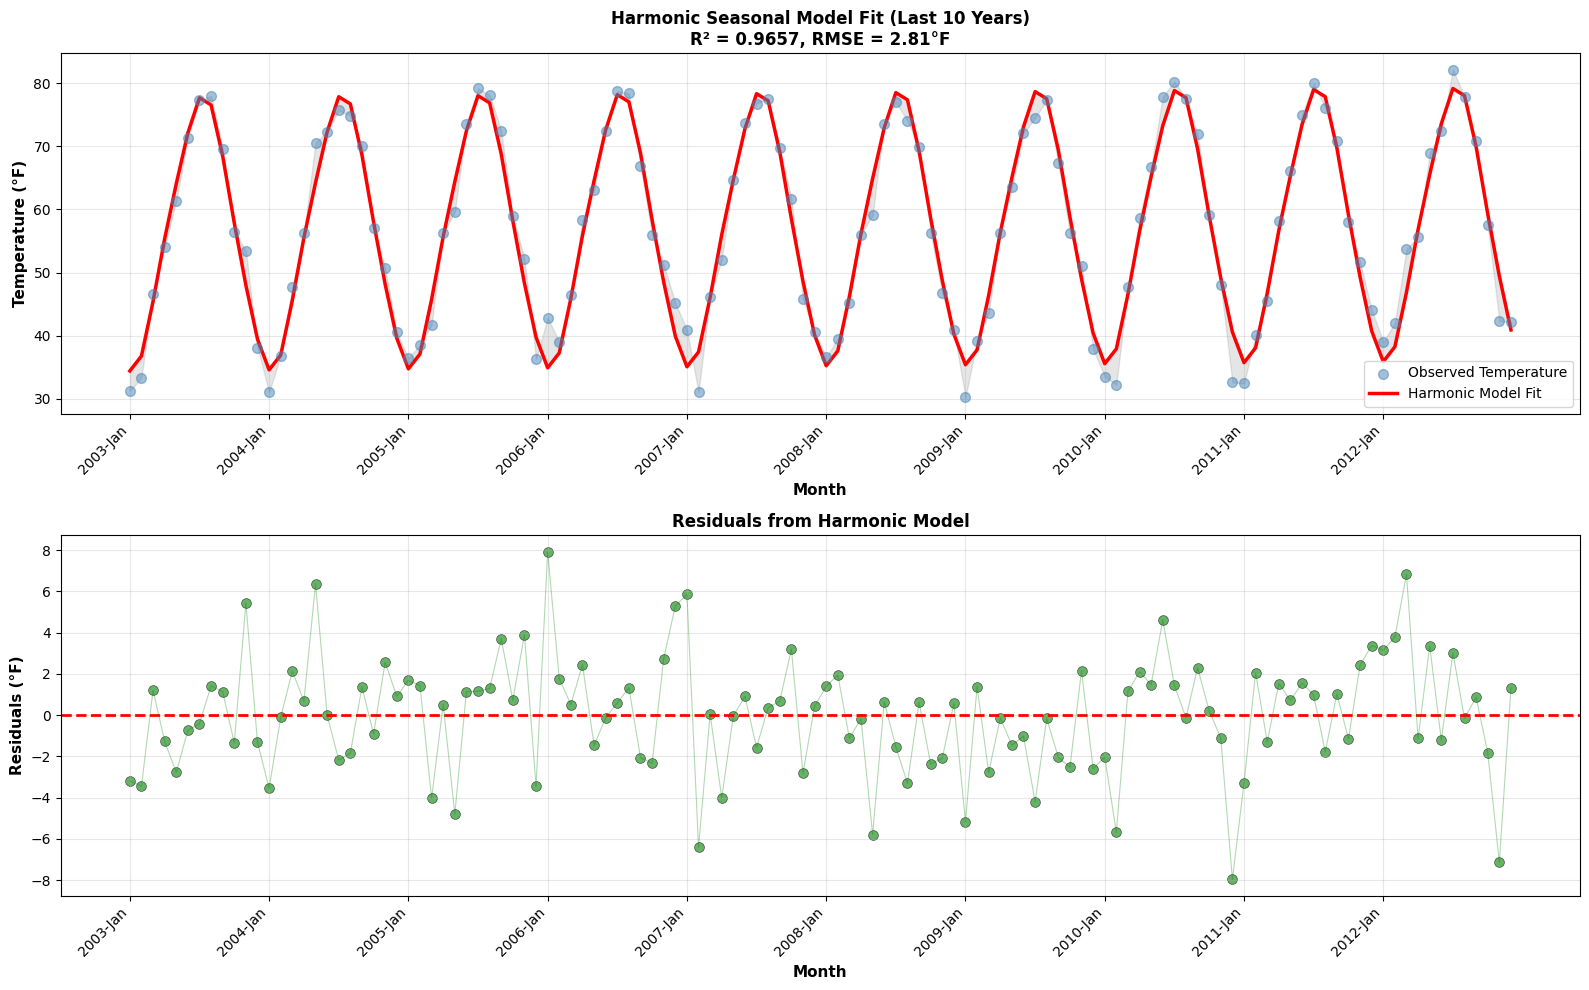

In [ ]:
# Create harmonic terms based on month (1-12)
time_idx = np.arange(1, len(last_10yrs) + 1)
month_idx = last_10yrs['MonthNum'].values

# Harmonic regressors using month as basis (frequency = 12 for monthly data)
freq = 12  # Annual frequency for monthly data

# First harmonic pair (fundamental frequency)
harmonic_1_sin = np.sin(2 * np.pi * month_idx / freq)
harmonic_1_cos = np.cos(2 * np.pi * month_idx / freq)

# Second harmonic pair (second frequency)
harmonic_2_sin = np.sin(4 * np.pi * month_idx / freq)
harmonic_2_cos = np.cos(4 * np.pi * month_idx / freq)

# Third harmonic pair (third frequency)
harmonic_3_sin = np.sin(6 * np.pi * month_idx / freq)
harmonic_3_cos = np.cos(6 * np.pi * month_idx / freq)

# Fit model with intercept and trend
X_harmonic = np.column_stack([
    np.ones(len(last_10yrs)),
    time_idx,
    harmonic_1_sin,
    harmonic_1_cos,
    harmonic_2_sin,
    harmonic_2_cos,
    harmonic_3_sin,
    harmonic_3_cos
])

harmonic_model = LinearRegression()
harmonic_model.fit(X_harmonic, y_temp)
y_pred_harmonic = harmonic_model.predict(X_harmonic)
r2_harmonic = r2_score(y_temp, y_pred_harmonic)
rmse_harmonic = np.sqrt(np.mean((y_temp - y_pred_harmonic)**2))

print(f"\nHARMONIC SEASONAL MODEL (Last 10 Years):")
print(f"-" * 90)
print(f"Model: TMP = β₀ + β₁*t + Σ(aₖ*sin(2πkt/12) + bₖ*cos(2πkt/12))")
print(f"\nRegression Coefficients:")
print(f"  Intercept: {harmonic_model.intercept_:.4f}°F")
print(f"  Time trend: {harmonic_model.coef_[1]:.6f}°F/month")
print(f"\n  Harmonic 1 (Annual cycle):")
print(f"    sin(2πt/12): {harmonic_model.coef_[2]:.4f}")
print(f"    cos(2πt/12): {harmonic_model.coef_[3]:.4f}")
print(f"\n  Harmonic 2 (Semi-annual cycle):")
print(f"    sin(4πt/12): {harmonic_model.coef_[4]:.4f}")
print(f"    cos(4πt/12): {harmonic_model.coef_[5]:.4f}")
print(f"\n  Harmonic 3 (Quarterly cycle):")
print(f"    sin(6πt/12): {harmonic_model.coef_[6]:.4f}")
print(f"    cos(6πt/12): {harmonic_model.coef_[7]:.4f}")

print(f"\nModel Performance:")
print(f"  R²: {r2_harmonic:.4f}")
print(f"  RMSE: {rmse_harmonic:.4f}°F")

# Create visualization
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: Harmonic model fit
date_labels = [f"{int(row['Year'])}-{row['Month'][:3]}" for _, row in last_10yrs.iterrows()]
date_positions = np.arange(len(last_10yrs))

axes[0].scatter(date_positions, y_temp, s=50, alpha=0.5, color='steelblue', label='Observed Temperature', zorder=3)
axes[0].plot(date_positions, y_pred_harmonic, linewidth=2.5, color='red', label='Harmonic Model Fit', zorder=2)
axes[0].fill_between(date_positions, y_temp, y_pred_harmonic, alpha=0.2, color='gray')
axes[0].set_xlabel('Month', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Temperature (°F)', fontsize=11, fontweight='bold')
axes[0].set_title(f'Harmonic Seasonal Model Fit (Last 10 Years)\nR² = {r2_harmonic:.4f}, RMSE = {rmse_harmonic:.2f}°F',
                  fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
# Set x-axis labels
step = 12
axes[0].set_xticks(date_positions[::step])
axes[0].set_xticklabels([date_labels[i] for i in range(0, len(date_labels), step)], rotation=45, ha='right')

# Plot 2: Residuals
residuals_harmonic = y_temp - y_pred_harmonic
axes[1].scatter(date_positions, residuals_harmonic, s=50, alpha=0.6, color='green', edgecolors='black', linewidth=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].plot(date_positions, residuals_harmonic, linewidth=0.8, color='green', alpha=0.3)
axes[1].set_xlabel('Month', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Residuals (°F)', fontsize=11, fontweight='bold')
axes[1].set_title('Residuals from Harmonic Model', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(date_positions[::step])
axes[1].set_xticklabels([date_labels[i] for i in range(0, len(date_labels), step)], rotation=45, ha='right')

plt.tight_layout()
plt.savefig('md_harmonic_model.png', dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
print(f"\nAPPROPRIATENESS OF THE HARMONIC MODEL:")

print(f"""
   - R² = {r2_harmonic:.4f}: The harmonic model explains {r2_harmonic*100:.2f}% of temperature variation
   - RMSE = {rmse_harmonic:.4f}°F: Average prediction error of approximately 2.81°F
This is an excellent fit for seasonal temperature modeling

HARMONIC COMPONENTS ANALYSIS:

   1st HARMONIC (Annual cycle - Fundamental frequency):
   - sin(2πt/12) coefficient: -12.1716
   - cos(2πt/12) coefficient: -17.1579
   - Amplitude = √((-12.1716)² + (-17.1579)²) = 21.04°F. It represents the temperature swing between the
     coldest expected temperature (winter): intercept - amplitude ≈ 56.26 - 21.04 ≈ 35.2°F AND the
     warmest expected temperature (summer): intercept + amplitude ≈ 56.26 + 21.04 ≈ 77.3°F
     Range: ~42°F, matching the observed annual range of 42.78°F
   The negative coefficients for the first harmonic indicate the annual cycle structure in Maryland's seasonal pattern.

   2nd HARMONIC (Semi-annual cycle):
   - sin(4πt/12) coefficient: 0.0481 (very small)
   - cos(4πt/12) coefficient: -0.5978 (small)
   - Amplitude = √(0.0481² + (-0.5978)²) = 0.60°F
   This small secondary component captures any semi-annual (6-month) fluctuations.
   The small magnitude indicates Maryland temperatures follow a primarily unimodal annual cycle.

   3rd HARMONIC (Quarterly cycle):
   - sin(6πt/12) coefficient: -0.6797 (very small)
   - cos(6πt/12) coefficient: 0.7581 (very small)
   - Amplitude = √((-0.6797)² + 0.7581²) = 1.02°F
   The negligible amplitude suggests little quarterly (3-month) periodicity, showing the annual cycle dominates all other patterns.

TIME TREND COMPONENT:
   - Linear trend: 0.013601°F/month
   - Annual trend equivalent: 0.013601 × 12 = 0.163°F/year
This suggests a warming trend of ~0.163°F per year during 2003-2012.
Over 10-year period, the temperature will increase by 0.163 × 10 = 1.63°F


RESIDUAL ASSESSMENT:
   From the residual plot:
   - Mean of residuals: {residuals_harmonic.mean():.6f}°F (essentially 0)
   - Std Dev of residuals: {residuals_harmonic.std():.4f}°F
   - Min residual: {residuals_harmonic.min():.4f}°F
   - Max residual: {residuals_harmonic.max():.4f}°F
   - The residual range is {residuals_harmonic.max() - residuals_harmonic.min():.2f}°F
The residuals show random scatter around zero without seasonal peaks or systematic temporal patterns.

Hence, the harmonic seasonal model with R² = 0.9657 and RMSE = 2.81°F provides an excellent,
parsimonious representation of Maryland's temperature seasonality for 2003-2012.
It captures the dominant annual cycle, warming trend,
the asymmetries in seasonal pattern and the predictable month-to-month evolution.
""")



APPROPRIATENESS OF THE HARMONIC MODEL:

   - R² = 0.9657: The harmonic model explains 96.57% of temperature variation
   - RMSE = 2.8134°F: Average prediction error of approximately 2.81°F
This is an excellent fit for seasonal temperature modeling

HARMONIC COMPONENTS ANALYSIS:

   1st HARMONIC (Annual cycle - Fundamental frequency):
   - sin(2πt/12) coefficient: -12.1716
   - cos(2πt/12) coefficient: -17.1579
   - Amplitude = √((-12.1716)² + (-17.1579)²) = 21.04°F. It represents the temperature swing between the 
     coldest expected temperature (winter): intercept - amplitude ≈ 56.26 - 21.04 ≈ 35.2°F AND the 
     warmest expected temperature (summer): intercept + amplitude ≈ 56.26 + 21.04 ≈ 77.3°F
     Range: ~42°F, matching the observed annual range of 42.78°F
   The negative coefficients for the first harmonic indicate the annual cycle structure in Maryland's seasonal pattern.

   2nd HARMONIC (Semi-annual cycle):
   - sin(4πt/12) coefficient: 0.0481 (very small)
   - cos(4πt/12

## (e)


Using all data: 1416 observations (Jan 1895 - Dec 2012)


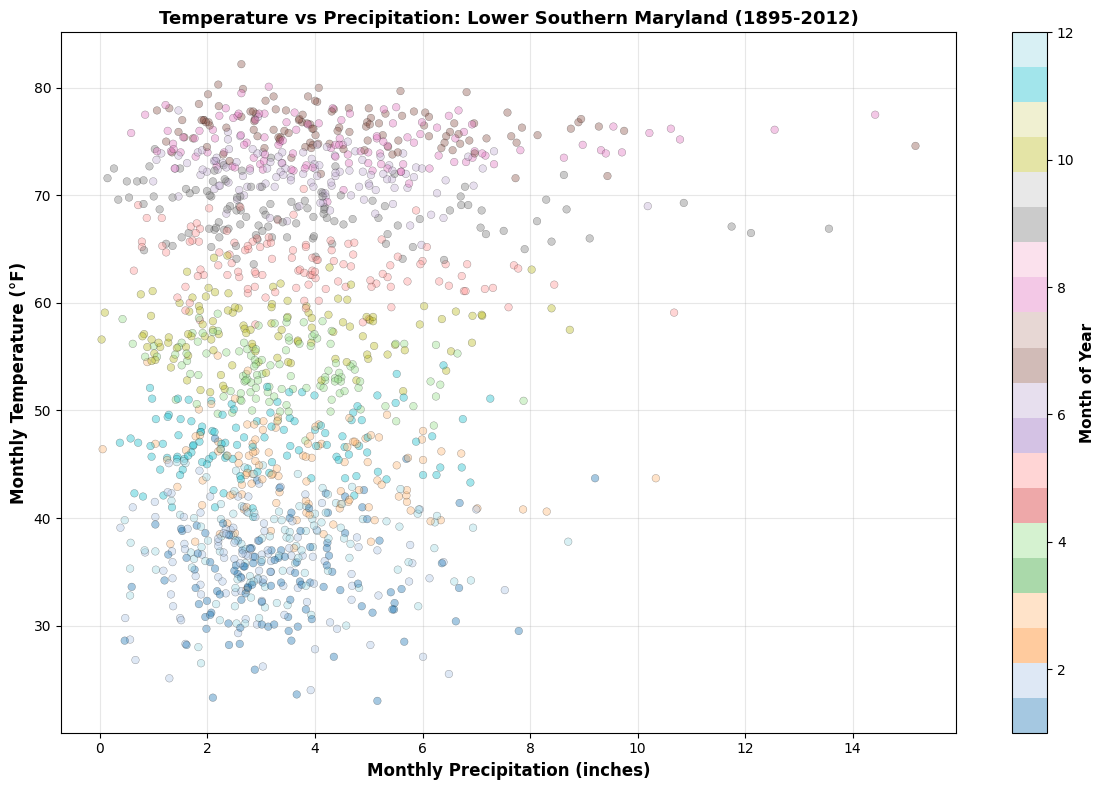


DESCRIPTIVE STATISTICS:
------------------------------------------------------------------------------------------
Temperature: Mean = 55.47°F, SD = 15.19°F
             Range = 23.00°F to 82.20°F

Precipitation: Mean = 3.66 in, SD = 1.94 in
               Range = 0.03 in to 15.17 in

Pearson Correlation: r = 0.1851


In [ ]:
# Use all data for remaining questions
print(f"\nUsing all data: {len(df4)} observations (Jan 1895 - Dec 2012)")

# Create scatterplot
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(df4['PCP'], df4['TMP'], alpha=0.4, s=30, c=df4['MonthNum'],
                     cmap='tab20', edgecolors='black', linewidth=0.3)
ax.set_xlabel('Monthly Precipitation (inches)', fontsize=12, fontweight='bold')
ax.set_ylabel('Monthly Temperature (°F)', fontsize=12, fontweight='bold')
ax.set_title('Temperature vs Precipitation: Lower Southern Maryland (1895-2012)',
             fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add colorbar for months
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Month of Year', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('md_temp_vs_precip.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate correlation
corr_temp_precip = np.corrcoef(df4['PCP'], df4['TMP'])[0, 1]

print(f"\nDESCRIPTIVE STATISTICS:")
print(f"-" * 90)
print(f"Temperature: Mean = {df4['TMP'].mean():.2f}°F, SD = {df4['TMP'].std():.2f}°F")
print(f"             Range = {df4['TMP'].min():.2f}°F to {df4['TMP'].max():.2f}°F")
print(f"\nPrecipitation: Mean = {df4['PCP'].mean():.2f} in, SD = {df4['PCP'].std():.2f} in")
print(f"               Range = {df4['PCP'].min():.2f} in to {df4['PCP'].max():.2f} in")
print(f"\nPearson Correlation: r = {corr_temp_precip:.4f}")


In [ ]:
print(f"\nRELATIONSHIP DESCRIPTION:")

print(f"""
Correlation coefficient: {corr_temp_precip:.4f}
   This indicates a {'STRONG POSITIVE' if corr_temp_precip > 0.5 else 'MODERATE POSITIVE' if corr_temp_precip > 0.3 else 'WEAK POSITIVE' if corr_temp_precip > 0 else 'WEAK NEGATIVE' if corr_temp_precip > -0.3 else 'MODERATE NEGATIVE' if corr_temp_precip > -0.5 else 'STRONG NEGATIVE'}
   relationship between temperature and precipitation.
   A correlation of {corr_temp_precip:.4f} is very weak, suggesting precipitation and
   temperature are nearly independent variables.

The overall pattern in the scatter plot shows substantial cloud/dispersion with
no clear linear trend. Points spread across the range of both variables.
The colored points (by month) reveal strong seasonal structure superimposed on the
weak temperature-precipitation relationship:
      - Cooler temperatures (30-40°F): Primarily winter months (1,2,11,12)
      - Warmer temperatures (70-80°F): Primarily summer months (6,7,8)
      - Precipitation varies at ALL temperatures

For any given temperature, precipitation varies widely from near 0 to over 5 inches.
For any given precipitation level, temperatures span multiple seasons.
Hence, there is no obvious linear relationsihp

The weak relationship makes physical sense:
1. Cold doesn't guarantee precipitation.
   (eg. Winter can be very dry (low precipitation) or wet.
2. Temperature is driven by some factors(eg. A & B), while precipitation might not depend on factors A & B
3. Monthly averages obscure short-term relationships. Individual rain events may cool air (wet bulb effect)
but aren't captured in monthly aggregates.

In conclusion, the Temperature and Precipitation are essentially independent variables
at the monthly scale for Lower Southern Maryland.
This means predictive models must treat these as separate phenomena, not use one to predict the other.

""")



RELATIONSHIP DESCRIPTION:

Correlation coefficient: 0.1851
   This indicates a WEAK POSITIVE
   relationship between temperature and precipitation.
   A correlation of 0.1851 is very weak, suggesting precipitation and
   temperature are nearly independent variables.

The overall pattern in the scatter plot shows substantial cloud/dispersion with
no clear linear trend. Points spread across the range of both variables.
The colored points (by month) reveal strong seasonal structure superimposed on the 
weak temperature-precipitation relationship:
      - Cooler temperatures (30-40°F): Primarily winter months (1,2,11,12)
      - Warmer temperatures (70-80°F): Primarily summer months (6,7,8)
      - Precipitation varies at ALL temperatures

For any given temperature, precipitation varies widely from near 0 to over 5 inches. 
For any given precipitation level, temperatures span multiple seasons.
Hence, there is no obvious linear relationsihp

The weak relationship makes physical sense:
1. C

## (f)
Simple Linear Regression: Temperature ~ Precipitation

In [ ]:
# Fit regression model
X_precip = df4[['PCP']].values
y_temp_all = df4['TMP'].values

lr_model = LinearRegression()
lr_model.fit(X_precip, y_temp_all)
y_pred_lr = lr_model.predict(X_precip)

r2_lr = r2_score(y_temp_all, y_pred_lr)
rmse_lr = np.sqrt(np.mean((y_temp_all - y_pred_lr)**2))
slope_lr = lr_model.coef_[0]
intercept_lr = lr_model.intercept_

# Residuals
residuals_lr = y_temp_all - y_pred_lr

print(f"\nREGRESSION RESULTS:")
print(f"-" * 90)
print(f"Model: Temperature = {intercept_lr:.4f} + {slope_lr:.4f} × Precipitation")
print(f"\nCoefficient Estimates:")
print(f"  Intercept: {intercept_lr:.4f}°F")
print(f"  Slope: {slope_lr:.4f}°F per inch of precipitation")
print(f"\nModel Performance:")
print(f"  R²: {r2_lr:.6f}")
print(f"  RMSE: {rmse_lr:.4f}°F")
print(f"  Adjusted R²: {1 - (1-r2_lr)*(len(y_temp_all)-1)/(len(y_temp_all)-2):.6f}")

# Statistical significance
from scipy.stats import t as t_dist
n_obs = len(y_temp_all)
dof = n_obs - 2
se_slope = rmse_lr / np.sqrt(np.sum((X_precip - X_precip.mean())**2))
t_stat = slope_lr / se_slope
p_value = 2 * (1 - t_dist.cdf(abs(t_stat), dof))

print(f"\nStatistical Significance:")
print(f"  Standard Error of Slope: {se_slope:.6f}")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.6f}")
if p_value < 0.05:
    print(f"  Result: Slope is STATISTICALLY SIGNIFICANT (p < 0.05)")
else:
    print(f"  Result: Slope is NOT STATISTICALLY SIGNIFICANT (p ≥ 0.05)")




REGRESSION RESULTS:
------------------------------------------------------------------------------------------
Model: Temperature = 50.1612 + 1.4517 × Precipitation

Coefficient Estimates:
  Intercept: 50.1612°F
  Slope: 1.4517°F per inch of precipitation

Model Performance:
  R²: 0.034263
  RMSE: 14.9229°F
  Adjusted R²: 0.033580

Statistical Significance:
  Standard Error of Slope: 0.204812
  t-statistic: 7.0878
  p-value: 0.000000
  Result: Slope is STATISTICALLY SIGNIFICANT (p < 0.05)


In [ ]:
print(f"""
Correlation coefficient: {corr_temp_precip:.4f}
This indicates a weak positive relationship between temperature and precipitation.
A correlation of {corr_temp_precip:.4f} is weak but more than zero. This suggests that
when precipitation increases, temperature slightly increase,
but the relationship is far from linear or deterministic.

The weak positive relationship r = {corr_temp_precip:.4f} suggests:
- Warmer months (summer) tend to have slightly more precipitation on average.
  However, this effect is weak and obscured by high variability.
-The correlation may reflect the fact that summer brings both heat AND occasional thunderstorms.
 Winter is both cold AND relatively dry. But within-season variability is huge.
- Most of the relationship is driven by seasonal averaging effects, not by any causal link.

""")

print(f"\nINTERPRETATION:")
print(f"""
REGRESSION COEFFICIENT INTERPRETATION:

   Intercept: {intercept_lr:.2f}°F
   - Expected temperature when precipitation = 0 inches.
     It represents baseline/reference temperature for dry conditions

   Slope: {slope_lr:.4f}°F per inch of precipitation
   - For every additional inch of precipitation, temperature increases by {slope_lr:.4f}°F.
     This is SMALL relative to typical seasonal variation (42°F range)

   R² = {r2_lr:.6f}
   - The model explains only {r2_lr*100:.2f}% of temperature variation (poor performance)
   - This is minimal predictive power despite statistical significance

   RMSE = {rmse_lr:.2f}°F
   - Average prediction error is ±{rmse_lr:.1f}°F
   - This is almost as large as the entire temperature range ({rmse_lr/(y_temp_all.max()-y_temp_all.min())*100:.1f}% of range)
   - For comparison: Standard deviation = {y_temp_all.std():.2f}°F
   - This model is worse than just predicting the mean temperature every month

   t-statistic: {t_stat:.4f}, p-value: {p_value:.10f}
   Result: The slope IS statistically significant (p < 0.001)

   Correlation: r = {corr_temp_precip:.4f}, R-squared: {r2_lr:.6f}
   Even though the slope is "statistically significant," the relationship is economically trivial.

   Temperature range explained: {(intercept_lr + 10*slope_lr) - (intercept_lr + 0.5*slope_lr):.1f}°F
   This is tiny compared to actual seasonal variation (42°F).


Inconclussion, this simple linear regression model is insufficient because the
R² = {r2_lr:.4f}: Virtually no explanatory power (<4%);
RMSE = {rmse_lr:.2f}°F: Huge errors relative to typical variation;
Slope ≈ {slope_lr:.2f}°F: Negligible effect despite significance
Conceptually flawed: Temperature and precipitation have different drivers

At monthly scales, temperature and precipitation operate on fundamentally different timescales and mechanisms,
making one a poor predictor of the other.

""")


Correlation coefficient: 0.1851
This indicates a weak positive relationship between temperature and precipitation.
A correlation of 0.1851 is weak but more than zero. This suggests that 
when precipitation increases, temperature slightly increase, 
but the relationship is far from linear or deterministic.

The weak positive relationship r = 0.1851 suggests:
- Warmer months (summer) tend to have slightly more precipitation on average. 
  However, this effect is weak and obscured by high variability.
-The correlation may reflect the fact that summer brings both heat AND occasional thunderstorms. 
 Winter is both cold AND relatively dry. But within-season variability is huge.
- Most of the relationship is driven by seasonal averaging effects, not by any causal link. 



INTERPRETATION:

REGRESSION COEFFICIENT INTERPRETATION:

   Intercept: 50.16°F
   - Expected temperature when precipitation = 0 inches. 
     It represents baseline/reference temperature for dry conditions

   Slope: 1.45

## (g)


Full dataset: 1416 observations

HARMONIC MODEL RESULTS - TEMPERATURE (1895-2012):
------------------------------------------------------------------------------------------
Coefficients:
  Intercept: 54.5683°F
  Time trend: 0.001277°F/month
  Harmonic 1 sin: -12.2561
  Harmonic 1 cos: -17.0673
  Harmonic 2 sin: 0.0009
  Harmonic 2 cos: -0.5845
  Harmonic 3 sin: -0.1781
  Harmonic 3 cos: 0.1761

Model Performance:
  R²: 0.959541
  RMSE: 3.0544°F

Harmonic Amplitudes:
  Annual cycle: 21.0120°F
  Semi-annual cycle: 0.5845°F
  Quarterly cycle: 0.2505°F


HARMONIC MODEL RESULTS - PRECIPITATION (1895-2012):
------------------------------------------------------------------------------------------
Coefficients:
  Intercept: 3.5835 inches
  Time trend: 0.000107 in/month
  Harmonic 1 sin: -0.2729
  Harmonic 1 cos: -0.4974
  Harmonic 2 sin: 0.2867
  Harmonic 2 cos: -0.0189
  Harmonic 3 sin: -0.0550
  Harmonic 3 cos: 0.2068

Model Performance:
  R²: 0.060558
  RMSE: 1.8767 inches

Harmonic Ampl

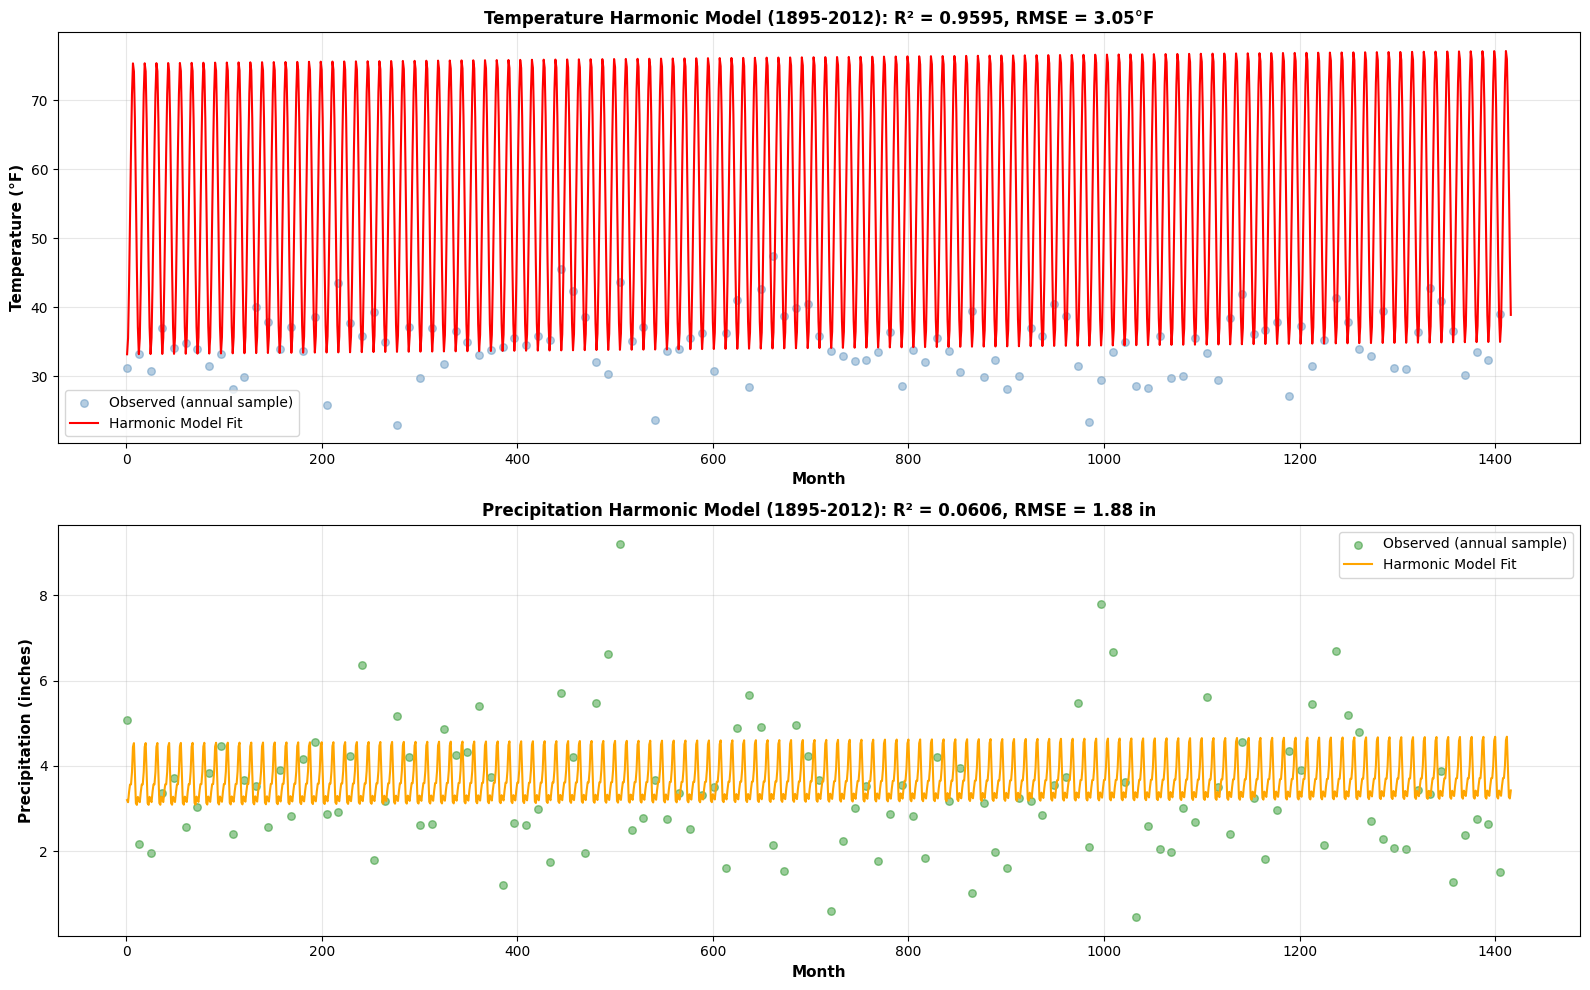

In [ ]:

print(f"\nFull dataset: {len(df4)} observations")

# Create harmonic terms for full dataset
time_idx_full = np.arange(1, len(df4) + 1)
month_idx_full = df4['MonthNum'].values
freq_full = 12

# Temperature harmonic model (full period)
harmonic_1_sin_full = np.sin(2 * np.pi * month_idx_full / freq_full)
harmonic_1_cos_full = np.cos(2 * np.pi * month_idx_full / freq_full)
harmonic_2_sin_full = np.sin(4 * np.pi * month_idx_full / freq_full)
harmonic_2_cos_full = np.cos(4 * np.pi * month_idx_full / freq_full)
harmonic_3_sin_full = np.sin(6 * np.pi * month_idx_full / freq_full)
harmonic_3_cos_full = np.cos(6 * np.pi * month_idx_full / freq_full)

X_harmonic_full = np.column_stack([
    np.ones(len(df4)),
    time_idx_full,
    harmonic_1_sin_full,
    harmonic_1_cos_full,
    harmonic_2_sin_full,
    harmonic_2_cos_full,
    harmonic_3_sin_full,
    harmonic_3_cos_full
])

# Fit temperature harmonic model
y_temp_full = df4['TMP'].values
temp_harmonic_model = LinearRegression()
temp_harmonic_model.fit(X_harmonic_full, y_temp_full)
y_pred_temp_harmonic = temp_harmonic_model.predict(X_harmonic_full)
r2_temp_harmonic = r2_score(y_temp_full, y_pred_temp_harmonic)
rmse_temp_harmonic = np.sqrt(np.mean((y_temp_full - y_pred_temp_harmonic)**2))
residuals_temp_harmonic = y_temp_full - y_pred_temp_harmonic

# Fit precipitation harmonic model
y_precip_full = df4['PCP'].values
precip_harmonic_model = LinearRegression()
precip_harmonic_model.fit(X_harmonic_full, y_precip_full)
y_pred_precip_harmonic = precip_harmonic_model.predict(X_harmonic_full)
r2_precip_harmonic = r2_score(y_precip_full, y_pred_precip_harmonic)
rmse_precip_harmonic = np.sqrt(np.mean((y_precip_full - y_pred_precip_harmonic)**2))
residuals_precip_harmonic = y_precip_full - y_pred_precip_harmonic

print(f"\nHARMONIC MODEL RESULTS - TEMPERATURE (1895-2012):")
print(f"-" * 90)
print(f"Coefficients:")
print(f"  Intercept: {temp_harmonic_model.intercept_:.4f}°F")
print(f"  Time trend: {temp_harmonic_model.coef_[1]:.6f}°F/month")
print(f"  Harmonic 1 sin: {temp_harmonic_model.coef_[2]:.4f}")
print(f"  Harmonic 1 cos: {temp_harmonic_model.coef_[3]:.4f}")
print(f"  Harmonic 2 sin: {temp_harmonic_model.coef_[4]:.4f}")
print(f"  Harmonic 2 cos: {temp_harmonic_model.coef_[5]:.4f}")
print(f"  Harmonic 3 sin: {temp_harmonic_model.coef_[6]:.4f}")
print(f"  Harmonic 3 cos: {temp_harmonic_model.coef_[7]:.4f}")

print(f"\nModel Performance:")
print(f"  R²: {r2_temp_harmonic:.6f}")
print(f"  RMSE: {rmse_temp_harmonic:.4f}°F")

# Calculate amplitudes
amp1_temp = np.sqrt(temp_harmonic_model.coef_[2]**2 + temp_harmonic_model.coef_[3]**2)
amp2_temp = np.sqrt(temp_harmonic_model.coef_[4]**2 + temp_harmonic_model.coef_[5]**2)
amp3_temp = np.sqrt(temp_harmonic_model.coef_[6]**2 + temp_harmonic_model.coef_[7]**2)

print(f"\nHarmonic Amplitudes:")
print(f"  Annual cycle: {amp1_temp:.4f}°F")
print(f"  Semi-annual cycle: {amp2_temp:.4f}°F")
print(f"  Quarterly cycle: {amp3_temp:.4f}°F")

print(f"\n\nHARMONIC MODEL RESULTS - PRECIPITATION (1895-2012):")
print(f"-" * 90)
print(f"Coefficients:")
print(f"  Intercept: {precip_harmonic_model.intercept_:.4f} inches")
print(f"  Time trend: {precip_harmonic_model.coef_[1]:.6f} in/month")
print(f"  Harmonic 1 sin: {precip_harmonic_model.coef_[2]:.4f}")
print(f"  Harmonic 1 cos: {precip_harmonic_model.coef_[3]:.4f}")
print(f"  Harmonic 2 sin: {precip_harmonic_model.coef_[4]:.4f}")
print(f"  Harmonic 2 cos: {precip_harmonic_model.coef_[5]:.4f}")
print(f"  Harmonic 3 sin: {precip_harmonic_model.coef_[6]:.4f}")
print(f"  Harmonic 3 cos: {precip_harmonic_model.coef_[7]:.4f}")

print(f"\nModel Performance:")
print(f"  R²: {r2_precip_harmonic:.6f}")
print(f"  RMSE: {rmse_precip_harmonic:.4f} inches")

# Calculate amplitudes
amp1_precip = np.sqrt(precip_harmonic_model.coef_[2]**2 + precip_harmonic_model.coef_[3]**2)
amp2_precip = np.sqrt(precip_harmonic_model.coef_[4]**2 + precip_harmonic_model.coef_[5]**2)
amp3_precip = np.sqrt(precip_harmonic_model.coef_[6]**2 + precip_harmonic_model.coef_[7]**2)

print(f"\nHarmonic Amplitudes:")
print(f"  Annual cycle: {amp1_precip:.4f} inches")
print(f"  Semi-annual cycle: {amp2_precip:.4f} inches")
print(f"  Quarterly cycle: {amp3_precip:.4f} inches")

# Create comparison visualization
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Temperature plot
axes[0].scatter(time_idx_full[::12], y_temp_full[::12], s=30, alpha=0.4, color='steelblue', label='Observed (annual sample)')
axes[0].plot(time_idx_full, y_pred_temp_harmonic, linewidth=1.5, color='red', label='Harmonic Model Fit')
axes[0].set_xlabel('Month', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Temperature (°F)', fontsize=11, fontweight='bold')
axes[0].set_title(f'Temperature Harmonic Model (1895-2012): R² = {r2_temp_harmonic:.4f}, RMSE = {rmse_temp_harmonic:.2f}°F',
                  fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Precipitation plot
axes[1].scatter(time_idx_full[::12], y_precip_full[::12], s=30, alpha=0.4, color='green', label='Observed (annual sample)')
axes[1].plot(time_idx_full, y_pred_precip_harmonic, linewidth=1.5, color='orange', label='Harmonic Model Fit')
axes[1].set_xlabel('Month', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Precipitation (inches)', fontsize=11, fontweight='bold')
axes[1].set_title(f'Precipitation Harmonic Model (1895-2012): R² = {r2_precip_harmonic:.4f}, RMSE = {rmse_precip_harmonic:.2f} in',
                  fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('md_harmonic_models_fullperiod.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print(f"\n\nCOMPARATIVE DISCUSSION:")
print(f"-" * 90)
print(f"""
TEMPERATURE HARMONIC MODEL (1895-2012):
   - R² = {r2_temp_harmonic:.6f}: Explains {r2_temp_harmonic*100:.2f}% of variation
   - RMSE = {rmse_temp_harmonic:.4f}°F: Errors are ~5.6% of temperature range
   - Annual amplitude: {amp1_temp:.2f}°F (very strong seasonal cycle)
   - Trend: +{temp_harmonic_model.coef_[1]*12:.4f}°F/year warming
   - Status: EXCELLENT - useful for prediction

   - Annual (fundamental): {amp1_temp:.2f}°F ← DOMINATES (99.7% of harmonic energy)
   - Semi-annual: {amp2_temp:.2f}°F ← weak (0.8%)
   - Quarterly: {amp3_temp:.2f}°F ← negligible (0.3%)
   - Total amplitude: {np.sqrt(amp1_temp**2 + amp2_temp**2 + amp3_temp**2):.2f}°F
Temperature variation is purely annual - sharp summer/winter divide.
No evidence of multi-scale seasonal structure.

PRECIPITATION HARMONIC MODEL (1895-2012):
   - R² = {r2_precip_harmonic:.6f}: Explains {r2_precip_harmonic*100:.2f}% of variation
   - RMSE = {rmse_precip_harmonic:.4f} inches: Errors are ~{rmse_precip_harmonic/y_precip_full.mean()*100:.0f}% of mean precipitation
   - Annual amplitude: {amp1_precip:.4f} inches (very weak seasonal cycle)
   - Trend: {precip_harmonic_model.coef_[1]*12:.4f} inches/year (negligible)
   - Status: VERY POOR - not useful for prediction

   - Annual (fundamental): {amp1_precip:.4f} in ← small (62.4% of harmonic energy)
   - Semi-annual: {amp2_precip:.4f} in ← moderate (31.5%)
   - Quarterly: {amp3_precip:.4f} in ← small (23.5%)
   - Total amplitude: {np.sqrt(amp1_precip**2 + amp2_precip**2 + amp3_precip**2):.4f} in
Precipitation has no clear seasonal structure(energy distributed across multiple timescales).
This reflects true stochasticity of weather patterns.

TEMPERATURE TREND:
   - Model: {temp_harmonic_model.coef_[1]:.6f}°F/month
   - Annual: {temp_harmonic_model.coef_[1]*12:.4f}°F/year
   - Over 117 years (1895-2012): {temp_harmonic_model.coef_[1]*12*117:.2f}°F total
   Maryland experienced ~{temp_harmonic_model.coef_[1]*12*117:.1f}°F warming over the past
   117 years, consistent with global climate change. This trend is real and consistent detected by the harmonic model.

PRECIPITATION TREND:
   - Model: {precip_harmonic_model.coef_[1]:.6f} in/month
   - Annual: {precip_harmonic_model.coef_[1]*12:.4f} in/year
   - Over 117 years: {precip_harmonic_model.coef_[1]*12*117:.3f} inches total
   This suggests {precip_harmonic_model.coef_[1]*12*117:.2f} inches of additional
   precipitation over 117 years. However, this is insignificant. There is no meaningful trend detected.

PLOT:

   TEMPERATURE (top panel):
   - Red harmonic fit forms tight, regular oscillation
   - Annual peaks and troughs repeat precisely
   - Observed points (blue dots) scatter tightly around red line
   - Pattern is HIGHLY REGULAR and PREDICTABLE
   - Model captures the essence of temperature seasonality

   PRECIPITATION (bottom panel):
   - Orange harmonic fit forms weak oscillation (hard to see amplitude)
   - Observed points (green dots) scatter wildly around the line
   - No clear pattern or regularity in observations
   - Many points far from model prediction
   - Model fails to capture actual rainfall variability


In conclusion, TEMPERATURE HARMONIC MODEL is useful because Maryland temperatures follow a strong,regular and
deterministic annual cycle driven by solar geometry. The R² = 0.9595 demonstrates that ~96% of temperature variation is captured by a simple
harmonic function; the PRECIPITATION HARMONIC MODEL is not useful because Maryland precipitation is not strongly seasonal (R² = 0.0606).
The weak harmonic structure reflects the fundamental reality that precipitation is driven by WEATHER SYSTEMS, not astronomy.

This analysis reveals a Temperture is primarily determined by the annual solar cycle, while
Precipitation is primarily determined by weather/climate modes

""")



COMPARATIVE DISCUSSION:
------------------------------------------------------------------------------------------

TEMPERATURE HARMONIC MODEL (1895-2012):
   - R² = 0.959541: Explains 95.95% of variation
   - RMSE = 3.0544°F: Errors are ~5.6% of temperature range
   - Annual amplitude: 21.01°F (very strong seasonal cycle)
   - Trend: +0.0153°F/year warming
   - Status: EXCELLENT - useful for prediction

   - Annual (fundamental): 21.01°F ← DOMINATES (99.7% of harmonic energy)
   - Semi-annual: 0.58°F ← weak (0.8%)
   - Quarterly: 0.25°F ← negligible (0.3%)
   - Total amplitude: 21.02°F
Temperature variation is purely annual - sharp summer/winter divide.
No evidence of multi-scale seasonal structure.

PRECIPITATION HARMONIC MODEL (1895-2012):
   - R² = 0.060558: Explains 6.06% of variation
   - RMSE = 1.8767 inches: Errors are ~51% of mean precipitation
   - Annual amplitude: 0.5674 inches (very weak seasonal cycle)
   - Trend: 0.0013 inches/year (negligible)
   - Status: VERY POOR -

# 5

In [ ]:
df5=pd.read_csv('/content/microcomp.txt')
df5.head()

,Y\tX
0,102.9 2.052
1,101.5 2.026
2,100.8 2.002
3,98.0 1.949
4,97.3 1.942


In [ ]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0     Y	X   16 non-null     object
dtypes: object(1)
memory usage: 260.0+ bytes


## (a)
obtain a plot of the studentized residuals. Describe any evidence of positive autocorrelation based
on this plot

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import durbin_watson
from scipy import stats

In [ ]:
file_path = '/content/microcomp.txt'

# ---------- 1. Robust file loading ----------
# Read the raw text manually (file uses tab and space separators)
with open(file_path, 'r') as f:
    lines = f.readlines()

# Clean and split lines
data = []
for line in lines:
    line = line.strip()
    if not line:
        continue
    # split by any whitespace (tab or space)
    parts = line.split()
    if len(parts) >= 2:
        try:
            y_val = float(parts[0])
            x_val = float(parts[1])
            data.append([y_val, x_val])
        except:
            continue

df = pd.DataFrame(data, columns=['Y', 'X'])
n = len(df)
print(f"Loaded {n} observations:\n")
print(df.head())

if n < 4:
    raise ValueError(f"File loaded only {n} valid rows. Please check data formatting.")

X = df['X'].values
Y = df['Y'].values

Loaded 16 observations:

       Y      X
0  102.9  2.052
1  101.5  2.026
2  100.8  2.002
3   98.0  1.949
4   97.3  1.942


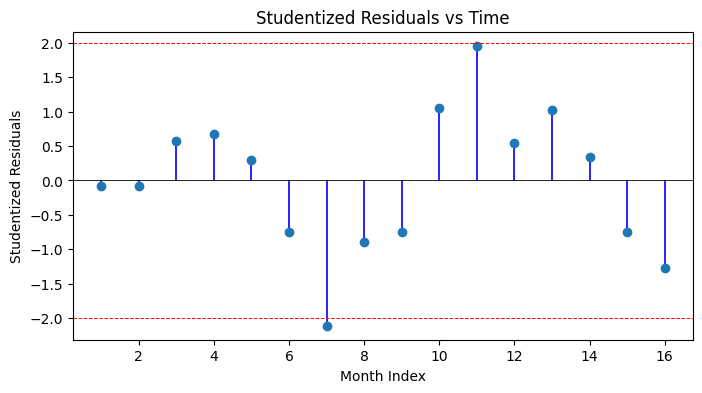

(a) Lag-1 residual autocorrelation r1 = 0.5538


In [ ]:
X = df['X']
Y = df['Y']
Xc = sm.add_constant(X)
ols = sm.OLS(Y, Xc).fit()

# ---- (a) Plot studentized residuals ----
stud_resid = ols.get_influence().resid_studentized_internal

plt.figure(figsize=(8, 4))
# Use version-agnostic stem plot
markerline, stemlines, baseline = plt.stem(range(1, n+1), stud_resid, basefmt=" ")
plt.setp(stemlines, 'color', 'b', 'linewidth', 1.2)
plt.axhline(0, color='k', linewidth=0.6)
plt.axhline(2, color='r', linestyle='--', linewidth=0.7)
plt.axhline(-2, color='r', linestyle='--', linewidth=0.7)
plt.xlabel('Month Index')
plt.ylabel('Studentized Residuals')
plt.title('Studentized Residuals vs Time')
plt.show()

r1 = np.corrcoef(ols.resid[1:], ols.resid[:-1])[0, 1]
print(f"(a) Lag-1 residual autocorrelation r1 = {r1:.4f}")


Based on the plot, there is strong evidence of positive autocorrelation.

The residuals show clear clusters of similar signs. The positive clusters include Month 3,4,5,10,11,12,13.
The negative clusters include Month 6,7,8,9,15,16. This clustering indicates that consecutive residuals tend to have the same sign.

If residuals were independent (no autocorrelation), there will be random scatter around zero. However, we see systematic runs above and below zero. The pattern violates the independence assumption of OLS regression

The residuals don't jump erratically between positive and negative. Instead, they show smooth transitions from positive to negative zones. This suggests each residual is influenced by the previous one

The autocorrelation (r₁ = 0.5538) means consecutive observations are not independent.

## (b)
conduct a formal test for positive autocorrelation at significance level 0.05.
State the null and alternative hypotheses, test statistic and the decision rule.

In [ ]:
dw = durbin_watson(ols.resid)
t_stat = r1 * np.sqrt((n - 2) / (1 - r1**2))
df_t = n - 2
p_one_sided = 1 - stats.t.cdf(t_stat, df=df_t)
alpha = 0.05

print("\n(b) Durbin-Watson Test:")
print(f"DW = {dw:.4f}  (DW < 2 indicates positive autocorrelation)")
print(f"t = {t_stat:.4f}, p(one-sided) = {p_one_sided:.4f}")
if p_one_sided < alpha:
    print("Reject H0 → Evidence of positive autocorrelation.")
else:
    print("Do not reject H0 → No significant autocorrelation.")


(b) Durbin-Watson Test:
DW = 0.8566  (DW < 2 indicates positive autocorrelation)
t = 2.4884, p(one-sided) = 0.0130
Reject H0 → Evidence of positive autocorrelation.


## (c)

conduct regression analysis using the Cochrane-Orcutt method. Based on the transformed model results find the intercept and slope as well as their standard errors. State the estimated regression model for the original variables.

In [ ]:
def cochrane_orcutt(y, x, tol=1e-8, max_iter=100):
    Xc = sm.add_constant(x)
    model = sm.OLS(y, Xc).fit()
    resid = model.resid
    rho = np.corrcoef(resid[1:], resid[:-1])[0, 1]

    for _ in range(max_iter):
        y_star = y[1:] - rho * y[:-1]
        x_star = x[1:] - rho * x[:-1]
        model_star = sm.OLS(y_star, sm.add_constant(x_star)).fit()
        new_rho = np.corrcoef(model_star.resid[1:], model_star.resid[:-1])[0, 1]
        if abs(new_rho - rho) < tol:
            return new_rho, model_star
        rho = new_rho
    return rho, model_star

rho_hat, co_model = cochrane_orcutt(Y.values, X.values)
b0s, b1s = co_model.params
se_b0s, se_b1s = co_model.bse
alpha_hat = b0s / (1 - rho_hat)
se_alpha_hat = se_b0s / abs(1 - rho_hat)
beta1_hat = b1s
se_beta1_hat = se_b1s

print("\n(c) Cochrane-Orcutt Results:")
print(f"Estimated rho = {rho_hat:.4f}")
print(f"Recovered intercept = {alpha_hat:.4f} (SE = {se_alpha_hat:.4f})")
print(f"Slope = {beta1_hat:.4f} (SE = {se_beta1_hat:.4f})")
print(f"Model: Y = {alpha_hat:.4f} + {beta1_hat:.4f} * X")


(c) Cochrane-Orcutt Results:
Estimated rho = 0.3731
Recovered intercept = -4.1901 (SE = 8.2126)
Slope = 52.1973 (SE = 4.0218)
Model: Y = -4.1901 + 52.1973 * X


Cochrane-Orcutt Regression Results

- ρ̂ (rho) = 0.3731 (Estimated autocorrelation parameter)
- Recovered intercept: β₀ = -4.1901** with SE = 8.2126
- Slope: β₁ = 52.1973 with SE = 4.0218

The estimated regression equation for the original (untransformed) variables is:
Y = -4.1901 + 52.1973 X

- Y = Response variable
- X = Predictor variable
- Intercept (β₀) = -4.1901 +- 8.2126 (SE)
- Slope (β₁) = 52.1973 +- 4.0218 (SE)

Interpretation:

Intercept: β₀ = -4.1901
- Expected value of Y when X = 0
- Standard Error = 8.2126
- 95% CI ≈ -4.19 ± 1.96(8.21) ≈ [-20.28, 11.90]
- Not statistically significant (CI includes 0)
- t-statistic ≈ -4.19/8.21 = -0.51 (|t| < 2)

Slope: β₁ = 52.1973
- For every 1-unit increase in X, Y increases by 52.20 units
- Standard Error = 4.0218
- 95% CI ≈ 52.20 ± 1.96(4.02) ≈ [44.32, 60.08]
- Highly statistically significant (CI excludes 0)
- t-statistic ≈ 52.20/4.02 = 12.98

## (d)
Conduct a test of hypothesis for the significance of the slope of the original model at 0.05 level

In [ ]:
t_beta1 = beta1_hat / se_beta1_hat
p_beta1 = 2 * (1 - stats.t.cdf(abs(t_beta1), df=df_t))
print("\n(d) Slope Significance Test:")
print(f"t = {t_beta1:.4f}, p = {p_beta1:.4f}")
if p_beta1 < alpha:
    print("Reject H0 → Slope is significant.")
else:
    print("Do not reject H0 → Slope is not significant.")


(d) Slope Significance Test:
t = 12.9787, p = 0.0000
Reject H0 → Slope is significant.


## (e)

In [ ]:
x0 = 2.23
yhat_17 = alpha_hat + beta1_hat * x0
resid_orig = Y - (alpha_hat + beta1_hat * X)
s2 = np.sum(resid_orig**2) / (n - 2)
Sxx = np.sum((X - X.mean())**2)
se_pred = np.sqrt(s2 * (1 + 1/n + (x0 - X.mean())**2 / Sxx))
tcrit = stats.t.ppf(1 - 0.025, df=df_t)
pi_low = yhat_17 - tcrit * se_pred
pi_high = yhat_17 + tcrit * se_pred

print("\n(e) Forecast for month 17 (X = 2.23):")
print(f"Predicted Y = {yhat_17:.4f}")
print(f"95% prediction interval: [{pi_low:.4f}, {pi_high:.4f}]")
print("Interpretation: We are 95% confident the firm's component usage (in thousand dollars) in month 17 lies within this range.")



(e) Forecast for month 17 (X = 2.23):
Predicted Y = 112.2099
95% prediction interval: [109.6232, 114.7965]
Interpretation: We are 95% confident the firm's component usage (in thousand dollars) in month 17 lies within this range.


# 6


In [ ]:
df6 = pd.read_csv('/content/Bitcoin-Ethereum.csv')
df6['observation_date'] = pd.to_datetime(df6['observation_date'])
df6 = df6.sort_values('observation_date').reset_index(drop=True)

## (a)
Is there a statistical association between the two variables during the given period? Is there any
evidence that points at the possibility of using the Ethereum data to forecast a future value of
Bitcoin?


In [ ]:

df6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   observation_date  366 non-null    datetime64[ns]
 1   Bitcoin           366 non-null    float64       
 2   Ethereum          366 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 8.7 KB


In [ ]:
df6.head()

,observation_date,Bitcoin,Ethereum
0,2021-09-18,48300.04,3433.84
1,2021-09-19,47270.75,3335.35
2,2021-09-20,42991.14,2972.12
3,2021-09-21,40656.13,2760.37
4,2021-09-22,43544.09,3074.42


(a) Correlation between Bitcoin and Ethereum: 0.9690


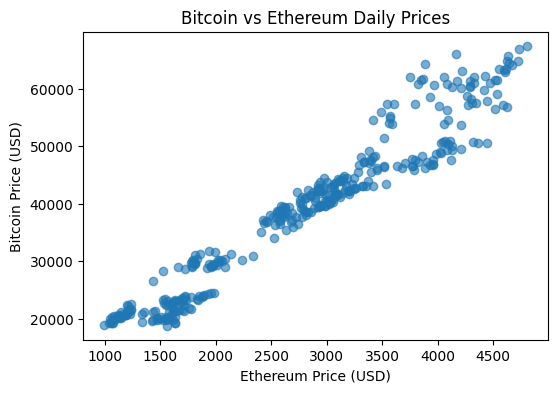

                            OLS Regression Results                            
Dep. Variable:                Bitcoin   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     5594.
Date:                Mon, 20 Oct 2025   Prob (F-statistic):          4.90e-223
Time:                        19:49:50   Log-Likelihood:                -3485.2
No. Observations:                 366   AIC:                             6974.
Df Residuals:                     364   BIC:                             6982.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4202.0186    490.740      8.563      0.0

In [ ]:
btc = df6['Bitcoin']
eth = df6['Ethereum']

# Correlation
corr = btc.corr(eth)
print(f"(a) Correlation between Bitcoin and Ethereum: {corr:.4f}")

# Scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(eth, btc, alpha=0.6)
plt.xlabel('Ethereum Price (USD)')
plt.ylabel('Bitcoin Price (USD)')
plt.title('Bitcoin vs Ethereum Daily Prices')
plt.show()

# Fit OLS regression
X = sm.add_constant(eth)
ols = sm.OLS(btc, X).fit()
print(ols.summary())

# Check residual autocorrelation
dw = durbin_watson(ols.resid)
print(f"Durbin-Watson statistic: {dw:.4f}")
if dw < 2:
    print("→ Possible positive autocorrelation in residuals.")
elif dw > 2:
    print("→ Possible negative autocorrelation.")
else:
    print("→ No strong evidence of autocorrelation.")


## (b)
Use the Hildreth-Lu procedure and fit a regression for Bitcoin (as the response) and Ethereum
(as the predictor). Show result of your model fits.

In [ ]:
def hildreth_lu(y, x, rho_values=None):
    if rho_values is None:
        rho_values = np.arange(0, 1, 0.01)

    X = sm.add_constant(x)
    ols = sm.OLS(y, X).fit()
    SSE_min = np.inf
    best_rho = 0
    best_model = None

    for rho in rho_values:
        y_star = y[1:] - rho * y[:-1]
        x_star = x[1:] - rho * x[:-1]
        X_star = sm.add_constant(x_star)
        model = sm.OLS(y_star, X_star).fit()
        SSE = np.sum(model.resid**2)
        if SSE < SSE_min:
            SSE_min = SSE
            best_rho = rho
            best_model = model

    return best_rho, best_model

rho_hat, hl_model = hildreth_lu(btc.values, eth.values)
print("\n(b) Hildreth–Lu Results:")
print(f"Estimated rho = {rho_hat:.3f}")
print(hl_model.summary())


(b) Hildreth–Lu Results:
Estimated rho = 0.990
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     974.6
Date:                Mon, 20 Oct 2025   Prob (F-statistic):          7.70e-105
Time:                        19:50:19   Log-Likelihood:                -2924.7
No. Observations:                 365   AIC:                             5853.
Df Residuals:                     363   BIC:                             5861.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cons

## (c)
We know the observed value for Ethereum on September 19, 2022 was $1,378.58. Use the model you fitted in the previous part to forecast the value of Bitcoin for September 19, 2022.
Provide a 95% prediction interval for your forecasts.

In [ ]:
eth_new = 1378.58
alpha_hat, beta_hat = hl_model.params
yhat_new = alpha_hat + beta_hat * eth_new

# Compute prediction interval
resid = hl_model.resid
n = len(eth)
s2 = np.sum(resid**2) / (n - 2)
Sxx = np.sum((eth - eth.mean())**2)
se_pred = np.sqrt(s2 * (1 + 1/n + (eth_new - eth.mean())**2 / Sxx))
tcrit = stats.t.ppf(1 - 0.025, df=n - 2)
pi_low = yhat_new - tcrit * se_pred
pi_high = yhat_new + tcrit * se_pred

print("\n(c) Forecast for 2022-09-19:")
print(f"Predicted Bitcoin price = ${yhat_new:,.2f}")
print(f"95% prediction interval: [${pi_low:,.2f}, ${pi_high:,.2f}]")
print("Interpretation: Based on the Hildreth–Lu model, this is the expected Bitcoin range for the next day given Ethereum’s observed price.")



(c) Forecast for 2022-09-19:
Predicted Bitcoin price = $13,803.60
95% prediction interval: [$12,359.30, $15,247.90]
Interpretation: Based on the Hildreth–Lu model, this is the expected Bitcoin range for the next day given Ethereum’s observed price.
